# Step 1: Preprocessing
This dataset is the BRIGHTEN (V1 and V2) dataset. It is open-access from Synapse.org.

In [303]:
############ LOAD in custom packages ################
import sys
import os
import pandas as pd
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from diptest import diptest

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform, kurtosis

# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Define data directory
brighten_dir = os.path.join(project_root, 'BRIGHTEN_data')

# Add project root to sys.path for script usage
sys.path.append(project_root)

# Import and reload (optional) custom scripts
from scripts import preprocessing as pre
from scripts import visualization as vis
from scripts import variables
importlib.reload(pre)
importlib.reload(vis)
importlib.reload(variables)

################ DEFINE column variables from data ###################
from scripts.variables import id_columns, daily_cols_v1, daily_v2_sensor, daily_v2_sensor_avg, daily_v2_phone, daily_v2_weather
from scripts.variables import phq2_cols, phq9_cols, weekly_cols, passive_cols, survey_cols, demographic_columns


# Define label variables
df_names = ['v1_day', 'v2_day', 'v1_week', 'v2_week']
aggregate_dfs = ['alldays_df','week_df']
df_list = df_names + aggregate_dfs
df_names_with_mis = ['v1_day', 'v2_day', 'v1_week', 'v2_week', 'v1_day_mis','v2_day_mis','v1_week_mis','v2_week_mis']

# Update endings list if order changes
df_endings = ['hr', 'dem', 'nonO','setNaN', 'transformed', 'unskewed','scaled','dropped','int','imp','clean','binned','lag']
df_order_agg = ['raw_merged_df','merge_df','days_df']

target_vars = phq2_cols + phq9_cols


### Load in raw files

In [266]:

############ LOAD in raw files  #############
raw_dfs = {}
raw_dfs['phq9'] = pd.read_csv(os.path.join(brighten_dir,'PHQ-9 - Depression.csv'))
raw_dfs['phq2'] = pd.read_csv(os.path.join(brighten_dir,'PHQ-2 - Depression.csv'))
raw_dfs['alc'] = pd.read_csv(os.path.join(brighten_dir,'Alcohol.csv'))
raw_dfs['gad'] = pd.read_csv(os.path.join(brighten_dir,'GAD - Anxiety.csv'))
raw_dfs['fi'] = pd.read_csv(os.path.join(brighten_dir,'SDS - Functional Impairment.csv'))
raw_dfs['sleep'] = pd.read_csv(os.path.join(brighten_dir,'Sleep Quality.csv'))
raw_dfs['gic'] = pd.read_csv(os.path.join(brighten_dir,'Patients Global Impression of Change Scale.csv'))
raw_dfs['mhs'] = pd.read_csv(os.path.join(brighten_dir,'Mental Health Services.csv'))
raw_dfs['phone_v1'] = pd.read_csv(os.path.join(brighten_dir,'Passive Phone Features Brighten V1.csv'))
raw_dfs['phone_v2'] = pd.read_csv(os.path.join(brighten_dir,'Passive Phone Communication Features Brighten V2.csv'))
raw_dfs['weather_v2'] = pd.read_csv(os.path.join(brighten_dir,'Passive Weather Features Brighten V2.csv'))
raw_dfs['mobility_v2'] = pd.read_csv(os.path.join(brighten_dir,'Passive Mobility Features Brighten V2.csv'))
raw_dfs['cluster_v2'] = pd.read_csv(os.path.join(brighten_dir,'Passive Cluster Entries Brighten V2.csv'))
raw_dfs['phq9_baseline'] = pd.read_csv(os.path.join(brighten_dir,'PHQ-9 - Baseline.csv'))
raw_dfs['demo_df_clean'] = pd.read_csv(os.path.join(brighten_dir,'demo_df_clean.csv'))
raw_dfs['mania'] = pd.read_csv(os.path.join(brighten_dir,'IMPACT Mania and Psychosis Screening.csv'))


### Clean and update column names
Also creating some binary columns by categorizing numeric data

In [267]:
######### CLEANING AND UPDATING DATA ! #####################

# Update column names
for name, df in raw_dfs.items():
    print(name)
    if 'phq9Date' in df.columns:
        df['dt'] = (pd.to_datetime(df['phq9Date'])).dt.tz_localize(None)
        df = df.drop(['phq9Date','ROW_ID','ROW_VERSION'], axis=1)
    if 'phq2' in name:
        if 'dt_yesterday' in df.columns:
            df['dt'] = (pd.to_datetime(df['dt_yesterday'])).dt.tz_localize(None)
            df = df.drop(['dt_response','ROW_ID','ROW_VERSION'], axis=1)
    if 'dt_passive' in df.columns:
        df['dt'] = (pd.to_datetime(df['dt_passive'])).dt.tz_localize(None)
        df = df.drop(['dt_passive','ROW_ID','ROW_VERSION'], axis=1)
    if 'time_in' in df.columns:
         df['dt'] = (pd.to_datetime(df['time_in'])).dt.tz_localize(None)
         df = df.drop(['time_in','time_out', 'ROW_ID','ROW_VERSION'], axis=1)
    if 'baselinePHQ9date' in df.columns:
        df['dt'] = (pd.to_datetime(df['baselinePHQ9date'])).dt.tz_localize(None)
        df = df.drop(['baselinePHQ9date', 'ROW_ID','ROW_VERSION'], axis=1)
    if 'study' in df.columns: # drop because duplicated across tables
        df = df.drop(['study'], axis=1)
    if 'cohort' in df.columns: # drop because duplicated across tables 
        df = df.drop(['cohort'], axis=1)
    if 'day' in df.columns: # drop because not consistent in all tables and can be recreated after merging
        df = df.drop(['day'], axis=1)
    if 'startdate' in df.columns:
        df['dt'] = pd.to_datetime(df['startdate'], errors='coerce').dt.tz_localize(None)
    if 'baselinePHQ9date' not in name and 'demographics' not in name:
        if 'week' not in df.columns and name != 'demo_df_clean':
            print(f'assigning week numbers to {name}')
            df = pre.assign_week_numbers(df)
    if 'sum_phq9' in df.columns:
        df.rename(columns={'sum_phq9': 'phq9_sum'}, inplace=True)
    else:
        if 'week' not in df.columns:
            df['week'] = 0
        

    # Update the dfs dictionary with the modified DataFrame
    raw_dfs[name] = df


#### create binary and category variables
raw_dfs['alc']['alc_cat'] = raw_dfs['alc']['alc_sum'].apply(pre.cat_alc)
raw_dfs['gad']['gad_cat'] = raw_dfs['gad']['gad7_sum'].apply(pre.cat_gad)
raw_dfs['phq9']['phq9_cat'] = raw_dfs['phq9']['phq9_sum'].apply(pre.cat_phq9)
raw_dfs['phq9']['phq9_bin'] = raw_dfs['phq9']['phq9_sum'].apply(pre.bin_phq9)
raw_dfs['phq2']['phq2_bin'] = raw_dfs['phq2']['phq2_sum'].apply(pre.bin_phq2)


phq9
phq2
alc
gad
fi
sleep
gic
mhs
phone_v1
phone_v2
weather_v2
assigning week numbers to weather_v2
mobility_v2
cluster_v2
phq9_baseline
assigning week numbers to phq9_baseline


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_55646/1960893385.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['dt'] = (pd.to_datetime(df['baselinePHQ9date'])).dt.tz_localize(None)


demo_df_clean
mania


### Merge together all the DFs into a large DF on the ID columns


In [268]:
### Create merge df 
raw_merged_df = pd.DataFrame()

for name, df in raw_dfs.items():
    # Check if both 'num_id' and 'dt' exist in the current df
    if 'dt' in df.columns and 'week' in df.columns and name!='demo_df_clean':
        if raw_merged_df.empty:
            raw_merged_df = df  # Start with the first valid DataFrame
            print(f'Merged in {name}')
        else:
            raw_merged_df = pd.merge(raw_merged_df, df, on=['participant_id', 'dt','week'], how='outer')
            print(f'Merged in {name}')
    
    else:
        print(f"Skipping {name}, 'participant_id' or 'dt' or 'week' column is missing.")


# Save merge_df to csv
raw_merged_df['dt'] = pd.to_datetime(raw_merged_df['dt'], errors='coerce')
raw_merged_df = raw_merged_df.sort_values(by=['participant_id', 'dt'])
raw_merged_df.to_csv(os.path.join(brighten_dir, 'raw_merged_df.csv'), index=False)
print('Saved raw_merged_df to raw_merged_df.csv')




Merged in phq9
Merged in phq2
Skipping alc, 'participant_id' or 'dt' or 'week' column is missing.
Skipping gad, 'participant_id' or 'dt' or 'week' column is missing.
Skipping fi, 'participant_id' or 'dt' or 'week' column is missing.
Skipping sleep, 'participant_id' or 'dt' or 'week' column is missing.
Skipping gic, 'participant_id' or 'dt' or 'week' column is missing.
Skipping mhs, 'participant_id' or 'dt' or 'week' column is missing.
Merged in phone_v1
Merged in phone_v2
Merged in weather_v2
Merged in mobility_v2
Merged in cluster_v2
Merged in phq9_baseline
Skipping demo_df_clean, 'participant_id' or 'dt' or 'week' column is missing.
Skipping mania, 'participant_id' or 'dt' or 'week' column is missing.
Saved raw_merged_df to raw_merged_df.csv


### Create num_id for participant IDs
Now that we have a merged df, we'll create numerical IDs for all participants so that their original participant IDs can be dropped. This is just for extra security. 

Also create a column of whether the participant is V1 or V2, which will be useful after we drop the participant_ids. 

In [269]:
# Create numerical ID
raw_merged_df = pd.read_csv(os.path.join(brighten_dir, 'raw_merged_df.csv'))
merge_df = raw_merged_df.copy()

merge_df['v'] = np.where(merge_df['participant_id'].str.contains('EN0'), 'V2','V1')

encoder = LabelEncoder()
merge_df['num_id'] = encoder.fit_transform(raw_merged_df['participant_id']) + 1
merge_df['num_id'] = merge_df['num_id'].astype(str)
# Create encoding key
key = merge_df[['participant_id','num_id','v']].drop_duplicates()
key.to_csv(os.path.join(brighten_dir, 'id_key.csv'), index=False)

# Save out merge df without participant_id
merge_df = merge_df.drop(columns=['participant_id'])
display(merge_df.head())
merge_df.to_csv(os.path.join(brighten_dir, 'merge_df.csv'), index=False)
print('Saved merge_df to merge_df.csv')


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_55646/977808780.py:2: DtypeWarning: Columns (0,15,20,64,78,79,80) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_merged_df = pd.read_csv(os.path.join(brighten_dir, 'raw_merged_df.csv'))


,week,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,dt,phq9_cat,phq9_bin,dt_yesterday,phq2_1,phq2_2,phq2_sum,phq2_bin,user_phone_type,aggregate_communication,call_count,call_duration,interaction_diversity,missed_interactions,mobility,mobility_radius,sms_count,sms_length,unreturned_calls,callDuration_incoming,callDuration_outgoing,callCount_incoming,callCount_missed,callCount_outgoing,textCount,textCount_received,textCount_sent,textLength_received,textLength_sent,uniqueNumbers_calls_incoming,uniqueNumbers_calls_missed,uniqueNumbers_calls_outgoing,uniqueNumbers_texts,uniqueNumbers_texts_received,uniqueNumbers_texts_sent,cloud_cover_IQR,cloud_cover_mean,cloud_cover_median,cloud_cover_std,dew_point_IQR,dew_point_mean,dew_point_median,dew_point_std,humidity_IQR,humidity_mean,humidity_median,humidity_std,precip_sum,temp_IQR,temp_mean,temp_median,temp_std,came_to_work,distance_active,distance_high_speed_transportation,distance_powered_vehicle,distance_walking,hours_accounted_for,hours_active,hours_high_speed_transportation,hours_of_sleep,hours_powered_vehicle,hours_stationary,hours_stationary_nhw,hours_walking,location_variance,cid,category,subcategories,phq9_1_base,phq9_2_base,phq9_3_base,phq9_4_base,phq9_5_base,phq9_6_base,phq9_7_base,phq9_8_base,phq9_9_base,v,num_id
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-05-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,iPhone,NaN,NaN,NaN,NaN,NaN,1.074,0.835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V1,1
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,iPhone,NaN,NaN,NaN,NaN,NaN,1.145,16.603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V1,1
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-05-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,iPhone,NaN,NaN,NaN,NaN,NaN,1.846,7.202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V1,1
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,iPhone,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V1,1
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,iPhone,NaN,NaN,NaN,NaN,NaN,0.305,2.395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V1,1


Saved merge_df to merge_df.csv


### Preprocessing the Daily DF 
- Combining rows from the same day, by averaging over the day or using bfill and ffill
- Reindexing the data to include all possible days, since only days with data are currently shown (this will allow us to impute data over missing days, and see how many dayss are missing)

['num_id', 'dt', 'week', 'day', 'idx']

In [ ]:
########## Combine rows from the same day ###############
merge_df = pd.read_csv(os.path.join(brighten_dir, 'merge_df.csv'))
days_df = pre.combine_same_day(merge_df)
days_df.to_csv(os.path.join(brighten_dir, 'days_df.csv'), index=False)
print('Saved final filled dataframe to days_df.csv')


############ Reindex to alldays_df ##########
#  days_df -> _alldays, reindexing each range of dates for a participant to include all dates in that range
alldays_df = pre.reindex_to_all_days(days_df)
alldays_df['idx'] = alldays_df['num_id'].astype(str) +'_'+ alldays_df['day'].astype(str)
alldays_df.to_csv(os.path.join(brighten_dir, 'alldays_df.csv'), index=False)
print(f"Saved alldays_df.csv to brighten_dir.")

if not 'idx' in id_columns:
    id_columns.append('idx')

/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_55646/71990260.py:2: DtypeWarning: Columns (14,19,63,77,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  merge_df = pd.read_csv(os.path.join(brighten_dir, 'merge_df.csv'))


Saved final filled dataframe to days_df.csv
Saved alldays_df.csv to brighten_dir.


In [307]:
###########  Save as V1 and V2 ##############
alldays_df = pd.read_csv(os.path.join(brighten_dir, 'alldays_df.csv'))

v1 = alldays_df[alldays_df['v']=='V1']
v1.to_csv(os.path.join(brighten_dir, 'v1.csv'), index=False)

v2 = alldays_df[alldays_df['v']=='V2']
v2.to_csv(os.path.join(brighten_dir, 'v2.csv'), index=False)

/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_55646/3311821683.py:2: DtypeWarning: Columns (13,18,62,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  alldays_df = pd.read_csv(os.path.join(brighten_dir, 'alldays_df.csv'))


### Look at how many hours are accounted for 
For V2, each subject has a listing of how many hours the GPS accoutns for. Thus we can use that to filter for participants who had at least a chunk of time accounted by GPS (6hrs or more), and then change distance measures into the average per hour. This way we can use all the data from the number of hours a GPS was tracking, while retaining comparability across subjects with different number of hours. This is a limitation of the first version of the study, where we don't know how much of the day a GPS sensor was on.
There is no evidence to suggest that the GPS accounting-for was based on user behavior, so we're treating these outages as random.


In [308]:
# Look at how many hours accounted for
v2 = pd.read_csv(os.path.join(brighten_dir, 'v2.csv'))

# Make all hours_accounted_for under 6hrs as np.nan
v2_hr = v2.copy()
v2_hr['hours_accounted_for'] = v2_hr['hours_accounted_for'].mask(v2_hr['hours_accounted_for'] < 6)

# For V2, change distance into average over all hours accounted for
for col in daily_v2_sensor:
    if col!='came_to_work':   # drop because it's a boolean value  
        # This makes a col where if hours_accounted_for >= 6, now _avg has an average val/hour
        v2_hr[f'{col}_hr'] = v2_hr[col].astype(float) / v2_hr['hours_accounted_for'].astype(float)

        
v2_hr.to_csv(os.path.join(brighten_dir, 'v2_hr.csv'), index=False)
print("Saved v2_hr.csv to brighten_dr")
display(v2_hr)

Saved v2_hr.csv to brighten_dr


,dt,phq9_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_cat,phq9_bin,dt_yesterday,phq2_1,phq2_2,phq2_sum,phq2_bin,user_phone_type,aggregate_communication,call_count,call_duration,interaction_diversity,missed_interactions,mobility,mobility_radius,sms_count,sms_length,unreturned_calls,callDuration_incoming,callDuration_outgoing,callCount_incoming,callCount_missed,callCount_outgoing,textCount,textCount_received,textCount_sent,textLength_received,textLength_sent,uniqueNumbers_calls_incoming,uniqueNumbers_calls_missed,uniqueNumbers_calls_outgoing,uniqueNumbers_texts,uniqueNumbers_texts_received,uniqueNumbers_texts_sent,cloud_cover_IQR,cloud_cover_mean,cloud_cover_median,cloud_cover_std,dew_point_IQR,dew_point_mean,dew_point_median,dew_point_std,humidity_IQR,humidity_mean,humidity_median,humidity_std,precip_sum,temp_IQR,temp_mean,temp_median,temp_std,came_to_work,distance_active,distance_high_speed_transportation,distance_powered_vehicle,distance_walking,hours_accounted_for,hours_active,hours_high_speed_transportation,hours_of_sleep,hours_powered_vehicle,hours_stationary,hours_stationary_nhw,hours_walking,location_variance,cid,category,subcategories,phq9_1_base,phq9_2_base,phq9_3_base,phq9_4_base,phq9_5_base,phq9_6_base,phq9_7_base,phq9_8_base,phq9_9_base,v,num_id,week,day,idx,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,hours_stationary_hr,hours_stationary_nhw_hr,hours_walking_hr,location_variance_hr
0,2016-08-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2.0,1.0,1.0,2.0,2.0,0.0,0.0,V2,207.0,0.0,0,207.0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12,0.09,0.00,0.13,2.02,76.00,75.87,1.06,0.27,0.69,0.67,0.13,0.00,14.48,87.93,88.45,6.63,False,898.6,5794.5,111705.4,556.5,11.0,0.067,0.017,4.217,2.150,12.967,12.967,0.183,-1.137,home,home,home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,207.0,0.0,1,207.0_1,50.590909,0.006091,81.690909,10155.036364,0.001545,0.383364,526.772727,0.195455,1.178818,1.178818,0.016636,-0.103364
2,2016-08-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.44,0.28,0.20,0.25,2.32,73.21,73.54,1.42,0.33,0.71,0.75,0.16,0.04,14.62,84.66,84.41,7.44,False,0.0,0.0,0.0,0.0,NaN,0.000,0.000,15.450,0.000,21.683,21.683,0.000,-4.417,home,home,home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,207.0,0.0,2,207.0_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-08-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.71,0.36,0.22,0.35,2.54,71.70,71.07,1.43,0.32,0.77,0.81,0.16,0.51,16.34,80.30,77.27,8.20,False,0.0,0.0,0.0,0.0,NaN,0.000,0.000,14.583,0.000,12.283,12.283,0.000,-10.260,home,home,home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,207.0,0.0,3,207.0_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-08-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.48,0.44,0.48,0.24,2.28,73.76,73.97,2.02,0.25,0.78,0.76,0.14,0.01,11.32,81.88,83.26,7.19,True,5198.7,0.0,1440.8,3162.7,12.0,0.817,0.000,5.150,0.017,10.133,4.950,0.750,-3.413,work,work,work,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V2,207.0,0.0,4,207.0_4,263.558333,0.

In [140]:

# for name in df_names:
#     df = pd.read_csv(os.path.join(brighten_dir, f'{name}.csv'))
#     if 'v' in df.columns:
#         print(f"v in {name}.csv")
#     else:
#         print(f"NO v in {name}.csv")
#     for end in df_endings:
#         if os.path.exists(os.path.join(brighten_dir, f'{name}_{end}.csv')):
#             df = pd.read_csv(os.path.join(brighten_dir, f'{name}_{end}.csv'))
#             if 'v' in df.columns:
#                 print(f"v in {name}_{end}.csv")
#             else:
#                 print(f"NO v in {name}_{end}.csv")

### Creating a Weekly DF
#### Averaging the numeric variables across each week

In [309]:
# Create a weekly version of the df 

for name in ['v1','v2_hr']:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}.csv'))
    #### Add day of the week as 1-7 ##########
    df['dt'] = pd.to_datetime(df['dt'], errors='coerce')  # Convert to DateTime index
    df['day_of_week'] = df['dt'].dt.weekday + 1

    # Step 1: Make a new column which is 'num_id + week' for grouping
    df['id_and_week'] = df['num_id'].astype(str) + ' ' + df['week'].astype(str)

    # Step 2: Define aggregation functions for numeric and non-numeric data
    aggregation_functions = {
        col: 'mean' if pd.api.types.is_numeric_dtype(df[col]) else 'first'
        for col in df.columns if col not in ['id_and_week']  # Exclude 'dt_date' and 'week' from aggregation
    }

    # Step 3: Group by 'week' and apply the aggregation functions
    week_df = df.groupby('id_and_week').agg(aggregation_functions).reset_index()

    # Step 4: Save df
    week_df.to_csv(os.path.join(brighten_dir, f'{name}_week.csv'), index=False)
    print(f'Saved {name}_week.csv')


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_55646/348905660.py:4: DtypeWarning: Columns (13,62,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{name}.csv'))


Saved v1_week.csv
Saved v2_hr_week.csv


### Create subsets of the dataframes with different sets of variables
This is because the BRIGHTEN dataset has 2 different versions (V1 and V2), so subs which have 1 set of variables won't have the other. 

In [310]:
########## Subset dataframes
v1 = pd.read_csv(os.path.join(brighten_dir, 'v1.csv'))
v2_hr = pd.read_csv(os.path.join(brighten_dir, 'v2_hr.csv'))
v1_week = pd.read_csv(os.path.join(brighten_dir, 'v1_week.csv'))
v2_hr_week = pd.read_csv(os.path.join(brighten_dir, 'v2_hr_week.csv'))


dfs = {}
dfs['v1_day'] = v1[id_columns + daily_cols_v1 + phq2_cols]
dfs['v2_day'] = v2_hr[id_columns + daily_v2_sensor_avg +  daily_v2_phone + daily_v2_weather + phq2_cols]
dfs['v1_week'] = v1_week[id_columns + daily_cols_v1 + phq2_cols + phq9_cols]
dfs['v2_week'] = v2_hr_week[id_columns + daily_v2_sensor_avg +  daily_v2_phone + daily_v2_weather  + phq2_cols + phq9_cols]

for name, df in dfs.items():
    dfs[name].to_csv(os.path.join(brighten_dir, f'{name}.csv'), index=False)
    print(f'Saved dfs[{name}] to {name}.csv')
    #display(dfs[name].describe())
    display(dfs[name])

/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_55646/1409838759.py:2: DtypeWarning: Columns (13,62,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  v1 = pd.read_csv(os.path.join(brighten_dir, 'v1.csv'))
/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_55646/1409838759.py:4: DtypeWarning: Columns (63,77,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  v1_week = pd.read_csv(os.path.join(brighten_dir, 'v1_week.csv'))


Saved dfs[v1_day] to v1_day.csv


,num_id,dt,week,day,idx,aggregate_communication,call_count,call_duration,interaction_diversity,missed_interactions,mobility,mobility_radius,sms_count,sms_length,unreturned_calls,phq2_1,phq2_2,phq2_sum
0,1.0,2014-05-09,0.0,0,1.0_0,NaN,NaN,NaN,NaN,NaN,1.074,0.835,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2014-05-10,0.0,1,1.0_1,NaN,NaN,NaN,NaN,NaN,1.145,16.603,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2014-05-11,0.0,2,1.0_2,NaN,NaN,NaN,NaN,NaN,1.846,7.202,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,2014-05-12,0.0,3,1.0_3,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,2014-05-13,0.0,4,1.0_4,NaN,NaN,NaN,NaN,NaN,0.305,2.395,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49669,2110.0,2015-07-31,11.0,83,2110.0_83,NaN,NaN,NaN,NaN,NaN,2.348,5.315,NaN,NaN,NaN,NaN,NaN,NaN
49670,2110.0,2015-08-01,12.0,84,2110.0_84,NaN,NaN,NaN,NaN,NaN,0.399,2.038,NaN,NaN,NaN,NaN,NaN,NaN
49671,2110.0,2015-08-02,12.0,85,2110.0_85,NaN,NaN,NaN,NaN,NaN,1.042,1.806,NaN,NaN,NaN,NaN,NaN,NaN
49672,2110.0,2015-08-03,12.0,86,2110.0_86,NaN,NaN,NaN,NaN,NaN,1.189,1.892,NaN,NaN,NaN,NaN,NaN,NaN


Saved dfs[v2_day] to v2_day.csv


,num_id,dt,week,day,idx,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,hours_stationary_hr,hours_stationary_nhw_hr,hours_walking_hr,location_variance_hr,callDuration_incoming,callCount_missed,callCount_outgoing,callCount_incoming,callDuration_outgoing,textCount,textCount_received,textCount_sent,textLength_received,textLength_sent,uniqueNumbers_calls_incoming,uniqueNumbers_calls_missed,uniqueNumbers_calls_outgoing,uniqueNumbers_texts,uniqueNumbers_texts_received,uniqueNumbers_texts_sent,cloud_cover_mean,dew_point_mean,humidity_mean,temp_mean,dew_point_IQR,humidity_IQR,temp_IQR,cloud_cover_IQR,cloud_cover_std,dew_point_std,humidity_std,temp_std,cloud_cover_median,dew_point_median,humidity_median,temp_median,precip_sum,phq2_1,phq2_2,phq2_sum
0,207.0,2016-08-12,0.0,0,207.0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,207.0,2016-08-13,0.0,1,207.0_1,50.590909,0.006091,81.690909,10155.036364,0.001545,0.383364,526.772727,0.195455,1.178818,1.178818,0.016636,-0.103364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09,76.00,0.69,87.93,2.02,0.27,14.48,0.12,0.13,1.06,0.13,6.63,0.00,75.87,0.67,88.45,0.00,NaN,NaN,NaN
2,207.0,2016-08-14,0.0,2,207.0_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.28,73.21,0.71,84.66,2.32,0.33,14.62,0.44,0.25,1.42,0.16,7.44,0.20,73.54,0.75,84.41,0.04,NaN,NaN,NaN
3,207.0,2016-08-15,0.0,3,207.0_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.36,71.70,0.77,80.30,2.54,0.32,16.34,0.71,0.35,1.43,0.16,8.20,0.22,71.07,0.81,77.27,0.51,NaN,NaN,NaN
4,207.0,2016-08-16,0.0,4,207.0_4,263.558333,0.068083,433.225000,120.066667,0.000000,0.429167,0.000000,0.001417,0.844417,0.412500,0.062500,-0.284417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.44,73.76,0.78,81.88,2.28,0.25,11.32,0.48,0.24,2.02,0.14,7.19,0.48,73.97,0.76,83.26,0.01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21428,2111.0,2015-08-01,81.0,570,2111.0_570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21429,2111.0,2015-08-02,81.0,571,2111.0_571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21430,2111.0,2015-08-03,81.0,572,2111.0_572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21431,2111.0,2015-08-04,81.0,573,2111.0_573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Saved dfs[v1_week] to v1_week.csv


,num_id,dt,week,day,idx,aggregate_communication,call_count,call_duration,interaction_diversity,missed_interactions,mobility,mobility_radius,sms_count,sms_length,unreturned_calls,phq2_1,phq2_2,phq2_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_bin
0,1.0,2014-05-09,0.0,3.0,1.0_0,NaN,NaN,NaN,NaN,NaN,1.376857,5.009571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2014-05-16,1.0,10.0,1.0_7,NaN,NaN,NaN,NaN,NaN,1.738333,9.568500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2014-07-18,10.0,73.5,1.0_70,NaN,NaN,NaN,NaN,NaN,0.627000,2.711500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,2014-07-25,11.0,77.0,1.0_77,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,2014-05-23,2.0,16.5,1.0_14,NaN,NaN,NaN,NaN,NaN,1.127833,3.749500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8464,98.0,2014-11-17,1.0,10.0,98.0_7,NaN,NaN,NaN,NaN,NaN,0.809857,7.800429,NaN,NaN,NaN,1.666667,1.666667,3.333333,2.0,2.0,2.0,3.0,1.0,3.0,3.0,3.0,1.0,20.0,1.0
8465,98.0,2014-11-24,2.0,17.0,98.0_14,NaN,NaN,NaN,NaN,NaN,1.134000,3.855714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8466,98.0,2014-12-01,3.0,24.0,98.0_21,NaN,NaN,NaN,NaN,NaN,0.707143,2.492714,NaN,NaN,NaN,1.000000,2.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8467,98.0,2014-12-08,4.0,28.5,98.0_28,NaN,NaN,NaN,NaN,NaN,0.598500,0.909000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Saved dfs[v2_week] to v2_week.csv


,num_id,dt,week,day,idx,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,hours_stationary_hr,hours_stationary_nhw_hr,hours_walking_hr,location_variance_hr,callDuration_incoming,callCount_missed,callCount_outgoing,callCount_incoming,callDuration_outgoing,textCount,textCount_received,textCount_sent,textLength_received,textLength_sent,uniqueNumbers_calls_incoming,uniqueNumbers_calls_missed,uniqueNumbers_calls_outgoing,uniqueNumbers_texts,uniqueNumbers_texts_received,uniqueNumbers_texts_sent,cloud_cover_mean,dew_point_mean,humidity_mean,temp_mean,dew_point_IQR,humidity_IQR,temp_IQR,cloud_cover_IQR,cloud_cover_std,dew_point_std,humidity_std,temp_std,cloud_cover_median,dew_point_median,humidity_median,temp_median,precip_sum,phq2_1,phq2_2,phq2_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_bin
0,1000.0,2016-11-08,0.0,0.0,1000.0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001.0,2016-11-09,0.0,2.8,1001.0_0,47.900000,0.321429,4001.142857,9336.871429,0.0,0.411857,0.0,0.185714,1.814286,1.814286,0.014286,-0.269000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.322500,39.165000,0.735000,47.722500,2.075000,0.112500,6.687500,0.097500,0.140000,1.210000,0.067500,3.985000,0.230000,39.525000,0.775000,47.007500,0.000000,3.5,3.500000,7.000000,1.0,1.0,3.0,2.0,1.0,2.0,1.0,2.0,1.0,14.0,1.0
2,1001.0,2016-11-16,1.0,7.5,1001.0_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.000000,8.000000,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,9.0,0.0
3,1002.0,2016-11-09,0.0,0.0,1002.0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1003.0,2016-11-09,0.0,0.0,1003.0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4234,997.0,2016-11-15,7.0,52.0,997.0_49,0.000000,0.069725,1000.770879,5041.510440,0.0,0.669516,0.0,0.155390,2.130610,1.663725,0.000000,-0.291335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.314286,46.804286,0.632857,61.608571,7.511429,0.152857,8.400000,0.282857,0.207143,4.484286,0.097143,5.048571,0.352857,46.662857,0.620000,60.708571,0.077143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4235,997.0,2016-11-22,8.0,59.0,997.0_56,523.305556,0.110903,1382.113889,2485.884722,0.0,0.734486,0.0,0.083319,2.924319,2.034708,0.134500,-0.357833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.252857,43.884286,0.625714,58.472857,7.360000,0.214286,9.618571,0.250000,0.218571,4.635714,0.127143,5.912857,0.258571,44.491429,0.615714,58.028571,0.040000,3.0,3.600000,6.600000,2.0,2.0,3.0,1.0,2.0,3.0,2.0,1.0,1.0,17.0,1.0
4236,997.0,2016-11-29,9.0,66.0,997.0_63,376.145536,0.046198,454.325000,6098.909524,0.0,0.895064,0.0,0.167763,2.846442,2.828001,0.080443,-0.348740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.098571,37.962857,0.535714,56.938571,10.265714,0.204286,10.441429,0.101429,0.118571,5.837143,0.128571,6.167143,0.061429,38.641429,0.518571,56.960000,0.000000

In [275]:
# for name in df_names:
#     df = pd.read_csv(os.path.join(brighten_dir, f'{name}.csv'))
#     print(name, df.shape)
#     for end in df_endings:
#         if os.path.exists(os.path.join(brighten_dir, f'{name}_{end}.csv')):
#             df = pd.read_csv(os.path.join(brighten_dir, f'{name}_{end}.csv'))
#             print(f'{name}_{end}', df.shape)
#             df['idx'] = df['num_id'].astype(str) + '_' + df['dt'].astype(str)
#             if ['gender','age'] in df.columns.to_list():
#                 df = df.drop(columns=['gender','age'])
#             df = df[id_columns + ['idx'] + [col for col in df.columns if col not in id_columns]]
#             df.to_csv(os.path.join(brighten_dir, f'{name}_{end}.csv'))
    

### Check how many NaNs for each subjects / how many subjects with full data
Drop subjects with too many NaNs or variables with too few subjects

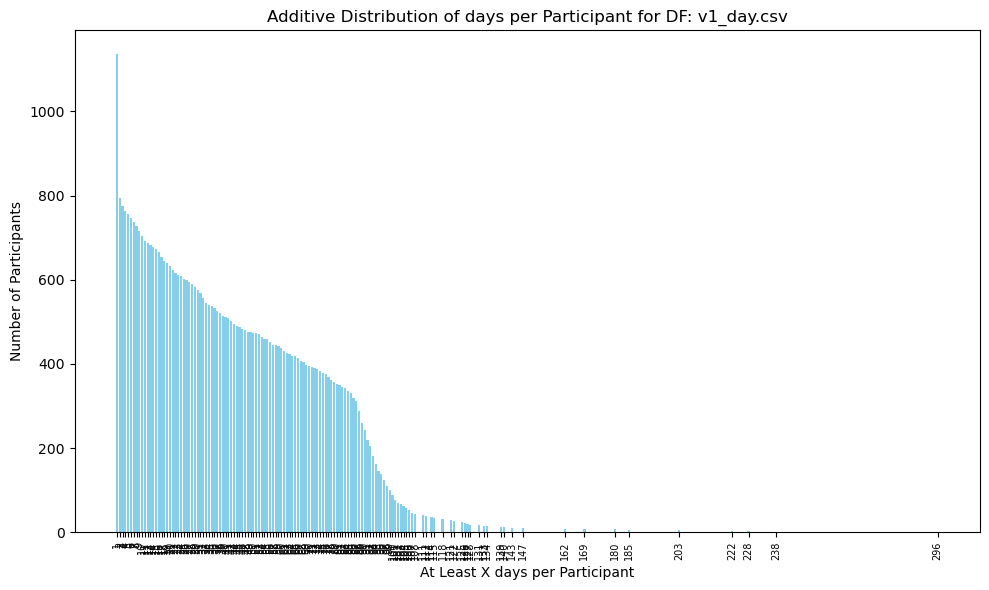

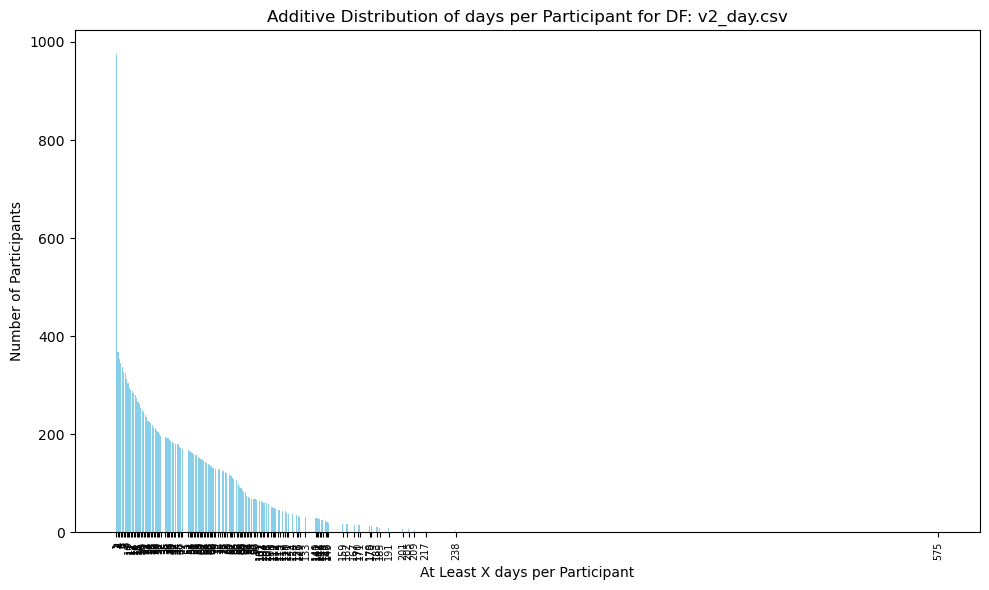

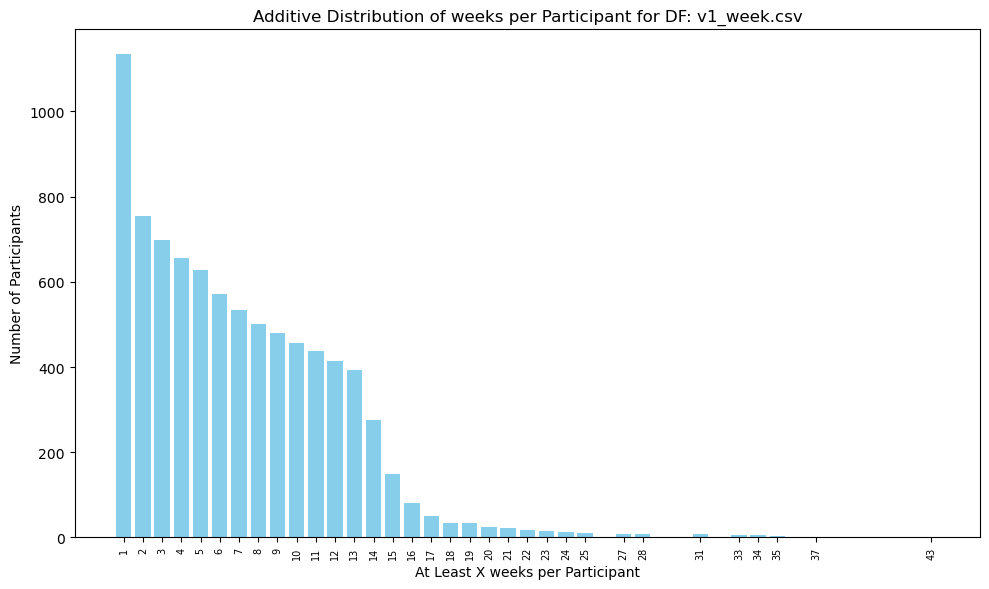

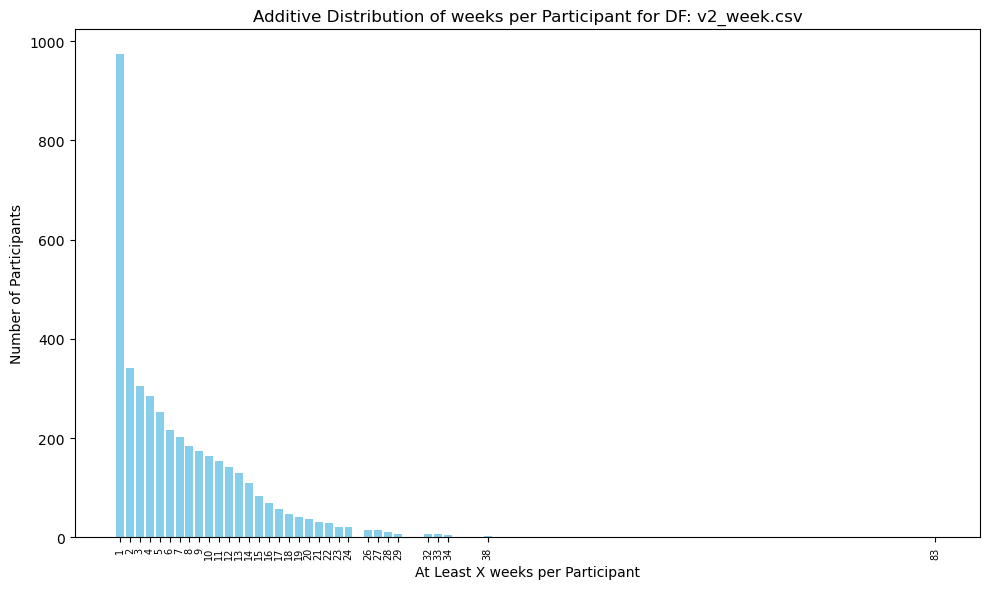

In [311]:
############## Plot-- how many weeks/days does each participant have #############
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}.csv'))
    if 'day' in name:
        time_period='day'
    elif 'week' in name:
         time_period='week'

    vis.plot_participants_per_time(df, time_period=time_period, title=f'{name}.csv')


### Plot scaling and removal of outliers 


This is the raw data


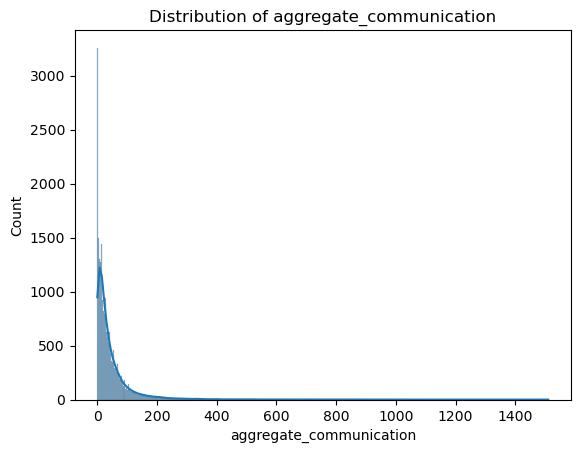

This is the lesioned data- it should have less outliers


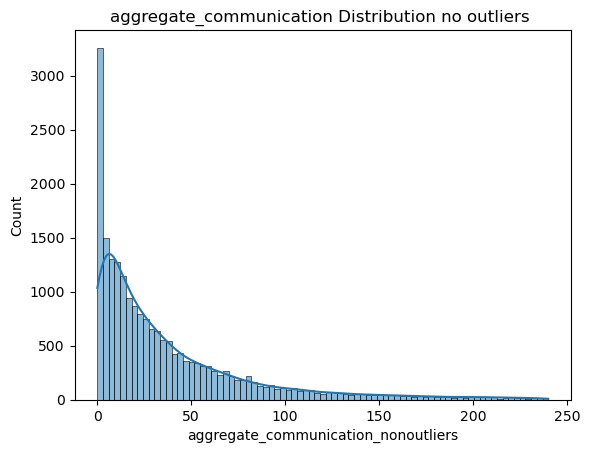

Scaled data for same subject in  original dataframe-- should look exaclty like above with different scale


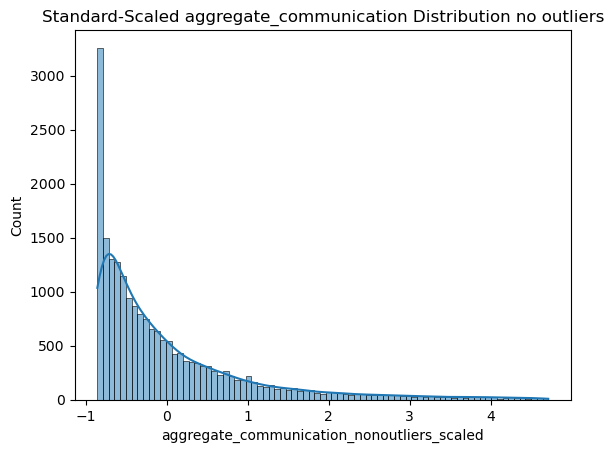

More lesioned data but in new  dataframe-- should look exactly like above


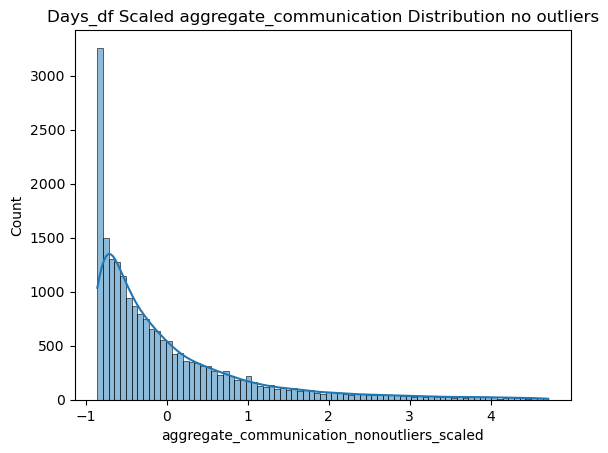

In [312]:
v1_day_dem = pd.read_csv(os.path.join(brighten_dir, f'v1_day.csv'))

pre.plot_normalization(v1_day_dem, daily_cols_v1 + phq2_cols, num_to_plot=1, subject_to_plot=None)


### Remove outliers

In [212]:
id_columns

['num_id', 'dt', 'week', 'day', 'idx']

In [313]:
##### Remove outliers ######
# Remove outliers for DFs
dfs_nonO= {}
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}.csv'))
    cols_to_scale = [col for col in df.columns.to_list() if (col not in id_columns)]
    dfs_nonO[name] = pre.remove_outliers(df, cols_to_scale)
    dfs_nonO[name].to_csv(os.path.join(brighten_dir, f'{name}_nonO.csv'), index=False)
    display(dfs_nonO[name].describe())

    print(f'Saved dfs_nonoutliers[{name}] to {name}_nonO.csv')


,num_id,week,day,aggregate_communication,call_count,call_duration,interaction_diversity,missed_interactions,mobility,mobility_radius,sms_count,sms_length,unreturned_calls,phq2_1,phq2_2,phq2_sum
count,49674.000000,49674.000000,49674.000000,21264.000000,21264.000000,21264.000000,21264.000000,21264.000000,27870.000000,27867.000000,21264.000000,21264.000000,17996.000000,36389.000000,36388.000000,36388.000000
mean,1363.885916,6.272960,46.830696,43.801872,5.604214,1403.955841,6.022620,1.290867,1.606804,16.639404,38.158155,1869.054082,0.867582,2.201936,2.197995,4.399936
std,662.771697,5.160481,36.167664,66.324596,7.626415,2778.273493,4.883066,2.288384,1.629422,114.081311,64.680137,3105.923396,1.600352,1.170867,1.195839,2.258650
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000
25%,1251.000000,2.000000,19.000000,8.000000,1.000000,34.000000,3.000000,0.000000,0.430000,1.123000,4.000000,221.000000,0.000000,1.000000,1.000000,2.000000
50%,1555.000000,5.000000,41.000000,23.000000,3.000000,399.000000,5.000000,1.000000,1.185000,3.767000,17.000000,858.000000,0.000000,2.000000,2.000000,4.000000
75%,1873.000000,9.000000,69.000000,53.000000,7.000000,1562.000000,8.000000,2.000000,2.255000,8.318000,45.000000,2203.000000,1.000000,3.000000,3.000000,6.000000
max,2110.000000,42.000000,295.000000,1510.000000,97.000000,58334.000000,52.000000,76.000000,20.430000,7012.502000,1507.000000,47741.000000,27.000000,5.000000,5.000000,10.000000


Saved dfs_nonoutliers[v1_day] to v1_day_nonO.csv


,num_id,week,day,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,hours_stationary_hr,hours_stationary_nhw_hr,hours_walking_hr,location_variance_hr,callDuration_incoming,callCount_missed,callCount_outgoing,callCount_incoming,callDuration_outgoing,textCount,textCount_received,textCount_sent,textLength_received,textLength_sent,uniqueNumbers_calls_incoming,uniqueNumbers_calls_missed,uniqueNumbers_calls_outgoing,uniqueNumbers_texts,uniqueNumbers_texts_received,uniqueNumbers_texts_sent,cloud_cover_mean,dew_point_mean,humidity_mean,temp_mean,dew_point_IQR,humidity_IQR,temp_IQR,cloud_cover_IQR,cloud_cover_std,dew_point_std,humidity_std,temp_std,cloud_cover_median,dew_point_median,humidity_median,temp_median,precip_sum,phq2_1,phq2_2,phq2_sum
count,21433.000000,21433.000000,21433.000000,12157.000000,12157.000000,12157.000000,12157.000000,12157.000000,12157.000000,1.215700e+04,12157.000000,12157.000000,12157.000000,12157.000000,12152.000000,1790.000000,1790.0,1790.0,1790.0,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.00000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,1790.000000,17475.000000,17477.000000,17477.000000,17477.000000,17477.000000,17477.000000,17477.000000,17475.000000,17475.000000,17477.000000,17477.000000,17477.000000,17475.000000,17477.000000,17477.000000,17477.000000,17474.000000,8331.000000,8324.000000,8321.000000
mean,687.397098,8.768021,64.227453,231.214555,0.079124,883.614896,4541.191523,0.004393,0.493814,2.177878e+03,0.083336,1.678333,1.037866,0.064180,-0.334610,490.893296,0.0,0.0,0.0,900.651955,0.022905,19.491620,15.556983,1085.637430,849.22067,1.272626,1.248045,2.646369,0.022346,3.459777,2.632402,0.461264,40.080675,0.696844,51.120046,4.077300,0.149468,7.969049,0.256036,0.184314,2.603284,0.088628,4.695241,0.469862,40.383587,0.708985,51.103892,0.063143,2.368715,2.534172,4.903403
std,359.302774,9.209991,64.580130,364.851631,0.098962,959.533155,8958.032945,0.056611,0.657471,2.676504e+04,0.111018,0.741414,0.861446,0.116578,0.247718,1043.736676,0.0,0.0,0.0,1464.516883,0.156936,30.218169,26.047316,1806.200335,1540.98457,1.665243,2.108551,2.983947,0.151582,2.713711,2.570213,0.343596,17.999186,0.170986,18.057361,3.812558,0.105613,5.631412,0.271205,0.136108,2.093348,0.053137,2.911880,0.401773,18.136713,0.178907,17.768493,0.189946,1.212410,1.219689,2.263884
min,207.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-4.497000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-23.350000,0.110000,-15.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-22.980000,0.120000,-15.600000,0.000000,1.000000,1.000000,2.000000
25%,399.000000,3.000000,23.000000,0.000000,0.019500,209.600000,159.316667,0.000000,0.016700,0.000000e+00,0.004882,1.034818,0.300000,0.000000,-0.429350,0.000000,0.0,0.0,0.0,0.000000,0.000000,2.000000,1.000000,135.250000,11.00000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.130000,27.670000,0.605000,38.150000,1.590000,0.060000,3.340000,0.000000,0.060000,1.230000,0.050000,2.430000,0.040000,27.820000,0.610000,38.270000,0.000000,1.000000,2.000000,3.000000
50%,666.000000,7.000000,50.000000,124.122222,0.057500,645.380000,2063.770588,0.000000,0.215095,0.000000e+00,0.052429,1.545286,0.886929,0.033316,-0.289850,41.000000,0.0,0.0,0.0,274.500000,0.000000,8.500000,6.000000,472.500000,276.00000,1.000000,0.000000,2.000000,0.000000,3.000000,2.000000,0.440000,40.750000,0.730000,52.150000,2.890000,0.130000,7.040000,0.180000,0.180000,2.040000,0.090000,4.410000,0.430000,41.090000,0.750000,52.250000,0.000000,2.000000,2.000000,4.000000
75%,896.000000,12.000000,86.000000,312.500000,0.110714,1254.927273,5602.744444,0.000000,0.711167,0.000000e+00,0.12

Saved dfs_nonoutliers[v2_day] to v2_day_nonO.csv


,num_id,week,day,aggregate_communication,call_count,call_duration,interaction_diversity,missed_interactions,mobility,mobility_radius,sms_count,sms_length,unreturned_calls,phq2_1,phq2_2,phq2_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_bin
count,8469.000000,8469.000000,8469.000000,3294.000000,3294.000000,3294.000000,3294.000000,3294.000000,5091.000000,5091.000000,3294.000000,3294.000000,3218.000000,7012.000000,7012.000000,7012.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000,3661.000000
mean,1366.426024,6.180541,45.984138,43.339953,5.562431,1415.165171,5.971184,1.292001,1.483222,15.371669,37.738554,1849.828183,0.814499,2.232905,2.228899,4.462018,1.098197,1.163070,1.310025,1.422972,1.118547,0.969407,0.966129,0.398525,0.319312,8.869435,0.389921
std,653.753091,5.387499,37.787390,56.567790,6.198003,2267.556684,4.022379,1.633204,1.199139,50.303608,55.119228,2587.245503,1.049978,0.982582,0.991538,1.921503,0.759808,0.796791,0.980566,0.916348,0.984102,0.910784,0.907964,0.713081,0.673001,5.520060,0.487729
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1263.000000,2.000000,17.000000,12.000000,1.571429,245.857143,3.142857,0.285714,0.645542,2.327857,7.714286,426.357143,0.166667,1.400000,1.333333,2.833333,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
50%,1556.000000,5.000000,38.000000,26.342857,3.714286,736.285714,5.285714,0.857143,1.249000,4.998714,20.857143,1110.071429,0.500000,2.000000,2.000000,4.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,8.000000,0.000000
75%,1851.000000,10.000000,71.000000,52.000000,7.000000,1579.428571,7.857143,1.714286,1.998190,10.097429,45.000000,2210.517857,1.000000,3.000000,3.000000,5.800000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,12.000000,1.000000
max,2110.000000,42.000000,294.500000,718.571429,70.142857,53533.000000,26.800000,26.571429,15.506800,1003.539714,712.571429,30460.285714,11.285714,5.000000,5.000000,10.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,27.000000,1.000000


Saved dfs_nonoutliers[v1_week] to v1_week_nonO.csv


,num_id,week,day,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,hours_stationary_hr,hours_stationary_nhw_hr,hours_walking_hr,location_variance_hr,callDuration_incoming,callCount_missed,callCount_outgoing,callCount_incoming,callDuration_outgoing,textCount,textCount_received,textCount_sent,textLength_received,textLength_sent,uniqueNumbers_calls_incoming,uniqueNumbers_calls_missed,uniqueNumbers_calls_outgoing,uniqueNumbers_texts,uniqueNumbers_texts_received,uniqueNumbers_texts_sent,cloud_cover_mean,dew_point_mean,humidity_mean,temp_mean,dew_point_IQR,humidity_IQR,temp_IQR,cloud_cover_IQR,cloud_cover_std,dew_point_std,humidity_std,temp_std,cloud_cover_median,dew_point_median,humidity_median,temp_median,precip_sum,phq2_1,phq2_2,phq2_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_bin
count,4239.000000,4239.000000,4239.000000,2686.000000,2686.000000,2686.000000,2686.000000,2686.000000,2686.000000,2686.000000,2686.000000,2686.000000,2686.000000,2686.000000,2686.000000,307.000000,307.0,307.0,307.0,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2262.000000,2260.000000,2260.000000,1166.000000,1165.000000,1163.000000,1163.000000,1163.000000,1162.000000,1160.000000,1159.000000,1158.000000,1166.000000,1166.000000
mean,677.284973,7.195093,52.723492,236.321707,0.080725,894.399215,4611.491166,0.004867,0.560483,2305.997709,0.086101,1.727523,1.093879,0.066603,-0.357560,465.646619,0.0,0.0,0.0,848.096401,0.022708,18.107887,14.512223,995.041019,781.702769,1.202001,1.133101,2.510803,0.022243,3.217008,2.435024,0.452675,40.649379,0.694105,51.835993,4.044254,0.151450,8.060304,0.257056,0.184079,2.583485,0.089482,4.738353,0.459819,40.944527,0.705965,51.804175,0.061825,2.410623,2.573094,4.984765,1.412417,1.446853,1.717744,1.785734,1.355635,1.398158,1.269373,0.741099,0.549655,11.643375,0.564111
std,342.506403,8.869587,62.481683,273.076581,0.084170,724.444604,6339.208628,0.042122,0.473250,17483.594060,0.093996,0.547715,0.692300,0.099727,0.190287,651.705751,0.0,0.0,0.0,1045.595837,0.090459,25.692514,21.517257,1457.612625,1210.680513,1.189434,1.595429,2.262193,0.088715,2.357647,2.218965,0.237574,16.680082,0.138962,17.207797,2.092487,0.067831,3.784753,0.139434,0.071699,1.192753,0.033931,1.973576,0.268939,16.700010,0.144424,16.858040,0.105230,1.055059,1.050063,1.985650,0.877574,0.885789,1.030684,0.924390,1.082384,1.039027,0.986850,0.911565,0.860340,6.119730,0.494811
min,207.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090250,0.000000,0.000000,-2.165938,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.652857,0.180000,-2.558571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.838571,0.170000,-1.918571,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,396.000000,1.000000,10.000000,79.190357,0.035084,394.252593,949.721790,0.000000,0.207767,0.000000,0.025707,1.311447,0.559740,0.020997,-0.435680,27.642857,0.0,0.0,0.0,149.128571,0.000000,2.464286,1.000000,172.928571,42.273810,0.285714,0.166667,0.928571,0.000000,1.166667,0.571429,0.274286,29.014762,0.630000,39.007143,2.559286,0.102250,5.177143,0.164286,0.138571,1.730714,0.065714,3.258333,0.250000,29.355357,0.641548,39.065357,0.000000,1.600000,1.857143,3.500000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,7.000000,0.000000
50%,654.000000,5.000000,38.0000

Saved dfs_nonoutliers[v2_week] to v2_week_nonO.csv


## Distribution Checks

### Investigate distribution/skew for each variable
This can mean there is asymmetry and more transformation is needed, as many of our later models expect normal distributions. 

In [314]:
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_nonO.csv'))
    print(f'\n\nFor {name}:')
    numeric_cols = [col for col in df.columns.to_list() if col not in id_columns and col not in demographic_columns]
    print('\nInvestigating skew:')
    print(df[numeric_cols].skew(numeric_only=True).sort_values(ascending=False)) # sort by highest, display    



For v1_day:

Investigating skew:
mobility_radius            21.994245
missed_interactions         6.382535
call_duration               5.532079
sms_count                   4.903981
aggregate_communication     4.707835
sms_length                  4.570134
unreturned_calls            4.154087
call_count                  3.007549
mobility                    2.097219
interaction_diversity       1.687732
phq2_2                      0.739492
phq2_1                      0.714529
phq2_sum                    0.713306
dtype: float64


For v2_day:

Investigating skew:
hours_high_speed_transportation_hr       20.672174
distance_high_speed_transportation_hr    17.253940
distance_powered_vehicle_hr              11.327903
hours_walking_hr                          9.380788
hours_active_hr                           8.987181
textCount                                 7.231919
uniqueNumbers_texts                       6.944782
distance_walking_hr                       6.753428
precip_sum                

### Investigate for Kurtosis
Excessive kurtosis can create model variance issues

In [315]:
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_nonO.csv'))
    print(f'\n\nFor {name}:')
    numeric_cols = [col for col in df.columns.to_list() if col not in id_columns and col not in demographic_columns]
    print('\nInvestigating Kurtosis:')
    # Calculate kurtosis for numeric columns
    kurtosis_vals = df[numeric_cols].kurtosis(numeric_only=True)
    kurtosis_sorted = kurtosis_vals.sort_values(ascending=False) # Sort by highest kurtosis
    print(kurtosis_sorted) #display




For v1_day:

Investigating Kurtosis:
mobility_radius            791.454246
missed_interactions        115.469669
call_duration               55.234078
sms_count                   44.224213
aggregate_communication     41.483409
sms_length                  33.318216
unreturned_calls            29.129648
call_count                  14.055317
mobility                     7.967203
interaction_diversity        5.179964
phq2_sum                    -0.368561
phq2_1                      -0.417484
phq2_2                      -0.421916
dtype: float64


For v2_day:

Investigating Kurtosis:
hours_high_speed_transportation_hr       625.016189
distance_high_speed_transportation_hr    387.846819
distance_powered_vehicle_hr              309.818148
hours_active_hr                          207.721031
hours_walking_hr                         159.611548
distance_walking_hr                       99.413147
textCount                                 56.433110
uniqueNumbers_texts                       50.1242

### Some columns we can assume 0 values are actually NaN
For example, hours_of_sleep at at 0 actually probably indicates that the sensor wasn't picking up at that time or it was inaccurate. Same goes for hours_walking or distance_walking, since it doesn't make sense for someone to not move at all during the day. If they have very small amounts of walking/activity, that can stay, but a pure 0 means the sensor wasn't active. 

Additionally, columns like hours_powered_vehicle, activity scores, and 



In [316]:
#We'll change these columns 0s to NaN
set_some_to_NaN = ['mobility_radius', 'mobility']

for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_nonO.csv'))
    df_setNaN = df.copy()
    for col in set_some_to_NaN:
        if col in df_setNaN.columns:
            if col in ["mobility_radius","mobility"]:
                df[col] = df[col].mask(df[col] < 0.1) # measured in miles. This is ~300ft. not likely for someone to walk less than that in a day.
            
            df_setNaN[col] = df_setNaN[col].replace(0, np.nan)
    
    df_setNaN.to_csv(os.path.join(brighten_dir, f'{name}_setNaN.csv'), index=False)
    print(f"Created {name}_setNaN in brighten_dir")


Created v1_day_setNaN in brighten_dir
Created v2_day_setNaN in brighten_dir
Created v1_week_setNaN in brighten_dir
Created v2_week_setNaN in brighten_dir


In [150]:
# for name in df_names:
#     df = pd.read_csv(os.path.join(brighten_dir, f'{name}_setNaN.csv'))
#     print(f'\n\nFor {name}:')
#     numeric_cols = [col for col in df.columns.to_list() if col not in id_columns and col not in demographic_columns]
#     for col in numeric_cols:
#         # Display each col as a histogram, to check for multimodal distribution
#         plt.figure(figsize=(2,1))
#         sns.histplot(df[col], bins=100)
#         plt.show()



In [317]:
##### Transform data with log transform ###
dfs_transformed= {}

for name in df_list:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_setNaN.csv'))
    cols_to_scale = [col for col in df.columns.to_list() if (col not in id_columns and col not in target_vars)]
    dfs_transformed[name] = pre.apply_log_transform(df, cols_to_scale)
    dfs_transformed[name].to_csv(os.path.join(brighten_dir, f'{name}_transformed.csv'), index=False)
    print(f'Saved dfs_transformed[{name}] to {name}_transformed.csv')


Saved dfs_transformed[v1_day] to v1_day_transformed.csv
Column 'location_variance_hr' has negative values, log transform not safe.
Column 'dew_point_mean' has negative values, log transform not safe.
Column 'temp_mean' has negative values, log transform not safe.
Column 'dew_point_median' has negative values, log transform not safe.
Column 'temp_median' has negative values, log transform not safe.
Saved dfs_transformed[v2_day] to v2_day_transformed.csv
Saved dfs_transformed[v1_week] to v1_week_transformed.csv
Column 'location_variance_hr' has negative values, log transform not safe.
Column 'dew_point_mean' has negative values, log transform not safe.
Column 'temp_mean' has negative values, log transform not safe.
Column 'dew_point_median' has negative values, log transform not safe.
Column 'temp_median' has negative values, log transform not safe.
Saved dfs_transformed[v2_week] to v2_week_transformed.csv


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_55646/3755218850.py:5: DtypeWarning: Columns (3,9,34,35,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{name}_setNaN.csv'))


Column 'mhs_1' has negative values, log transform not safe.
Column 'mhs_2' has negative values, log transform not safe.
Column 'mhs_3' has negative values, log transform not safe.
Column 'mhs_4' has negative values, log transform not safe.
Column 'mhs_5' has negative values, log transform not safe.
Column 'location_variance' has negative values, log transform not safe.
Column 'location_variance_avg' has negative values, log transform not safe.
Column 'dew_point_mean' has negative values, log transform not safe.
Column 'temp_mean' has negative values, log transform not safe.
Column 'dew_point_median' has negative values, log transform not safe.
Column 'temp_median' has negative values, log transform not safe.
Saved dfs_transformed[alldays_df] to alldays_df_transformed.csv
Column 'mhs_1' has negative values, log transform not safe.
Column 'mhs_2' has negative values, log transform not safe.
Column 'mhs_3' has negative values, log transform not safe.
Column 'mhs_4' has negative values, lo

/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_55646/3755218850.py:5: DtypeWarning: Columns (10,36,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(brighten_dir, f'{name}_setNaN.csv'))


Saved dfs_transformed[week_df] to week_df_transformed.csv


#### Trying skew/kurtosis again

In [318]:

for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_transformed.csv'))
    print(f'\n\nFor {name}:')
    numeric_cols = [col for col in df.columns.to_list() if col not in id_columns and col not in demographic_columns]
    skew_list = df[numeric_cols].skew(numeric_only=True).sort_values(ascending=False) # sort by highest, display    
    if len(skew_list[skew_list > 1])>0:
        print('These measures have skew > 1:')
        print(skew_list[skew_list > 1])

for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_transformed.csv'))
    print(f'\n\nFor {name}:')
    numeric_cols = [col for col in df.columns.to_list() if col not in id_columns and col not in demographic_columns]
    
    # Calculate kurtosis for numeric columns
    kurtosis_vals = df[numeric_cols].kurtosis(numeric_only=True)
    kurtosis_sorted = kurtosis_vals.sort_values(ascending=False) # Sort by highest kurtosis
    
    if len(kurtosis_sorted[kurtosis_sorted > 2])>0:
        print('These columns have Kurtosis > 2:')
        print(kurtosis_sorted[kurtosis_sorted > 2]) #display

    if len(kurtosis_sorted[kurtosis_sorted.isna()])>0:
        print('These columns have NaN in Kurtosis:')
        print(kurtosis_sorted[kurtosis_sorted.isna()]) #display

    # More investigation into kurtosis NaN values
    for col in kurtosis_sorted[kurtosis_sorted.isna()].index:
        print(f'Kurtosis is NaN for {col}:')
        if col in df.columns:
            print('Unique values:', df[col].nunique())      # Unique values
            print("Missing values:", df[col].isna().sum())   # Missing values
            print("Variance:", df[col].var())     # Summary stats



For v1_day:
These measures have skew > 1:
unreturned_calls    1.192028
mobility_radius     1.107113
dtype: float64


For v2_day:
These measures have skew > 1:
hours_high_speed_transportation_hr       15.310957
textCount                                 6.771994
uniqueNumbers_texts                       6.674166
hours_walking_hr                          4.681977
distance_high_speed_transportation_hr     4.483483
precip_sum                                3.936249
hours_active_hr                           3.352952
hours_powered_vehicle_hr                  2.499546
hours_of_sleep_hr                         1.123095
uniqueNumbers_calls_missed                1.040012
dtype: float64


For v1_week:
These measures have skew > 1:
phq9_9              2.320827
phq9_8              1.889012
unreturned_calls    1.139460
mobility_radius     1.044515
dtype: float64


For v2_week:
These measures have skew > 1:
hours_high_speed_transportation_hr       13.146461
hours_walking_hr                          


Still very skewed, let's limit our ML pipelines to those which don't need normal data distributions, such as tree-based models (Random Forest, XGBoost, LightGBM, CatBoost).

### Remove too-skewed variables

We find that some sensor variables (for example unreturned calls, hours walking, hours powered vehicle), and some survey variables (for example phq9_8, phq9_9) are still quite skewed. Additionally, some variables are highly 2-tailed (for example hours_stationary), while some variables are only moderately 2-tailed (for example sms_length).

If we want to do normal-distribution analysis, such as logistic regression or PCA, we'd remove the skewed and highly 2-tailed variables, keeping the moderately 2-tailed variables. 

However, for now we'll keep them in and stick to tree models. 

In [153]:
# aggregate_dfs = ['alldays_df','week_df']
# df_list = df_names + aggregate_dfs
# all_skewed_cols = ['unreturned_calls','sms_length','precip_sum', 'hours_stationary_nhw_hr','hours_stationary_hr','dew_point_mean','dew_point_median', 'hours_of_sleep_hr','textCount_sent','hours_active_hr','phq9_9', 'phq9_8','sms_length','call_duration','dew_point_median','callDuration_outgoing','dew_point_mean','temp_mean','phq9_sum','temp_median','distance_walking_avg','distance_active_avg','phq9_bin','callDuration_incoming']

# for name in df_list:
#     df = pd.read_csv(os.path.join(brighten_dir, f'{name}_transformed.csv'))
#     df_unskewed = df.copy()
#     if name == "v1_day":
#         df_unskewed = df_unskewed.drop(columns=['unreturned_calls','sms_length'])
#     if name == "v2_day":
#         df_unskewed = df_unskewed.drop(columns=['precip_sum', 'hours_stationary_nhw_hr','hours_stationary_hr','dew_point_mean','dew_point_median', 'hours_of_sleep_hr','textCount_sent','hours_active_hr'])
#     if name == "v1_week":
#         df_unskewed = df_unskewed.drop(columns=['phq9_9', 'phq9_8','sms_length','call_duration'])
#     if name == "v2_week":
#         df_unskewed = df_unskewed.drop(columns=['dew_point_median','callDuration_outgoing','dew_point_mean','temp_mean','phq9_sum','temp_median','distance_walking_hr','distance_active_hr','phq9_bin','callDuration_incoming'])
#     if name in aggregate_dfs:
#         df_unskewed = df_unskewed.drop(columns=[col for col in all_skewed_cols if col in df.columns])
#     if 'Unnamed: 0' in df_unskewed.columns:
#         df_unskewed = df_unskewed.drop(columns=['Unnamed: 0'])
#     df_unskewed.to_csv(os.path.join(brighten_dir, f'{name}_unskewed.csv'))
#     print(f'Saved {name}_unskewed to brighten_dir')


### Scale Data
Scale the data so we can see distributions no matter the size of the variance

In [319]:
##### Scale data ######
dfs_scaled= {}
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_nonO.csv'))
    cols_to_scale = [col for col in df.columns.to_list() if (col not in id_columns and col not in target_vars)]
    dfs_scaled[name] = pre.normalize_df(df, cols_to_scale)
    if 'Unnamed: 0' in dfs_scaled[name].columns:
        dfs_scaled[name] = dfs_scaled[name].drop(columns=['Unnamed: 0'])
    dfs_scaled[name].to_csv(os.path.join(brighten_dir, f'{name}_scaled.csv'), index=False)
    print(f'Saved dfs_scaled[{name}] to {name}_scaled.csv')

Saved dfs_scaled[v1_day] to v1_day_scaled.csv
Saved dfs_scaled[v2_day] to v2_day_scaled.csv
Saved dfs_scaled[v1_week] to v1_week_scaled.csv
Saved dfs_scaled[v2_week] to v2_week_scaled.csv


### Investigate Distributions
Check for multimodal distributions, which can throw off train/test splits.
We can make the histograms quite small, as we only need to see the rough distribution.



For v1_day:


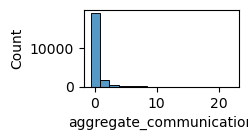

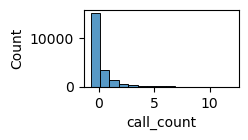

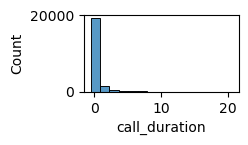

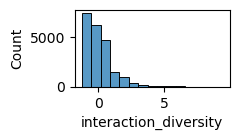

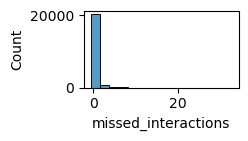

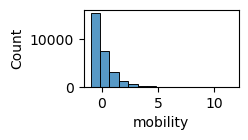

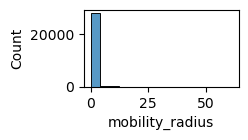

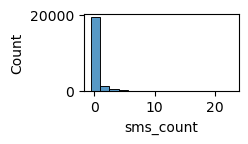

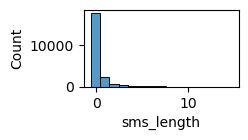

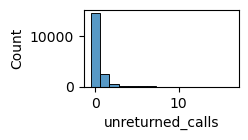

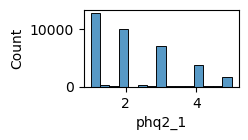

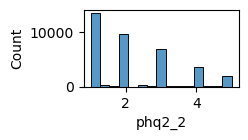

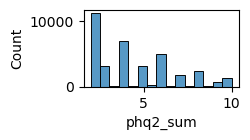



For v2_day:


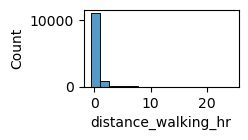

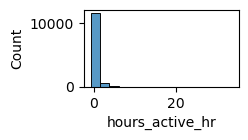

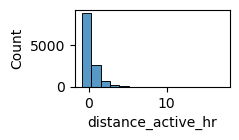

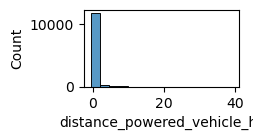

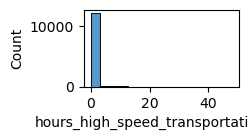

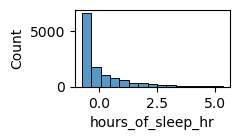

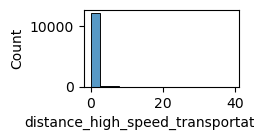

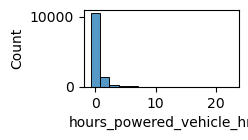

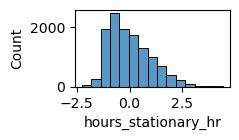

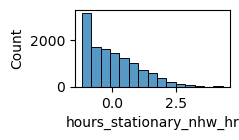

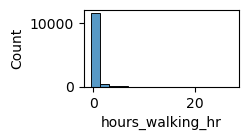

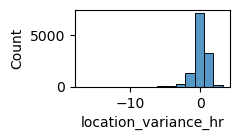

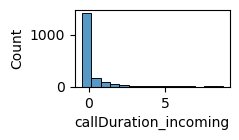

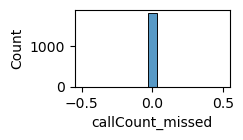

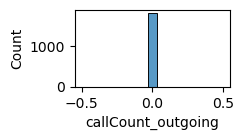

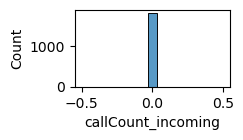

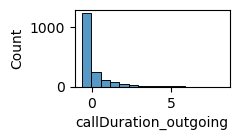

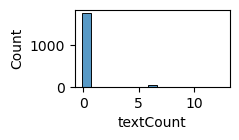

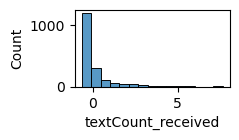

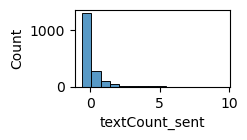

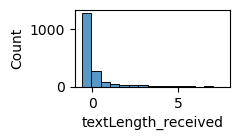

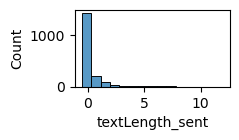

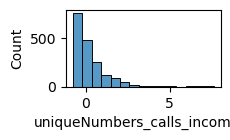

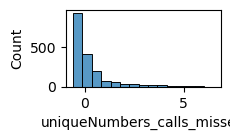

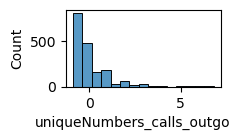

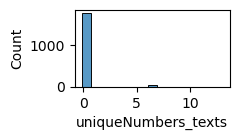

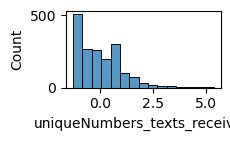

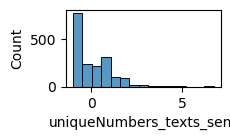

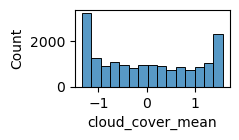

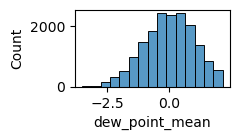

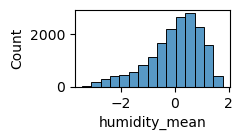

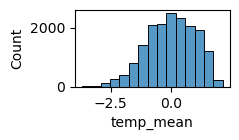

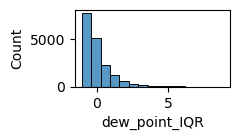

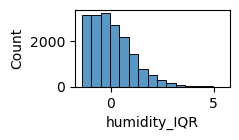

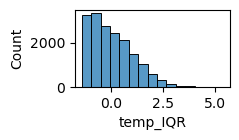

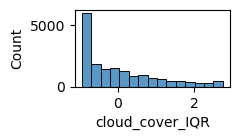

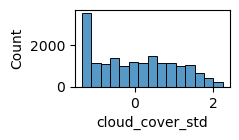

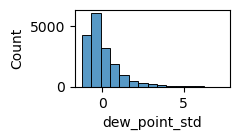

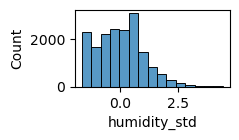

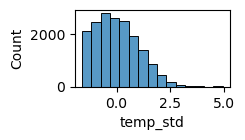

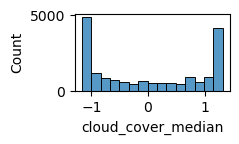

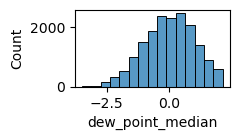

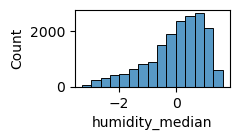

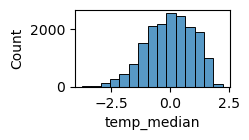

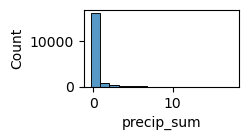

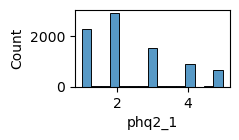

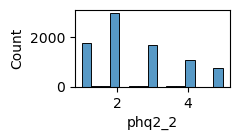

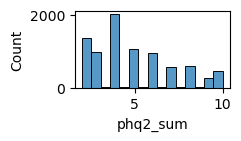



For v1_week:


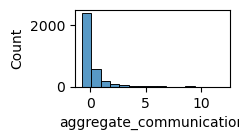

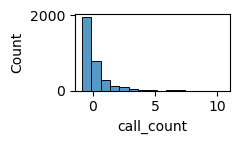

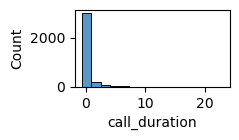

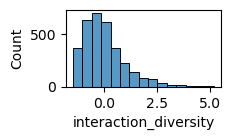

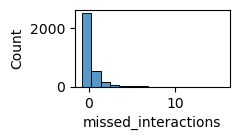

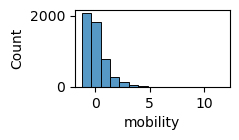

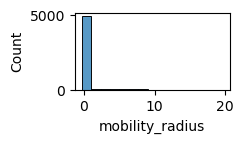

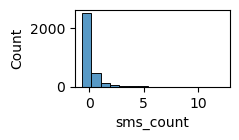

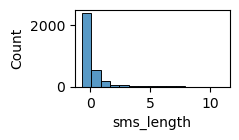

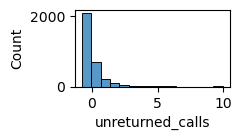

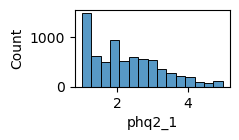

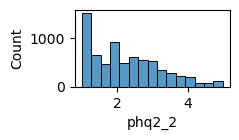

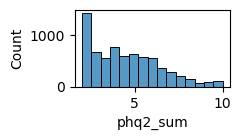

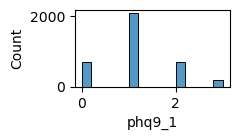

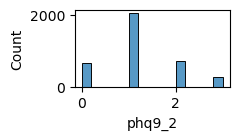

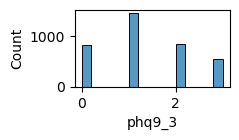

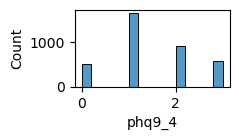

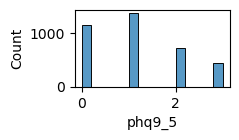

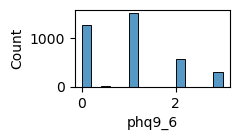

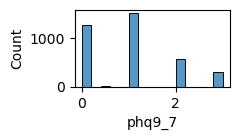

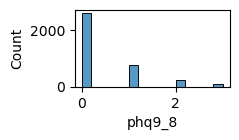

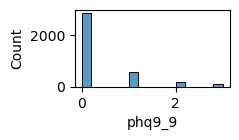

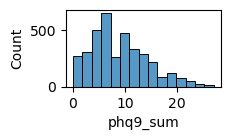

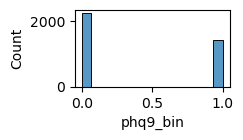



For v2_week:


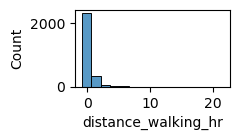

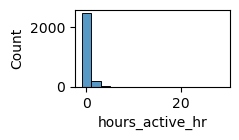

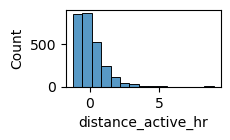

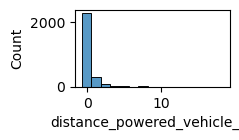

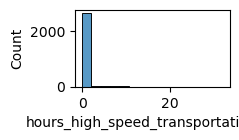

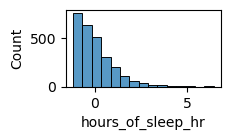

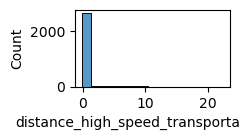

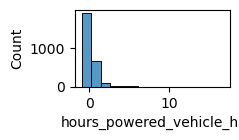

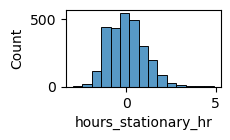

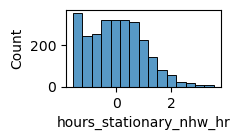

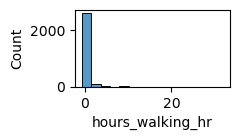

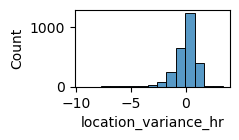

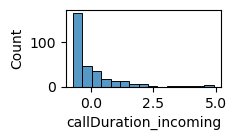

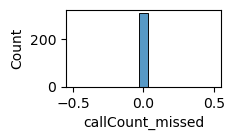

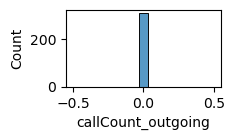

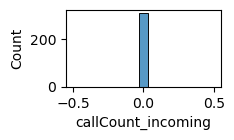

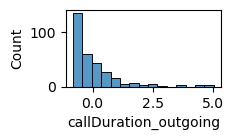

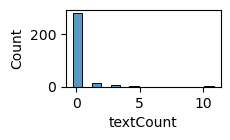

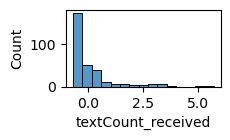

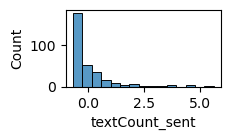

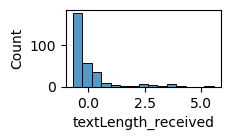

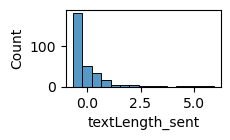

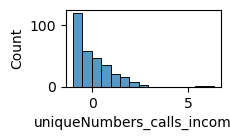

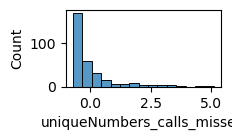

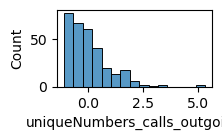

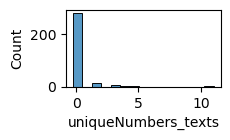

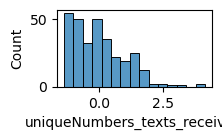

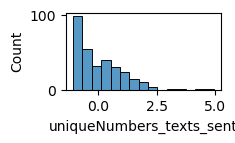

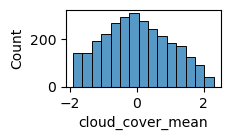

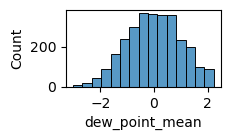

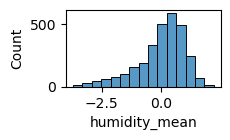

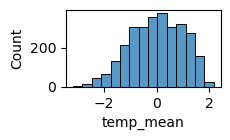

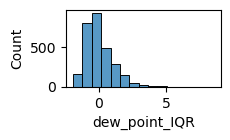

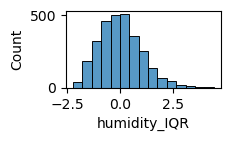

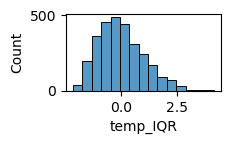

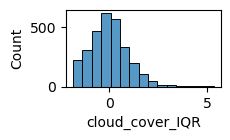

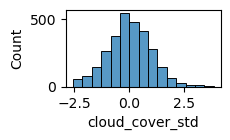

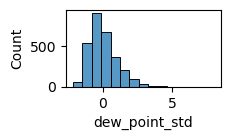

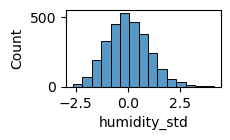

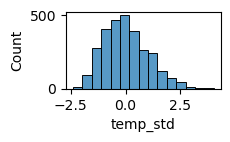

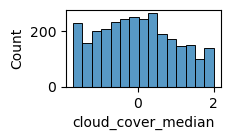

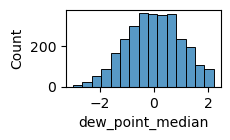

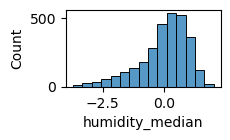

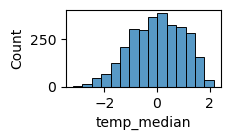

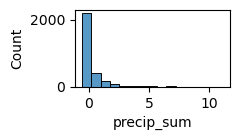

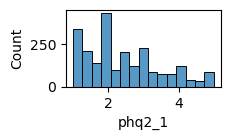

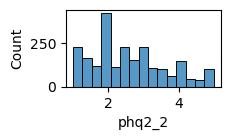

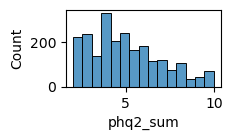

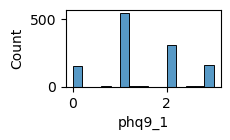

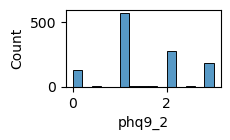

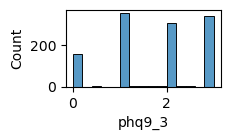

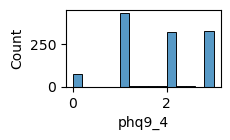

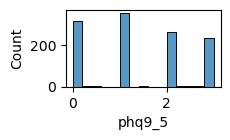

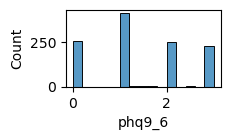

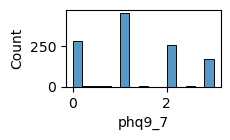

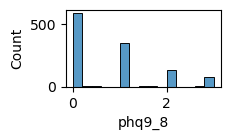

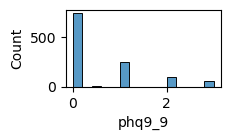

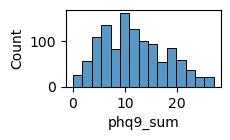

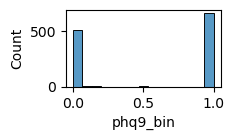

In [320]:
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_scaled.csv'))
    print(f'\n\nFor {name}:')
    numeric_cols = [col for col in df.columns.to_list() if col not in id_columns and col not in demographic_columns]
    for col in numeric_cols:
        if 'Unnamed' not in col:
            # Display each col as a histogram, to check for multimodal distribution
            plt.figure(figsize=(2,1))
            sns.histplot(df[col], bins=15)
            plt.show()


### It seems there are many columns with little to no variance, let's investigate and drop those columns.

In [321]:
problem_cols = {}
for name in df_names:
    scaled_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_scaled.csv'))
    problem_cols[name] = []
    numeric_cols = [col for col in scaled_df.columns.to_list() if col not in id_columns and col not in demographic_columns]
    for col in numeric_cols:
        if col in scaled_df.columns:
            if (scaled_df[col].nunique() < 4) or (scaled_df[col].var() < .05):
                print(f"{name}: {col}")
                #print("nunique:", scaled_df[col].nunique()) # number unique
                #print("Variance:", scaled_df[col].var())     # Variance
                problem_cols[name].append(col)



v2_day: callCount_missed
v2_day: callCount_outgoing
v2_day: callCount_incoming
v2_day: textCount
v2_day: uniqueNumbers_texts
v1_week: phq9_bin
v2_week: callCount_missed
v2_week: callCount_outgoing
v2_week: callCount_incoming


### Reduce missingness
Let's try to reduce the number of columns by also dropping any with large missingness.

In [322]:
missing = {}
pd.set_option('display.max_columns', None) # Show all columns
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_scaled.csv'))
    df =  df.loc[:, ~df.columns.str.contains('^Unnamed')]  
    for col in df.columns:
        na = df[col].isna().sum()
        # Store results in a DataFrame
        missing[col] = {
            'num_missing': [na],
            'perc_missing': [na / len(df)]
            }
    missing_df = pd.DataFrame(missing).reset_index()
        
    display(missing_df)

,index,num_id,dt,week,day,idx,aggregate_communication,call_count,call_duration,interaction_diversity,missed_interactions,mobility,mobility_radius,sms_count,sms_length,unreturned_calls,phq2_1,phq2_2,phq2_sum
0,num_missing,[0],[0],[0],[0],[0],[28410],[28410],[28410],[28410],[28410],[21804],[21807],[28410],[28410],[31678],[13285],[13286],[13286]
1,perc_missing,[0.0],[0.0],[0.0],[0.0],[0.0],[0.5719289769295809],[0.5719289769295809],[0.5719289769295809],[0.5719289769295809],[0.5719289769295809],[0.43894190119579657],[0.4390022949631598],[0.5719289769295809],[0.5719289769295809],[0.6377179208439022],[0.2674437331400733],[0.267463864395861],[0.267463864395861]


,index,num_id,dt,week,day,idx,aggregate_communication,call_count,call_duration,interaction_diversity,missed_interactions,mobility,mobility_radius,sms_count,sms_length,unreturned_calls,phq2_1,phq2_2,phq2_sum,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,hours_stationary_hr,hours_stationary_nhw_hr,hours_walking_hr,location_variance_hr,callDuration_incoming,callCount_missed,callCount_outgoing,callCount_incoming,callDuration_outgoing,textCount,textCount_received,textCount_sent,textLength_received,textLength_sent,uniqueNumbers_calls_incoming,uniqueNumbers_calls_missed,uniqueNumbers_calls_outgoing,uniqueNumbers_texts,uniqueNumbers_texts_received,uniqueNumbers_texts_sent,cloud_cover_mean,dew_point_mean,humidity_mean,temp_mean,dew_point_IQR,humidity_IQR,temp_IQR,cloud_cover_IQR,cloud_cover_std,dew_point_std,humidity_std,temp_std,cloud_cover_median,dew_point_median,humidity_median,temp_median,precip_sum
0,num_missing,[0],[0],[0],[0],[0],[28410],[28410],[28410],[28410],[28410],[21804],[21807],[28410],[28410],[31678],[13102],[13109],[13112],[9276],[9276],[9276],[9276],[9276],[9276],[9276],[9276],[9276],[9276],[9276],[9281],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[3958],[3956],[3956],[3956],[3956],[3956],[3956],[3958],[3958],[3956],[3956],[3956],[3958],[3956],[3956],[3956],[3959]
1,perc_missing,[0.0],[0.0],[0.0],[0.0],[0.0],[0.5719289769295809],[0.5719289769295809],[0.5719289769295809],[0.5719289769295809],[0.5719289769295809],[0.43894190119579657],[0.4390022949631598],[0.5719289769295809],[0.5719289769295809],[0.6377179208439022],[0.6113003312648719],[0.6116269304343769],[0.6117669015070218],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.43302384173937386],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.18466850184295244],[0.18457518779452248],[0.18457518779452248],[0.18457518779452248],[0.18457518779452248],[0.18457518779452248],[0.18457518779452248],[0.18466850184295244],[0.18466850184295244],[0.18457518779452248],[0.18457518779452248],[0.18457518779452248],[0.18466850184295244],[0.18457518779452248],[0.18457518779452248],[0.18457518779452248],[0.18471515886716744]


,index,num_id,dt,week,day,idx,aggregate_communication,call_count,call_duration,interaction_diversity,missed_interactions,mobility,mobility_radius,sms_count,sms_length,unreturned_calls,phq2_1,phq2_2,phq2_sum,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,hours_stationary_hr,hours_stationary_nhw_hr,hours_walking_hr,location_variance_hr,callDuration_incoming,callCount_missed,callCount_outgoing,callCount_incoming,callDuration_outgoing,textCount,textCount_received,textCount_sent,textLength_received,textLength_sent,uniqueNumbers_calls_incoming,uniqueNumbers_calls_missed,uniqueNumbers_calls_outgoing,uniqueNumbers_texts,uniqueNumbers_texts_received,uniqueNumbers_texts_sent,cloud_cover_mean,dew_point_mean,humidity_mean,temp_mean,dew_point_IQR,humidity_IQR,temp_IQR,cloud_cover_IQR,cloud_cover_std,dew_point_std,humidity_std,temp_std,cloud_cover_median,dew_point_median,humidity_median,temp_median,precip_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_bin
0,num_missing,[0],[0],[0],[0],[0],[5175],[5175],[5175],[5175],[5175],[3378],[3378],[5175],[5175],[5251],[1457],[1457],[1457],[9276],[9276],[9276],[9276],[9276],[9276],[9276],[9276],[9276],[9276],[9276],[9281],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[19643],[3958],[3956],[3956],[3956],[3956],[3956],[3956],[3958],[3958],[3956],[3956],[3956],[3958],[3956],[3956],[3956],[3959],[4808],[4808],[4808],[4808],[4808],[4808],[4808],[4808],[4808],[4808],[4808]
1,perc_missing,[0.0],[0.0],[0.0],[0.0],[0.0],[0.6110520722635494],[0.6110520722635494],[0.6110520722635494],[0.6110520722635494],[0.6110520722635494],[0.39886645412681543],[0.39886645412681543],[0.6110520722635494],[0.6110520722635494],[0.6200259770929272],[0.17203920179478097],[0.17203920179478097],[0.17203920179478097],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.4327905566182989],[0.43302384173937386],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.916483926655158],[0.18466850184295244],[0.18457518779452248],[0.18457518779452248],[0.18457518779452248],[0.18457518779452248],[0.18457518779452248],[0.18457518779452248],[0.18466850184295244],[0.18466850184295244],[0.18457518779452248],[0.18457518779452248],[0.18457518779452248],[0.18466850184295244],[0.18457518779452248],[0.18457518779452248],[0.18457518779452248],[0.18471515886716744],[0.5677175581532649],[0.5677175581532649],[0.5677175581532649],[0.5677175581532649],[0.5677175581532649],[0.5677175581532649],[0.5677175581532649],[0.5677175581532649],[0.5677175581532649],[0.5677175581532649],[0.5677175581532649]


,index,num_id,dt,week,day,idx,aggregate_communication,call_count,call_duration,interaction_diversity,missed_interactions,mobility,mobility_radius,sms_count,sms_length,unreturned_calls,phq2_1,phq2_2,phq2_sum,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,hours_stationary_hr,hours_stationary_nhw_hr,hours_walking_hr,location_variance_hr,callDuration_incoming,callCount_missed,callCount_outgoing,callCount_incoming,callDuration_outgoing,textCount,textCount_received,textCount_sent,textLength_received,textLength_sent,uniqueNumbers_calls_incoming,uniqueNumbers_calls_missed,uniqueNumbers_calls_outgoing,uniqueNumbers_texts,uniqueNumbers_texts_received,uniqueNumbers_texts_sent,cloud_cover_mean,dew_point_mean,humidity_mean,temp_mean,dew_point_IQR,humidity_IQR,temp_IQR,cloud_cover_IQR,cloud_cover_std,dew_point_std,humidity_std,temp_std,cloud_cover_median,dew_point_median,humidity_median,temp_median,precip_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_bin
0,num_missing,[0],[0],[0],[0],[0],[5175],[5175],[5175],[5175],[5175],[3378],[3378],[5175],[5175],[5251],[1977],[1979],[1979],[1553],[1553],[1553],[1553],[1553],[1553],[1553],[1553],[1553],[1553],[1553],[1553],[3932],[3932],[3932],[3932],[3932],[3932],[3932],[3932],[3932],[3932],[3932],[3932],[3932],[3932],[3932],[3932],[1328],[1328],[1328],[1328],[1328],[1328],[1328],[1328],[1328],[1328],[1328],[1328],[1328],[1328],[1328],[1328],[1328],[3073],[3074],[3076],[3076],[3076],[3077],[3079],[3080],[3081],[3073],[3073]
1,perc_missing,[0.0],[0.0],[0.0],[0.0],[0.0],[0.6110520722635494],[0.6110520722635494],[0.6110520722635494],[0.6110520722635494],[0.6110520722635494],[0.39886645412681543],[0.39886645412681543],[0.6110520722635494],[0.6110520722635494],[0.6200259770929272],[0.46638358103326255],[0.4668553904222694],[0.4668553904222694],[0.36635999056381224],[0.36635999056381224],[0.36635999056381224],[0.36635999056381224],[0.36635999056381224],[0.36635999056381224],[0.36635999056381224],[0.36635999056381224],[0.36635999056381224],[0.36635999056381224],[0.36635999056381224],[0.36635999056381224],[0.9275772587874499],[0.9275772587874499],[0.9275772587874499],[0.9275772587874499],[0.9275772587874499],[0.9275772587874499],[0.9275772587874499],[0.9275772587874499],[0.9275772587874499],[0.9275772587874499],[0.9275772587874499],[0.9275772587874499],[0.9275772587874499],[0.9275772587874499],[0.9275772587874499],[0.9275772587874499],[0.31328143430054256],[0.31328143430054256],[0.31328143430054256],[0.31328143430054256],[0.31328143430054256],[0.31328143430054256],[0.31328143430054256],[0.31328143430054256],[0.31328143430054256],[0.31328143430054256],[0.31328143430054256],[0.31328143430054256],[0.31328143430054256],[0.31328143430054256],[0.31328143430054256],[0.31328143430054256],[0.31328143430054256],[0.7249351262090116],[0.725171030903515],[0.7256428402925218],[0.7256428402925218],[0.7256428402925218],[0.7258787449870252],[0.7263505543760321],[0.7265864590705355],[0.726822363765039],[0.7249351262090116],[0.7249351262090116]


For the V2 phone columns, the missingness is over 90%. Let's drop those rows since they're too missing to be interpolated.

In [323]:
# Add the too-missing cols to problem_cols
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_scaled.csv'))
    display(df)
    drop_cols = [col for col in df.columns if col in daily_v2_phone]
    problem_cols[name].extend(drop_cols)


,num_id,dt,week,day,idx,aggregate_communication,call_count,call_duration,interaction_diversity,missed_interactions,mobility,mobility_radius,sms_count,sms_length,unreturned_calls,phq2_1,phq2_2,phq2_sum
0,1.0,2014-05-09,0.0,0,1.0_0,NaN,NaN,NaN,NaN,NaN,-0.326996,-0.138539,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2014-05-10,0.0,1,1.0_1,NaN,NaN,NaN,NaN,NaN,-0.283421,-0.000319,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2014-05-11,0.0,2,1.0_2,NaN,NaN,NaN,NaN,NaN,0.146801,-0.082727,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,2014-05-12,0.0,3,1.0_3,NaN,NaN,NaN,NaN,NaN,-0.986137,-0.145858,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,2014-05-13,0.0,4,1.0_4,NaN,NaN,NaN,NaN,NaN,-0.798950,-0.124864,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49669,2110.0,2015-07-31,11.0,83,2110.0_83,NaN,NaN,NaN,NaN,NaN,0.454891,-0.099268,NaN,NaN,NaN,NaN,NaN,NaN
49670,2110.0,2015-08-01,12.0,84,2110.0_84,NaN,NaN,NaN,NaN,NaN,-0.741260,-0.127993,NaN,NaN,NaN,NaN,NaN,NaN
49671,2110.0,2015-08-02,12.0,85,2110.0_85,NaN,NaN,NaN,NaN,NaN,-0.346635,-0.130027,NaN,NaN,NaN,NaN,NaN,NaN
49672,2110.0,2015-08-03,12.0,86,2110.0_86,NaN,NaN,NaN,NaN,NaN,-0.256417,-0.129273,NaN,NaN,NaN,NaN,NaN,NaN


,num_id,dt,week,day,idx,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,hours_stationary_hr,hours_stationary_nhw_hr,hours_walking_hr,location_variance_hr,callDuration_incoming,callCount_missed,callCount_outgoing,callCount_incoming,callDuration_outgoing,textCount,textCount_received,textCount_sent,textLength_received,textLength_sent,uniqueNumbers_calls_incoming,uniqueNumbers_calls_missed,uniqueNumbers_calls_outgoing,uniqueNumbers_texts,uniqueNumbers_texts_received,uniqueNumbers_texts_sent,cloud_cover_mean,dew_point_mean,humidity_mean,temp_mean,dew_point_IQR,humidity_IQR,temp_IQR,cloud_cover_IQR,cloud_cover_std,dew_point_std,humidity_std,temp_std,cloud_cover_median,dew_point_median,humidity_median,temp_median,precip_sum,phq2_1,phq2_2,phq2_sum
0,207.0,2016-08-12,0.0,0,207.0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,207.0,2016-08-13,0.0,1,207.0_1,-0.495081,-0.738023,-0.835778,0.626709,-0.050302,-0.168000,-0.061691,1.009952,-0.673760,0.163629,-0.407842,0.933544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.080553,1.995665,-0.040027,2.038560,-0.539627,1.141301,1.156218,-0.501614,-0.399065,-0.737254,0.778621,0.664455,-1.169505,1.956663,-0.217914,2.101876,-0.332436,NaN,NaN,NaN
2,207.0,2016-08-14,0.0,2,207.0_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.527563,1.840654,0.076945,1.857465,-0.460937,1.709431,1.181079,0.678339,0.482613,-0.565275,1.343216,0.942634,-0.671697,1.828190,0.229258,1.874501,-0.121844,NaN,NaN,NaN
3,207.0,2016-08-15,0.0,3,207.0_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.294725,1.756759,0.427862,1.616005,-0.403232,1.614743,1.486517,1.673925,1.217344,-0.560498,1.343216,1.203641,-0.621916,1.691999,0.564638,1.472655,2.352610,NaN,NaN,NaN
4,207.0,2016-08-16,0.0,4,207.0_4,0.088653,-0.111572,-0.469404,-0.493558,-0.077603,-0.098331,-0.081374,-0.737922,-1.124811,-0.725980,-0.014409,0.202631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.061887,1.871212,0.486348,1.703507,-0.471429,0.951925,0.595063,0.825833,0.409139,-0.278645,0.966820,0.856776,0.025234,1.851900,0.285155,1.809778,-0.279788,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21428,2111.0,2015-08-01,81.0,570,2111.0_570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21429,2111.0,2015-08-02,81.0,571,2111.0_571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21430,2111.0,2015-08-03,81.0,572,2111.0_572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21431,2111.0,2015-08-04,81.0,573,2111.0_573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,num_id,dt,week,day,idx,aggregate_communication,call_count,call_duration,interaction_diversity,missed_interactions,mobility,mobility_radius,sms_count,sms_length,unreturned_calls,phq2_1,phq2_2,phq2_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_bin
0,1.0,2014-05-09,0.0,3.0,1.0_0,NaN,NaN,NaN,NaN,NaN,-0.088710,-0.206011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2014-05-16,1.0,10.0,1.0_7,NaN,NaN,NaN,NaN,NaN,0.212766,-0.115374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2014-07-18,10.0,73.5,1.0_70,NaN,NaN,NaN,NaN,NaN,-0.714101,-0.251700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,2014-07-25,11.0,77.0,1.0_77,NaN,NaN,NaN,NaN,NaN,-1.237027,-0.305608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,2014-05-23,2.0,16.5,1.0_14,NaN,NaN,NaN,NaN,NaN,-0.296399,-0.231063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8464,98.0,2014-11-17,1.0,10.0,98.0_7,NaN,NaN,NaN,NaN,NaN,-0.561595,-0.150526,NaN,NaN,NaN,1.666667,1.666667,3.333333,2.0,2.0,2.0,3.0,1.0,3.0,3.0,3.0,1.0,20.0,1.0
8465,98.0,2014-11-24,2.0,17.0,98.0_14,NaN,NaN,NaN,NaN,NaN,-0.291256,-0.228951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8466,98.0,2014-12-01,3.0,24.0,98.0_21,NaN,NaN,NaN,NaN,NaN,-0.647260,-0.256050,NaN,NaN,NaN,1.000000,2.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8467,98.0,2014-12-08,4.0,28.5,98.0_28,NaN,NaN,NaN,NaN,NaN,-0.737870,-0.287536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,num_id,dt,week,day,idx,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,hours_stationary_hr,hours_stationary_nhw_hr,hours_walking_hr,location_variance_hr,callDuration_incoming,callCount_missed,callCount_outgoing,callCount_incoming,callDuration_outgoing,textCount,textCount_received,textCount_sent,textLength_received,textLength_sent,uniqueNumbers_calls_incoming,uniqueNumbers_calls_missed,uniqueNumbers_calls_outgoing,uniqueNumbers_texts,uniqueNumbers_texts_received,uniqueNumbers_texts_sent,cloud_cover_mean,dew_point_mean,humidity_mean,temp_mean,dew_point_IQR,humidity_IQR,temp_IQR,cloud_cover_IQR,cloud_cover_std,dew_point_std,humidity_std,temp_std,cloud_cover_median,dew_point_median,humidity_median,temp_median,precip_sum,phq2_1,phq2_2,phq2_sum,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_bin
0,1000.0,2016-11-08,0.0,0.0,1000.0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001.0,2016-11-09,0.0,2.8,1001.0_0,-0.690124,2.860271,4.289247,0.745560,-0.115575,-0.314113,-0.13192,1.059958,0.158438,1.040794,-0.524706,0.465491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.548029,-0.089006,0.294341,-0.239089,-0.941269,-0.574326,-0.362782,-1.144511,-0.614884,-1.151723,-0.647960,-0.381785,-0.854687,-0.085016,0.478080,-0.284582,-0.587618,3.5,3.500000,7.000000,1.0,1.0,3.0,2.0,1.0,2.0,1.0,2.0,1.0,14.0,1.0
2,1001.0,2016-11-16,1.0,7.5,1001.0_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.000000,8.000000,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,9.0,0.0
3,1002.0,2016-11-09,0.0,0.0,1002.0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1003.0,2016-11-09,0.0,0.0,1003.0_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4234,997.0,2016-11-15,7.0,52.0,997.0_49,-0.865566,-0.130711,0.146859,0.067847,-0.115575,0.230435,-0.13192,0.737285,0.736079,0.823274,-0.667981,0.348093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.582611,0.369061,-0.440827,0.568013,1.657248,0.020745,0.089769,0.185070,0.321727,1.593899,0.225819,0.157213,-0.397787,0.342474,-0.595330,0.528290,0.145594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4235,997.0,2016-11-22,8.0,59.0,997.0_56,1.051124,0.358600,0.673351,-0.335373,-0.115575,0.367744,-0.13192,-0.029602,2.185477,1.359245,0.680956,-0.001435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.841221,0.193972,-0.492238,0.385756,1.584868,0.926518,0.411793,-0.050616,0.481150,1.720878,1.110126,0.595217,-0.748432,0.212426,-0.625010,0.369288,-0.207434,3.0,3.600000,6.600000,2.0,2.0,3.0,1.0,2.0,3.0,2.0,1.0,1.0,17.0,1.0
4236,997.0,2016-11-29,9.0,66.0,997.0_63,0.512127,-0.410286,-0.607577,0.234682,-0.115575,0.707116,-0.13192,0.868946,2.043265,2.505339,0.138808,0.046364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.490754,-0.161089,-1.140008,0.296578,2.973748,0.779066,0.629244,-1.116331,-0.913802,2.728325,1.152236,0.724084,-1.481597

In [324]:
problem_cols

{'v1_day': [],
 'v2_day': ['callCount_missed',
  'callCount_outgoing',
  'callCount_incoming',
  'textCount',
  'uniqueNumbers_texts',
  'callDuration_incoming',
  'callCount_missed',
  'callCount_outgoing',
  'callCount_incoming',
  'callDuration_outgoing',
  'textCount',
  'textCount_received',
  'textCount_sent',
  'textLength_received',
  'textLength_sent',
  'uniqueNumbers_calls_incoming',
  'uniqueNumbers_calls_missed',
  'uniqueNumbers_calls_outgoing',
  'uniqueNumbers_texts',
  'uniqueNumbers_texts_received',
  'uniqueNumbers_texts_sent'],
 'v1_week': ['phq9_bin'],
 'v2_week': ['callCount_missed',
  'callCount_outgoing',
  'callCount_incoming',
  'callDuration_incoming',
  'callCount_missed',
  'callCount_outgoing',
  'callCount_incoming',
  'callDuration_outgoing',
  'textCount',
  'textCount_received',
  'textCount_sent',
  'textLength_received',
  'textLength_sent',
  'uniqueNumbers_calls_incoming',
  'uniqueNumbers_calls_missed',
  'uniqueNumbers_calls_outgoing',
  'uniqueN

In [325]:
## Drop the problem cols
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_scaled.csv'))
    df_dropped = df.copy()
    cols_to_drop = problem_cols[name]
    df_dropped = df_dropped.drop(columns=[col for col in cols_to_drop if col in df.columns])
    df_dropped = df_dropped.loc[:, ~df_dropped.columns.str.contains('^Unnamed')]    
    df_dropped.to_csv(os.path.join(brighten_dir, f'{name}_dropped.csv'))
    print(f"Saved {name}_dropped.csv to brighten_dir")



Saved v1_day_dropped.csv to brighten_dir
Saved v2_day_dropped.csv to brighten_dir
Saved v1_week_dropped.csv to brighten_dir
Saved v2_week_dropped.csv to brighten_dir


### Investigate Collinearity
Collinearity can throw off many predictive models, as they often expect non-correlated values.

In [161]:
# for name in df_names:
#     df = pd.read_csv(os.path.join(brighten_dir, f'{name}_dropped.csv'))
#     df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
#     display(df)



For v1_day:


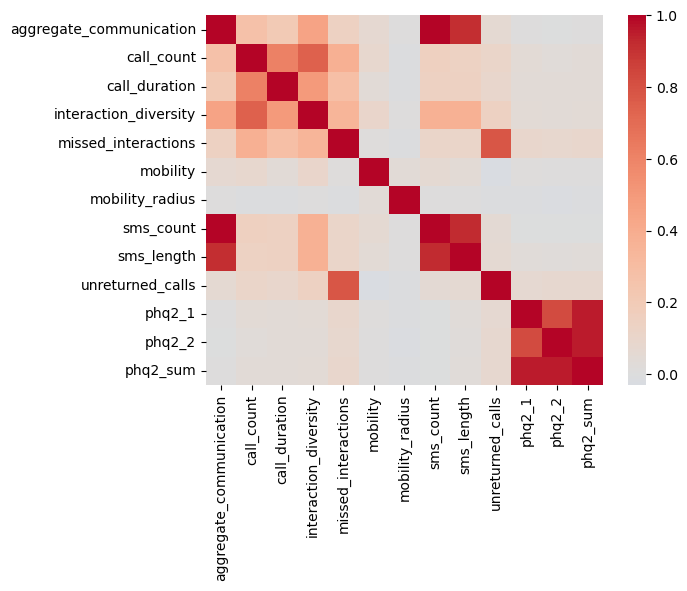



For v2_day:


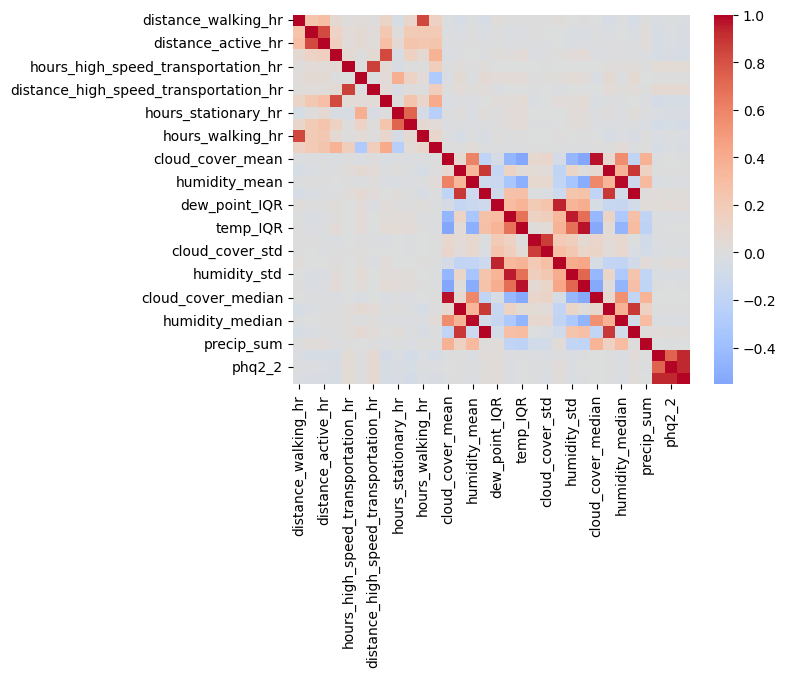



For v1_week:


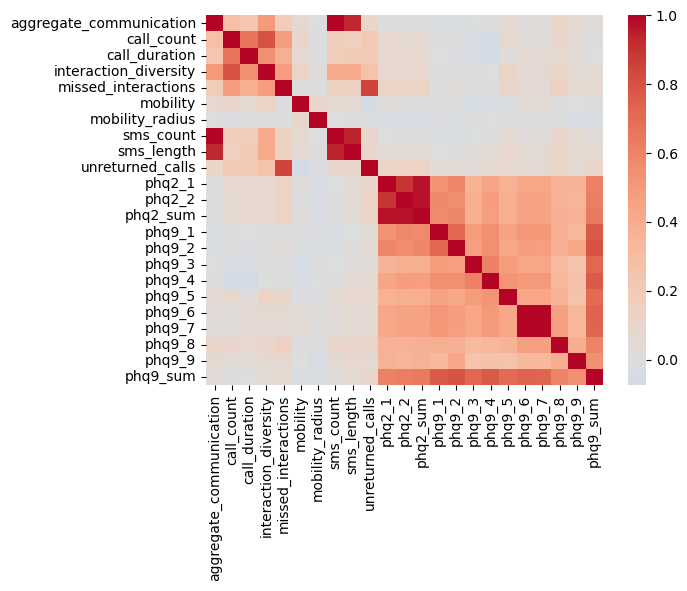



For v2_week:


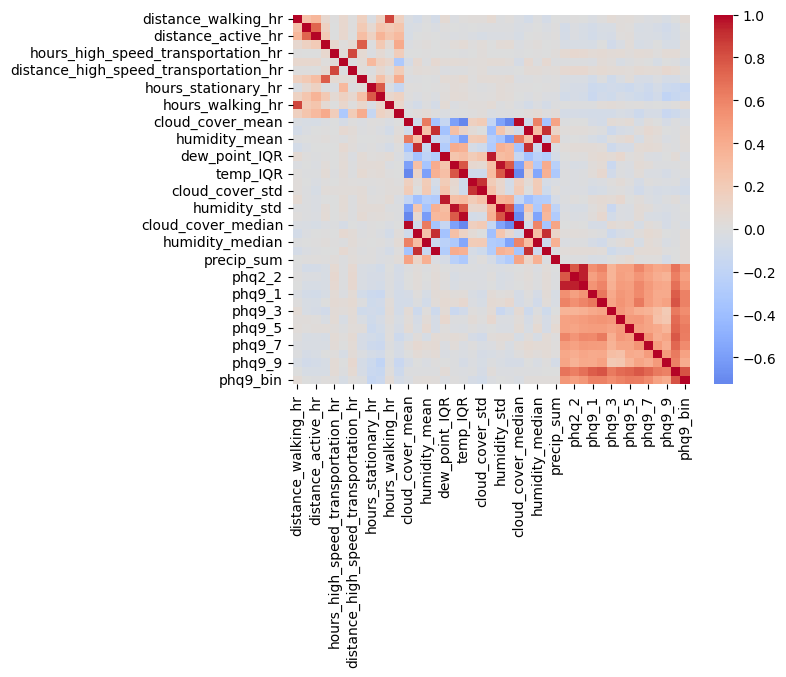

In [326]:
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_dropped.csv'))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    print(f'\n\nFor {name}:')
    numeric_cols = [col for col in df.columns.to_list() if col not in id_columns and col not in demographic_columns]
    sns.heatmap(df[numeric_cols].corr(), cmap="coolwarm", center=0)
    plt.show()


### Results: collinearity

As we expected, there are many correlated values. For example, some values are sums or weighted combinations of each other. SMS and call information is aggregated into 'aggregate communication' and 'interaction diversity'. 
Since aggregate communication is a feature already engineered, we'll try dropping the other phone communication features. This will help us avoid the issue of phone features such as SMS-length and SMS-count being highly correlated, as well as call-duration and call-count. 

Additionally, the survey variables are highly correlated, which is expected. The survey variables are most highly correlated with the sum/bin variables, which is expected. We'll try two versions of the model-- one, with predicting the sum/bin variables, and one with predicting individual items.

There are also variables which are inherently correlated, such as the distance/time variables. 

In the feature_pca notebook, we'll do some feature engineering to create conglomerated variables of important features.

In the separate feature_selection notebook, we'll select raw features. There we'll establish which features to keep, based on their importance to target variables.



In [327]:
############# Add linear interpolated col #################
importlib.reload(pre)

for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_dropped.csv'))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    print(f'\n\nFor {name}:')
    print(df.columns)
    cols_to_interpolate = [col for col in df.columns if col not in id_columns and 'Unnamed' not in col]
    df_int = pre.add_linear_interpolated_col(df, cols_to_interpolate, threshold_percentage=70, overwrite=False)
    df_int.to_csv(os.path.join(brighten_dir, f'{name}_int.csv'), index=False)
    print(f"Created {name}_int in brighten_dir")




For v1_day:
Index(['num_id', 'dt', 'week', 'day', 'idx', 'aggregate_communication',
       'call_count', 'call_duration', 'interaction_diversity',
       'missed_interactions', 'mobility', 'mobility_radius', 'sms_count',
       'sms_length', 'unreturned_calls', 'phq2_1', 'phq2_2', 'phq2_sum'],
      dtype='object')
Var: aggregate_communication | Total weeks: 8469 | Weeks interpolated: 9
Var: call_count | Total weeks: 8469 | Weeks interpolated: 9
Var: call_duration | Total weeks: 8469 | Weeks interpolated: 9
Var: interaction_diversity | Total weeks: 8469 | Weeks interpolated: 9
Var: missed_interactions | Total weeks: 8469 | Weeks interpolated: 9
Var: mobility | Total weeks: 8469 | Weeks interpolated: 657
Var: mobility_radius | Total weeks: 8469 | Weeks interpolated: 659
Var: sms_count | Total weeks: 8469 | Weeks interpolated: 9
Var: sms_length | Total weeks: 8469 | Weeks interpolated: 9
Var: unreturned_calls | Total weeks: 8469 | Weeks interpolated: 695
Var: phq2_1 | Total weeks: 8469

In [328]:
########## Print out percentage data added from interpolation ##########

for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_int.csv'))
    print(f'\n\nFor {name}:')
    drop_cols = [col for col in df.columns if 'Unnamed' in col]
    df = df.drop(columns=drop_cols)
    cols_to_interpolate = [col for col in df.columns if col not in id_columns and '_int' not in col]
    for col in cols_to_interpolate:
        int_column = f'{col}_int'
        # interpolated df
        col_df_int = df[['num_id', 'week', 'day', int_column]]
        int_still_missing = col_df_int[int_column].isna().sum()
        col_df_int_full = col_df_int.dropna()
        # non-interpolated df
        col_df = df[['num_id', 'week', 'day', col]]
        col_df_full = col_df.dropna()
        # added from interpolation
        added_instances = col_df_int_full.shape[0] - col_df_full.shape[0]
        percent_added = added_instances / col_df_full.shape[0]
        if percent_added > 0.001:
            print(f'for {col}, there are {len(col_df_int_full['num_id'].unique())} subjects with data, {int_still_missing} still missing in {col_df_int.shape[0]} rows, {added_instances} ({percent_added:.2f}%) rows added from interpolation.')




For v1_day:
for mobility, there are 545 subjects with data, 20983 still missing in 49674 rows, 821 (0.03%) rows added from interpolation.
for mobility_radius, there are 545 subjects with data, 20983 still missing in 49674 rows, 824 (0.03%) rows added from interpolation.
for unreturned_calls, there are 308 subjects with data, 30822 still missing in 49674 rows, 856 (0.05%) rows added from interpolation.
for phq2_1, there are 740 subjects with data, 11395 still missing in 49674 rows, 1890 (0.05%) rows added from interpolation.
for phq2_2, there are 740 subjects with data, 11396 still missing in 49674 rows, 1890 (0.05%) rows added from interpolation.
for phq2_sum, there are 740 subjects with data, 11396 still missing in 49674 rows, 1890 (0.05%) rows added from interpolation.


For v2_day:
for distance_walking_hr, there are 296 subjects with data, 8234 still missing in 21433 rows, 1042 (0.09%) rows added from interpolation.
for hours_active_hr, there are 296 subjects with data, 8234 still

We see that this imputation was not very successful
Let's try with a more complex imputation method, MissForest

In [ ]:
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_dropped.csv'))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    cols_to_impute = [col for col in df.columns if col not in id_columns]
    df.columns = df.columns.str.strip()  # remove leading/trailing spaces
    df.columns = df.columns.str.replace(r'[^\w\s]', '_', regex=True) #change any illegal characters to underscore
    
    print(f'\n\n\nFor DATASET: {name}, imputing {cols_to_impute}')

    non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
    print("Non-numeric columns:", non_numeric_cols.tolist())

    df_imp, mse_list, imputed_subs, nonimputed_subs = pre.missforest_imputation_bysub(df, cols_to_impute, imputation_threshold=0.55, error_threshold = 0.6, verbose=True)
    if len(list(mse_list.values())) > 0:
        average_mse = sum(list(mse_list.values())) / len(list(mse_list.values()))
        print(f'For df: {name}, average_mse = {average_mse}, {len(imputed_subs)} imputed_subs, {len(nonimputed_subs)} nonimputed_subs')
    df_imp.to_csv(os.path.join(brighten_dir, f'{name}_imp.csv'), index=False)
    print(f'Saved dfs_imputed[{name}] to {name}_imp.csv')


/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "





For DATASET: v1_day, imputing ['aggregate_communication', 'call_count', 'call_duration', 'interaction_diversity', 'missed_interactions', 'mobility', 'mobility_radius', 'sms_count', 'phq2_1', 'phq2_2', 'phq2_sum', 'gender', 'age', 'aggregate_communication_int', 'call_count_int', 'call_duration_int', 'interaction_diversity_int', 'missed_interactions_int', 'mobility_int', 'mobility_radius_int', 'sms_count_int', 'phq2_1_int', 'phq2_2_int', 'phq2_sum_int', 'gender_int', 'age_int']
Non-numeric columns: ['dt']
For sub 1.0, 69 rows, 2070 cells, 1538


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 218.99it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnin

NaNs in original_values: 0 [1.1144682015238343, -0.9227928910884156, 0.5354623502585365, 0.4969496434460187, -0.2669117165942992, -0.2418236054996453, 0.3721243736923176, 0.6869611115455464, -0.2152312136896067, -0.3696298085156641, 0.3680378868511664, -0.436029133375284, -1.426274438763467, 0.3170031811150007, -0.2617650707475853, -0.0578096862849439, -0.9455158172140912, 1.0441659326774952, -0.4408964569701349, 0.2418035801568485, 1.4501667792933448, 0.2439161065781278, -0.3075441496848549, 0.1565618341431059, 1.4202389578624088, 0.218331183558034, -0.1128275227280603]
NaNs in imputed_values: 0 [0.6871666174378482, 0.0389063926864937, 0.5354623502585365, 0.1500375212143797, -0.2669117165942992, -0.2418236054996453, 0.3721243736923176, 0.6869611115455464, 1.0441659326774952, -0.3696298085156641, -0.3075441496848549, -0.436029133375284, -1.426274438763467, 0.3170031811150007, -0.2617650707475853, -0.0578096862849439, -0.9455158172140912, -0.2152312136896067, -0.4408964569701349, 0.2418

100%|██████████| 5/5 [00:00<00:00,  8.23it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 79.40it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-0.0026885827127007, 0.5020858019723162, 0.4272262585994814, 0.4158730482107488, -0.6151597207528106, -1.3240377732873965, 0.5030729588725891, 0.8028429102739653, 0.25952860326769, -0.1271211727796022, 0.687392948629272, 1.5809064840107594, 0.9313037772846154, -0.93361601070128, 0.9577197714617572, 0.9313037772846154, 0.4384502340232461, -1.4562648950262402, 0.5020858019723162, 0.3103683540798033, -0.1771115569447734, 0.3221096598130781, -0.973486652813094, 0.5910996647130813, 0.5376159441237097, -0.3005315102750349, 0.9477446293987992, 0.2270655959662507, 0.5579171848749366, -0.3344641732441342, -0.3334963289566244, 0.726833465089875, 1.284393995434396, 1.341043723715849, 0.484482495079626, 1.352181241742051, 0.30213648801083, 0.3693952350805101, 0.5910996647130813, 0.6916847991438089, -1.4296631536710505, -0.3978941632411574, 1.341043723715849, 0.8016595496503961, -0.2725308776717399, 0.1141613357254438, 0.1985347939822722, 1.2429177494421528, 0.5020858019

100%|██████████| 5/5 [00:11<00:00,  2.26s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 73.14it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [0.063540196110286, -0.3008717081749458, 1.2429177494421528, 0.2208497172488605, 0.8461554050454704, 0.5850625754215308, 1.3860581810003187, 0.2554537331745266, 1.2429177494421528, 1.946663948587956, 0.8028429102739653, 0.7701053042070317, -0.0861773572166989, 0.4490685777063508, 1.946663948587956, 0.9461765010161588, -0.6670643163985726, 0.1477698556615832, -0.8568600576912287, 1.0317274867064423, 1.946663948587956, 0.3221096598130781, 0.0242441289605869, -0.8209641599362446, 0.607189164823874, 0.1930288458754619, 1.4583958523071314, 0.984005228885677, -0.0107053272757376, 0.9078107786277532, -0.8510269188437796, 0.8614364582721442, 0.2307830704156659, -0.8310117411907996, 0.4490685777063508, 0.6201979342480815, 0.7010658615413888, 1.252290566731446, 0.8461554050454704, 1.0607255094125951, 0.984005228885677, -0.8568600576912287, 0.4490685777063508, -1.021183947237974, -1.2820536191533138, 0.2962707816009556, -0.8568600576912287, -0.1705479085384602, 0.701065

100%|██████████| 5/5 [00:11<00:00,  2.26s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 70.90it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-0.2913624656334185, -0.5621456520219703, 0.5111240215700416, -0.0107053272757376, 1.252290566731446, 1.047463034226495, 1.4363227110152463, -0.5752242975275516, 0.1930288458754619, 0.3221096598130781, -0.8568600576912287, 1.2429177494421528, 0.2208497172488605, -0.8568600576912287, 0.0090922585890056, -0.8568600576912287, 0.2607132936913358, 0.4254774143465896, 0.8071744843852264, 0.8028429102739653, 0.8502398838296704, 0.5508428099874569, -0.8997076594418032, -0.4958020128460524, 0.5376159441237097, 0.956782459423283, 1.5809064840107594, 0.687392948629272, -0.8568600576912287, 0.0627503866576922, -0.8198944575337878, 0.1316050240982107, 0.7668025246302053, 0.8310526022213226, 0.4299655320379486, 0.114342451509142, 1.5950729191318276, 0.8968368090456281, 0.7139264175275227, -0.7159801487108353, 3.4879625073657183, 0.0627503866576922, 0.1165116903392371, 0.3032262158882039, -0.8568600576912287, 0.417901572505892, 0.3221096598130781, -0.5176463687589642, 0.32

100%|██████████| 5/5 [00:08<00:00,  1.73s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 75.41it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-0.2908795746842201, 0.6916847991438089, 2.1717748856919066, -0.4389489794554244, -0.0026885827127007, -0.652301829241175, -0.4321511070706135, -0.8568600576912287, -0.8568600576912287, -0.8568600576912287, -0.8568600576912287, 0.0948302280246338, -0.3314856274590424, -1.70102663256382, -1.7280132688637366, -0.7541756138572036, -0.6970619645692104, 0.0242441289605869, -1.660097132118797, -0.4321511070706135, 0.2307830704156659, -0.8360939694428913, -0.8731372446677479, -0.6271009818347029, -0.1313939987689648, -1.021183947237974, -0.3210461390751716, -0.5752242975275516, 1.0760413388951964, 0.1926754048494127, -0.9923751363927712, 0.1930288458754619, 0.0143022926107829, -0.5394354783469658, -1.003738142995962, -1.021183947237974, -0.3003011159555862, -1.366388016113543, 0.5017849796883768, 0.1930288458754619, 0.702964893941164, -0.8360939694428913, -0.7541756138572036, -1.021183947237974, -0.1852463560190868, 1.3358281403412833, 0.1930288458754619, 0.7310067

100%|██████████| 5/5 [00:01<00:00,  4.79it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 40.96it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [1.1484586295632375, 1.837237235103119, 0.1930288458754619, 1.837237235103119, -0.6670643163985726, -0.6670643163985726, 1.5809064840107594, 0.4034938071722895, -0.0519409115157216, -0.0133805840172275, 0.0575674284046878, 1.837237235103119, 1.837237235103119, -0.8568600576912287, -1.7280132688637366, -0.668009933709232, -0.4760462512100965, 1.1484586295632375, 0.2303170572297623, 0.2482495220791764, -0.8568600576912287, 1.837237235103119, -0.030973954733119, -0.8198944575337878, 1.837237235103119, 1.1484586295632375, 0.1968820013204324, 1.837237235103119, 1.1484586295632375, -1.660097132118797, 1.837237235103119, 0.1930288458754619, 1.837237235103119, 1.837237235103119, 1.837237235103119, 0.1930288458754619, 0.3221096598130781, 1.837237235103119, 1.1484586295632375, -2.1566135399789093, -1.7280132688637366, -0.4760462512100965, -0.7627157584904622, -1.2820536191533138, 2.269658206503965, 1.1484586295632375, 1.837237235103119, -0.8360939694428913, -1.02118394

100%|██████████| 5/5 [00:08<00:00,  1.79s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 81.33it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-0.632105182018202, 1.481715053419831, 0.8076742937728633, -0.5238087178260183, -0.8273675738127809, 0.0309506247657109, 1.837237235103119, 0.0191381516513593, -0.439800144770041, 1.837237235103119, 1.4907335129292352, 0.4627580452871369, 0.8047849034272447, -1.0726331873047918, 1.837237235103119, 1.837237235103119, -0.5238087178260183, -0.0041124841552299, 1.6242324336645195, -0.0041124841552299, -0.0041124841552299, -0.0041124841552299, -0.1140688886599099, 0.0066632612000055, -1.2086283786744478, 1.837237235103119, 0.4530459493383684, 0.0066632612000055, 1.481715053419831, -0.0041124841552299, -0.8537085614715082, 1.481715053419831, 1.481715053419831, -0.2062267000547041, 0.0191381516513593, 1.481715053419831, 1.481715053419831, -0.4644360301468657, 1.481715053419831, 1.837237235103119, 1.481715053419831, -0.0041124841552299, -1.118226013933309, 1.481715053419831, 1.481715053419831, -0.0041124841552299, -0.0041124841552299, -0.5238087178260183, 0.00666326

100%|██████████| 5/5 [00:08<00:00,  1.76s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 86.88it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [1.837237235103119, 2.032592378065161, 0.0191381516513593, -1.148261686322017, -1.2237889759268574, -0.6195434924702059, -0.3364749083939229, -1.2237889759268574, -1.118226013933309, 1.837237235103119, -1.118226013933309, 1.837237235103119, 2.032592378065161, 1.837237235103119, 2.245772520162549, -0.6273082668177061, 0.2647670453499034, -1.118226013933309, 2.069950082225174, -1.2237889759268574, -0.6905629597650715, -1.118226013933309, 0.0066632612000055, 1.837237235103119, 2.0059886490034553, -0.8692640541806257, 1.837237235103119, 0.0066632612000055, -1.118226013933309, 1.837237235103119, 0.8076742937728633, 0.8378333210326907, -1.118226013933309, -1.148261686322017, 2.032592378065161, 2.032592378065161, -1.2237889759268574, 1.60501373611251, 0.6580527170201032, 2.032592378065161, 1.9314295479253043, 2.2475918402111015, 1.206477079099494, 1.837237235103119, 0.0191381516513593, -0.5494748317969571, 0.0674931549895991, 0.0191381516513593, -1.118226013933309, 

100%|██████████| 5/5 [00:09<00:00,  1.83s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 82.36it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [0.8378333210326907, 1.837237235103119, 1.4238561445007274, 1.929674178560559, 1.837237235103119, 1.4493248084002923, 1.929674178560559, 1.929674178560559, -1.118226013933309, 1.929674178560559, 1.95182349593965, 1.9375913312522344, 1.324629308283834, 1.929674178560559, 1.95182349593965, 1.324629308283834, 1.837237235103119, 0.0066632612000055, 1.95182349593965, 1.4238561445007274, 0.8047849034272447, 1.837237235103119, 1.837237235103119, 0.2444181333341231, 1.95182349593965, 1.837237235103119, 1.837237235103119, 1.929674178560559, 1.837237235103119, -0.6843619776235002, 1.837237235103119, -1.162501152824231, 1.95182349593965, 0.8076742937728633, 0.8076742937728633, 1.324629308283834, 1.324629308283834, 0.4627580452871369, 1.324629308283834, 1.95182349593965, 1.324629308283834, 1.837237235103119, 0.8047849034272447, 1.929674178560559, 1.9375913312522344, 1.324629308283834, 0.8047849034272447, -0.9488791506486116, 0.8157673347642824, 1.837237235103119, -1.1357

100%|██████████| 5/5 [00:07<00:00,  1.51s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 85.64it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-0.0041124841552299, 1.4493248084002923, 0.8378333210326907, 1.837237235103119, 1.4373450375664545, -0.3879130607974149, 1.059183397683749, -0.3549469968680455, 1.481715053419831, 1.837237235103119, 0.594312949550093, 0.0191381516513593, 0.8378333210326907, 0.0191381516513593, 0.4627580452871369, 0.8047849034272447, 1.4373450375664545, 0.8047849034272447, 1.837237235103119, 1.481715053419831, 1.481715053419831, 1.481715053419831, 0.8047849034272447, 0.0066632612000055, 1.837237235103119, 0.0066632612000055, 0.0066632612000055, 0.8047849034272447, 1.481715053419831, 1.837237235103119, 1.481715053419831, 1.4373450375664545, 0.8378333210326907, -0.0041124841552299, 0.4627580452871369, 1.4238561445007274, 0.8047849034272447, 0.8076742937728633, 0.8047849034272447, 1.837237235103119, 1.481715053419831, 1.837237235103119, 0.0066632612000055, 1.837237235103119, 1.481715053419831, 1.837237235103119, 1.481715053419831, 1.4238561445007274, -0.3333970940767049, 2.07042

100%|██████████| 5/5 [00:05<00:00,  1.17s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 117.63it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnin

NaNs in original_values: 0 [0.8076742937728633, 0.0066632612000055, -0.0054829216750057, -0.544295522044475, 0.8378333210326907, 0.8047849034272447, -0.0054829216750057, -0.544295522044475, -0.544295522044475, 0.0066632612000055, -0.0054829216750057, -0.544295522044475, -1.148261686322017, 0.0191381516513593, -0.0054829216750057, -0.544295522044475, -0.544295522044475, 0.4627580452871369, -1.148261686322017, -1.148261686322017, 0.8378333210326907, -0.0041124841552299, 0.0191381516513593, 0.0066632612000055, -0.544295522044475, 0.4627580452871369, -0.0054829216750057, -0.544295522044475, -0.544295522044475, -1.118226013933309, -0.544295522044475, -0.0054829216750057, -1.2237889759268574, 0.0191381516513593, -0.544295522044475, -0.544295522044475, 0.0191381516513593, 0.0066632612000055, -0.544295522044475, -0.0054829216750057, -1.118226013933309, 0.4627580452871369, -0.544295522044475, -0.544295522044475, -0.5185909425284259, 0.8047849034272447, -0.544295522044475, 0.0191381516513593, -0

100%|██████████| 5/5 [00:08<00:00,  1.73s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 84.16it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-1.2237889759268574, -0.8178362258369741, 0.8076742937728633, 1.162738303387976, -0.8178362258369741, -1.118226013933309, -1.118226013933309, 0.8047849034272447, 0.2931958353996671, -0.544295522044475, -1.148261686322017, -0.4823842081682677, -0.8178362258369741, 0.0066632612000055, -1.2237889759268574, 0.8378333210326907, -1.2237889759268574, -0.544295522044475, -1.148261686322017, 0.0824004583241757, -1.148261686322017, -0.8178362258369741, -1.118226013933309, 2.033976444928067, -1.148261686322017, -0.544295522044475, -1.2237889759268574, -1.083966612299418, 0.0191381516513593, 1.162738303387976, -1.2237889759268574, -1.148261686322017, -0.8979119042018437, -0.4644360301468657, -1.118226013933309, -0.830170047106441, 0.0066632612000055, -0.544295522044475, -0.8178362258369741, -0.544295522044475, -1.148261686322017, -0.8178362258369741, -0.8178362258369741, 0.0066632612000055, -1.2237889759268574, -0.8178362258369741, -0.8178362258369741, -0.92967333801215

100%|██████████| 5/5 [00:07<00:00,  1.45s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 87.09it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-0.113060043946556, -1.2237889759268574, -1.148261686322017, 0.7191184097521985, 0.4627580452871369, -0.113060043946556, 0.0191381516513593, -0.113060043946556, -0.113060043946556, -0.544295522044475, 1.460422943533145, -0.544295522044475, -0.1847449257052389, -0.544295522044475, 0.0066632612000055, -0.113060043946556, -0.544295522044475, -1.148261686322017, -0.113060043946556, 0.8047849034272447, -1.2237889759268574, -1.118226013933309, 0.0066632612000055, 0.0191381516513593, -0.544295522044475, -1.148261686322017, 1.162738303387976, -0.544295522044475, -1.148261686322017, -0.113060043946556, -0.0041124841552299, -0.113060043946556, -1.148261686322017, -0.0041124841552299, 0.8047849034272447, -0.113060043946556, 0.4057240823136251, 0.0066632612000055, -1.148261686322017, -0.544295522044475, -0.544295522044475, -0.113060043946556, 0.6575158023448101, 0.0066632612000055, -0.113060043946556, -1.1911922770696937, -1.236730431294582, -1.1905585059957684, -0.0041

100%|██████████| 5/5 [00:13<00:00,  2.79s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 41.34it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-0.8568600576912287, 0.8036316653955482, 1.0932854576537108, 0.8378333210326907, 0.8378333210326907, -0.544295522044475, -0.5238087178260183, -1.118226013933309, -0.5238087178260183, 1.9375913312522344, -0.8568600576912287, -1.2237889759268574, -1.0613651321040658, -0.544295522044475, 0.0191381516513593, -2.241634306020402, -1.2237889759268574, -2.241634306020402, 0.8076742937728633, 1.4373450375664545, -2.241634306020402, -2.241634306020402, 1.4373450375664545, -0.5238087178260183, -1.118226013933309, -1.2237889759268574, -2.241634306020402, 0.1708377849752394, 1.183909356489384, 0.1663909970268315, 0.1930288458754619, -1.1548563514006431, 1.1129283867727011, -1.148261686322017, -0.544295522044475, -0.544295522044475, 1.3586999727307256, -1.148261686322017, -0.8568600576912287, 0.9168562767203332, -0.5238087178260183, -0.544295522044475, -1.148261686322017, 0.8076742937728633, -2.241634306020402, -0.544295522044475, -1.148261686322017, -0.544295522044475, -

100%|██████████| 5/5 [00:15<00:00,  3.18s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 39.40it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [1.2566928145567635, -0.4321511070706135, -0.0054829216750057, -2.1566135399789093, -0.0054829216750057, -0.8568600576912287, -1.70102663256382, -0.5752242975275516, 0.4602619423212057, -1.70102663256382, -1.021183947237974, -0.1852463560190868, -0.544295522044475, -0.544295522044475, -0.8568600576912287, -0.0054829216750057, -0.0054829216750057, -0.2908795746842201, -2.3006249251564737, -0.0054829216750057, -1.3914353464257203, -2.3006249251564737, -0.5072217351358497, -0.0054829216750057, -1.3914353464257203, 1.9375913312522344, -0.8568600576912287, -0.544295522044475, 0.8028429102739653, -1.70102663256382, 1.3259218762021974, -1.021183947237974, 2.774360740822285, -0.8568600576912287, 2.5282254913106166, -0.8198944575337878, -1.2820536191533138, -0.0054829216750057, -0.544295522044475, -0.544295522044475, -0.0041124841552299, 0.8076742937728633, -1.70102663256382, -0.544295522044475, 1.4238561445007274, -0.0054829216750057, 0.6916847991438089, -0.005482921

100%|██████████| 5/5 [00:17<00:00,  3.45s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 39.09it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [1.47835837289379, -0.2037461033504941, -0.544295522044475, -0.1313939987689648, 1.5250932450823542, 1.0667206616345533, -0.544295522044475, -1.5001061142446774, -1.5001061142446774, 0.7880948588296612, -1.118226013933309, 1.1564624392193514, -1.5001061142446774, 0.0191381516513593, -1.148261686322017, -0.4321511070706135, 1.0824420088954063, -0.544295522044475, 0.2208497172488605, 0.0066632612000055, -0.8568600576912287, 1.9812171468678952, -0.0041124841552299, -1.5001061142446774, 0.1930288458754619, -1.70102663256382, -0.8568600576912287, -0.329050960768344, -0.1436957652272292, 0.0242441289605869, -1.2237889759268574, -1.5001061142446774, -1.118226013933309, 0.956124138455295, 0.7762545601753114, 0.895408164801123, 0.2607132936913358, -0.0026885827127007, 0.2604739981426704, 1.162738303387976, -0.8568600576912287, 0.3032262158882039, -0.329050960768344, 0.4582951718275035, -0.544295522044475, 0.1941281337782502, -1.70102663256382, -1.5001061142446774, 0.3

100%|██████████| 5/5 [00:09<00:00,  1.96s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 84.70it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-1.118226013933309, 1.5430591091551171, 0.1883548333462976, -1.148261686322017, 0.1883548333462976, -0.544295522044475, -1.148261686322017, 0.1883548333462976, 0.1883548333462976, 0.8503828206077028, -1.148261686322017, -1.148261686322017, 0.1883548333462976, 0.1883548333462976, -1.118226013933309, -1.148261686322017, 0.1883548333462976, -0.0041124841552299, -1.148261686322017, 0.6780629757409291, 0.684954861335697, -1.118226013933309, -0.544295522044475, 0.0066632612000055, 0.1381400051914425, 0.1883548333462976, 0.8047849034272447, -0.5238087178260183, 0.1883548333462976, -1.118226013933309, 0.1883548333462976, -0.0041124841552299, 0.0191381516513593, -1.2237889759268574, 1.6493469822815685, -1.2237889759268574, 1.4373450375664545, 0.1883548333462976, -1.2237889759268574, 0.5220060965359987, -0.544295522044475, 0.8378333210326907, 1.95182349593965, 0.3151057886533596, -0.0041124841552299, 0.0722070908244346, 0.1883548333462976, -1.118226013933309, -1.14826

100%|██████████| 5/5 [00:08<00:00,  1.76s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 79.40it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [1.4238561445007274, -0.544295522044475, -1.3348043959713574, -1.118226013933309, -0.544295522044475, -1.4735710791036074, -1.157805172570911, 0.0066632612000055, -0.544295522044475, 1.481715053419831, 0.0191381516513593, 0.511995748591448, -0.544295522044475, -1.6712438497765238, -0.0041124841552299, -0.5370269323205354, 0.4627580452871369, -0.544295522044475, 0.8047849034272447, -1.6731638436945868, -0.544295522044475, 1.481715053419831, 1.95182349593965, -1.6521469855464144, -0.544295522044475, -1.3348043959713574, -0.544295522044475, -1.118226013933309, -1.27703198290451, 1.9375913312522344, 1.481715053419831, 0.8378333210326907, 0.8378333210326907, 1.705685172865354, -1.241416587432851, 1.481715053419831, -0.0041124841552299, -1.118226013933309, -1.148261686322017, 0.0066632612000055, -0.6902592143984387, -0.544295522044475, 0.4627580452871369, 1.481715053419831, -0.0041124841552299, -0.0126406499461643, -1.2237889759268574, -1.118226013933309, -0.464551

100%|██████████| 5/5 [00:18<00:00,  3.65s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 38.71it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-0.0041124841552299, -0.00912324153365, 0.1198955710524768, 0.7730531787399645, 0.4034938071722895, 0.1930288458754619, 1.504049578913789, -0.544295522044475, 0.7372591236210899, 0.8076742937728633, -1.4631465809130062, -0.0041124841552299, 0.6199876632547009, 1.048579360552072, 0.1347372834703955, -0.2547920320509684, -0.8568600576912287, -0.544295522044475, -0.0861773572166989, 0.8047849034272447, -0.8178362258369741, -0.7285809216991191, 0.7642152556134896, -0.544295522044475, -0.8178362258369741, -0.544295522044475, -0.57853037474389, 0.3221096598130781, -0.544295522044475, -0.544295522044475, 1.504049578913789, -0.8568600576912287, 0.7960696467669405, -0.3960943269127088, -0.26619935063035, 0.0191381516513593, 0.8028429102739653, 0.0191381516513593, -0.544295522044475, -0.6925835378783102, 0.6612387464211169, -0.0041124841552299, 0.0066632612000055, 0.5020858019723162, 0.2208497172488605, -0.0041124841552299, 1.2429177494421528, 0.0191381516513593, -0.8

100%|██████████| 5/5 [00:05<00:00,  1.09s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 113.97it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnin

NaNs in original_values: 0 [-1.118226013933309, -1.148261686322017, 1.837237235103119, -1.2237889759268574, -1.148261686322017, 1.837237235103119, 1.837237235103119, -0.5238087178260183, -1.118226013933309, -0.0054829216750057, -1.148261686322017, -0.0054829216750057, -1.118226013933309, -1.2237889759268574, -1.148261686322017, 0.0191381516513593, 1.837237235103119, -0.0054829216750057, -1.148261686322017, -0.0054829216750057, -0.0054829216750057, 1.837237235103119, -1.118226013933309, -0.0054829216750057, 0.0191381516513593, 1.837237235103119, -1.118226013933309, 0.0066632612000055, 1.837237235103119, -1.148261686322017, 1.837237235103119, -0.0054829216750057, 1.837237235103119, 0.0066632612000055, 1.837237235103119, -0.0041124841552299, -1.2237889759268574, 1.837237235103119, -0.0054829216750057, -0.0054829216750057, -1.118226013933309, -1.118226013933309, -1.148261686322017, -1.2237889759268574, 1.837237235103119, -1.118226013933309, 1.837237235103119, -0.5238087178260183, 0.8076742

100%|██████████| 5/5 [00:06<00:00,  1.22s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 119.17it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnin

NaNs in original_values: 0 [-0.544295522044475, -0.544295522044475, -0.2372222128137023, 1.000708137508266, 0.4627580452871369, 0.2510443100382395, 1.000708137508266, 1.000708137508266, -0.544295522044475, -1.2237889759268574, 1.95182349593965, -0.0041124841552299, 0.0066632612000055, 1.929674178560559, 1.4238561445007274, 1.4373450375664545, 1.929674178560559, 1.000708137508266, 1.4373450375664545, 1.000708137508266, -0.544295522044475, 0.8378333210326907, -0.544295522044475, 1.4373450375664545, 1.000708137508266, -1.2237889759268574, 1.9375913312522344, 1.000708137508266, 1.162738303387976, -1.118226013933309, 1.4373450375664545, -0.544295522044475, -1.118226013933309, -0.5185909425284259, 1.000708137508266, -0.544295522044475, 1.929674178560559, 1.9375913312522344, 1.162738303387976, -0.544295522044475, 1.000708137508266, -1.118226013933309, 1.000708137508266, -0.5238087178260183, -0.544295522044475, -0.544295522044475, -0.544295522044475, -0.0041124841552299, -0.544295522044475, 0.

100%|██████████| 5/5 [00:08<00:00,  1.73s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 82.00it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-0.3201043717060687, -0.0041124841552299, -0.3555602388580266, -1.036247153388089, -1.3423001065230509, -0.3555602388580266, 1.837237235103119, -0.3555602388580266, -1.148261686322017, 1.837237235103119, -1.118226013933309, 1.837237235103119, 0.309543952428687, -1.1353107993137306, 0.9835122084024596, -1.0940491191740953, 0.1295331430273873, -1.148261686322017, 1.837237235103119, -1.118226013933309, -1.118226013933309, 1.837237235103119, -1.118226013933309, -1.118226013933309, 1.433397632087005, 1.837237235103119, -0.5238087178260183, -1.118226013933309, -1.118226013933309, 1.837237235103119, -0.3555602388580266, -0.5939477665763929, -0.3555602388580266, 0.0066632612000055, -1.148261686322017, -1.3777873833819727, -0.6684676665801678, -1.2237889759268574, -1.2237889759268574, 1.837237235103119, -0.3555602388580266, 0.0066632612000055, 0.0066632612000055, 1.837237235103119, -1.2237889759268574, -0.7218733467073055, -0.3555602388580266, -0.6014300120379195, 0.

100%|██████████| 5/5 [00:08<00:00,  1.68s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 78.96it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-1.2237889759268574, 1.162738303387976, 0.0066632612000055, -1.2237889759268574, 0.0191381516513593, -1.118226013933309, -1.118226013933309, -0.3555602388580266, -0.3555602388580266, -0.544295522044475, -0.3555602388580266, -0.3555602388580266, 0.8047849034272447, -0.437831995707445, -0.5238087178260183, 0.0191381516513593, -1.148261686322017, -1.148261686322017, -1.118226013933309, -0.8487137001813037, -0.3555602388580266, -0.0041124841552299, -1.148261686322017, -0.544295522044475, -0.3555602388580266, 0.0515763603334441, 0.8076742937728633, -0.544295522044475, 0.2510443100382395, -0.0041124841552299, -0.0430639597980552, -1.118226013933309, -0.3555602388580266, -0.544295522044475, -0.544295522044475, -1.148261686322017, 0.0066632612000055, -0.544295522044475, -0.3555602388580266, -0.544295522044475, -0.544295522044475, -0.544295522044475, -0.3555602388580266, -0.3555602388580266, -1.118226013933309, 0.0066632612000055, -0.544295522044475, 0.80767429377286

100%|██████████| 5/5 [00:18<00:00,  3.73s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 39.94it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [0.9805289096756106, 0.114342451509142, 0.6506308203252451, -1.0910835369440652, 1.4238561445007274, 1.0107018859087995, 1.0978671890287992, 1.5809064840107594, 0.4390277919990193, 1.8570633879519167, -0.544295522044475, 0.6506308203252451, 1.4493248084002923, 0.114342451509142, -0.544295522044475, 0.5020858019723162, -0.8731372446677479, 0.6506308203252451, 0.908113334601834, 1.4373450375664545, 1.4238561445007274, 0.8076742937728633, -0.8198944575337878, 0.5150108277220397, 0.3221096598130781, -0.4389489794554244, -0.2344515452255256, -1.1905394193041543, -1.021183947237974, 0.2208497172488605, 0.6506308203252451, -0.6670643163985726, -0.1182039570081722, -0.2465673793045565, -0.0300866014996739, -0.544295522044475, 1.4373450375664545, 0.6506308203252451, 1.6029065456544846, 0.8047849034272447, -0.1313939987689648, 0.6916847991438089, 1.4493248084002923, 0.0417885511005324, 1.4373450375664545, -0.1152851885388576, 0.1198955710524768, -0.1313939987689648, -1

100%|██████████| 5/5 [00:08<00:00,  1.74s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 84.88it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-1.118226013933309, -1.118226013933309, -1.118226013933309, -0.544295522044475, -0.6625370797457836, 0.836197174897434, 0.836197174897434, -0.544295522044475, 0.0191381516513593, 0.836197174897434, 0.836197174897434, 0.8047849034272447, -0.544295522044475, 0.8076742937728633, 0.836197174897434, -1.340169934770151, 0.8076742937728633, -0.0971442806328163, 1.4373450375664545, 0.8076742937728633, 0.0191381516513593, -0.544295522044475, -1.118226013933309, -0.544295522044475, -0.544295522044475, 0.836197174897434, -0.544295522044475, 0.836197174897434, -1.2237889759268574, 0.836197174897434, -1.2237889759268574, 0.8378333210326907, -0.544295522044475, 0.8076742937728633, -1.2237889759268574, -1.118226013933309, 1.162738303387976, -1.118226013933309, -1.118226013933309, 0.836197174897434, -0.544295522044475, -1.42926400877209, 0.8047849034272447, -0.544295522044475, -1.2468603944148728, -1.1503127156192725, 0.8378333210326907, 0.8378333210326907, 0.83783332103269

100%|██████████| 5/5 [00:00<00:00, 13.51it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 126.02it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnin

NaNs in original_values: 0 [-0.544295522044475, -0.544295522044475, 1.4238561445007274, -0.5238087178260183, -0.544295522044475, 0.8047849034272447, 0.8378333210326907, 0.0066632612000055, 1.705685172865354, 1.162738303387976, 0.58310111650811, 0.8047849034272447, -0.544295522044475, 0.8076742937728633, 0.0066632612000055, 0.8076742937728633, -0.544295522044475, -0.5238087178260183, -0.544295522044475, 1.929674178560559, -0.544295522044475, 0.58310111650811, 0.8076742937728633, 1.4238561445007274, 1.929674178560559, 0.58310111650811, -0.544295522044475, 1.95182349593965, -0.544295522044475, -0.544295522044475, 0.58310111650811]
NaNs in imputed_values: 0 [0.58310111650811, 0.5831010937690735, -0.544295522044475, -0.0041124841552299, -0.5442955493927002, -0.544295522044475, 0.8047849034272447, -0.544295522044475, 1.4373450375664545, 1.4238561445007274, 0.4627580452871369, 0.58310111650811, -0.5442955493927002, 1.092341254915922, -0.544295522044475, 0.4627580452871369, 0.58310111650811, -

100%|██████████| 5/5 [00:05<00:00,  1.14s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 122.39it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnin

NaNs in original_values: 0 [0.8076742937728633, -1.2237889759268574, -1.2237889759268574, 0.0066632612000055, 0.2763591622231552, -0.544295522044475, 0.2763591622231552, -1.148261686322017, 1.929674178560559, -0.544295522044475, 0.2763591622231552, -0.544295522044475, 1.9375913312522344, -0.544295522044475, -0.544295522044475, 1.9375913312522344, -0.0041124841552299, -1.148261686322017, 0.2763591622231552, -1.148261686322017, 0.0191381516513593, 0.6575158023448101, 0.2763591622231552, -0.0041124841552299, -0.0041124841552299, -1.118226013933309, -0.5238087178260183, -0.544295522044475, 0.2763591622231552, 0.2763591622231552, 0.0066632612000055, -1.148261686322017, -0.544295522044475, 1.929674178560559, -0.544295522044475, -0.544295522044475, 0.0191381516513593, 1.4373450375664545, -0.544295522044475, 0.0191381516513593, -0.544295522044475, 1.4493248084002923, 0.2763591622231552, -0.1847449257052389, -1.2237889759268574, 0.2763591622231552, -0.544295522044475, 0.4627580452871369, 0.2763

100%|██████████| 5/5 [00:09<00:00,  1.82s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 80.30it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-0.0054829216750057, -0.0054829216750057, 0.0191381516513593, -0.544295522044475, -0.0041124841552299, 0.0066632612000055, 0.5802194739111816, -0.6879376530386233, -0.0041124841552299, -0.4772991732270834, -0.0054829216750057, -0.3725890521833173, 0.8378333210326907, -1.1097098001602532, -0.0054829216750057, -0.544295522044475, -0.913981738353476, -0.3324408417705904, 0.1417717196398405, 0.0191381516513593, -0.2473314935772553, -0.3844710573127653, -0.0041124841552299, 1.4771611992810738, 0.3196264472992802, -0.0041124841552299, 0.7362639886166996, 0.8378333210326907, -0.5238087178260183, -0.544295522044475, -0.544295522044475, 0.8378333210326907, -0.544295522044475, -0.0041124841552299, -1.2237889759268574, -0.544295522044475, 0.3839950903536989, -0.0772317844642651, 0.0341069807253376, -0.544295522044475, -0.0041124841552299, -0.4887151931033044, -0.0041124841552299, 0.1341083059015581, 0.0066632612000055, 0.0066632612000055, 0.0066632612000055, -0.5442955

100%|██████████| 5/5 [00:09<00:00,  1.83s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 79.97it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-0.0041124841552299, 0.5492685801409705, -1.1711302283154774, 0.0066632612000055, 0.0946689831217095, -0.544295522044475, -0.1365480671614295, 0.0946689831217095, -0.544295522044475, -1.118226013933309, -1.148261686322017, -1.118226013933309, -0.0041124841552299, -0.4266365859606469, -0.544295522044475, -1.148261686322017, 0.0066632612000055, 0.0946689831217095, 0.0946689831217095, 0.1402370538399918, -0.5238087178260183, -0.544295522044475, -1.118226013933309, 0.0066632612000055, 0.0946689831217095, 0.5765792362348408, 0.0066632612000055, -1.148261686322017, -1.2237889759268574, -1.2237889759268574, -1.2237889759268574, -1.1711302283154774, -1.118226013933309, 0.0281001922273887, 2.2634925335775757, -0.544295522044475, -1.4951914140371978, -0.4718083939079893, -0.544295522044475, 0.0066632612000055, 0.0946689831217095, -0.0041124841552299, -0.51911321491794, 0.1840890991357192, -0.3422242376854111, -0.5238087178260183, 0.0946689831217095, -0.544295522044475

 80%|████████  | 4/5 [00:07<00:01,  1.78s/it]/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:303: UserWarning: NRMSE increased.
  warnings.warn("NRMSE increased.")
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:453: UserWarning: Stopping criterion triggered during fitting. Before last imputation matrix will be returned.
  warnings.warn(
 80%|████████  | 4/5 [00:08<00:02,  2.23s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit

NaNs in original_values: 0 [0.8076742937728633, -0.544295522044475, 1.332531630545159, 1.1429908749624214, -0.544295522044475, 0.0051209394849045, -0.544295522044475, -0.8110300062928052, -1.118226013933309, 0.6506308203252451, -0.544295522044475, 1.2671122082643356, -0.6925979666354476, -0.544295522044475, -0.544295522044475, -0.544295522044475, 1.693263824599282, 0.057732321765866, -0.3772892967800708, -0.4449439314089694, 0.4627580452871369, 0.8076742937728633, -1.118226013933309, -1.148261686322017, -0.544295522044475, -1.118226013933309, 0.3025693157652565, 0.6506308203252451, 0.6506308203252451, -0.544295522044475, -0.3944282330699849, 0.6506308203252451, 0.0066632612000055, 0.8047849034272447, -0.544295522044475, -1.2237889759268574, -0.0041124841552299, -0.3403611751336857, -0.8081535443869016, -1.148261686322017, -0.544295522044475, -1.148261686322017, -1.121261015805786, 0.7340242707968537, 0.0167659098308456, 0.6506308203252451, -0.1805227683005606, -1.118226013933309, -1.11

100%|██████████| 5/5 [00:16<00:00,  3.31s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 39.09it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-1.2300789174034998, -0.544295522044475, -1.2237889759268574, -0.113060043946556, 2.906952291518608, 1.8762990865258644, -0.113060043946556, -0.1313939987689648, -0.6217851377584778, -0.113060043946556, -0.8945428351397298, -0.6809894762263677, -1.118226013933309, 0.2580750655862316, -0.544295522044475, -1.148261686322017, -0.3844710573127653, -0.5238087178260183, 0.8047849034272447, -1.70102663256382, -0.01680373415159, -1.118226013933309, 0.1332273696664256, 1.6493515146629734, 0.5020858019723162, 1.4914445957220794, -0.113060043946556, -0.3276993108917324, -0.0305985626243623, -0.8568600576912287, -0.0026885827127007, -1.1264308945177308, -1.4185272408782177, -0.7552078680356485, 1.4467986021224957, -0.8568600576912287, -1.2237889759268574, 0.0066632612000055, 1.048579360552072, 0.8028429102739653, 1.1513546790733402, 0.8028429102739653, 1.4238561445007274, -0.4321511070706135, -1.118226013933309, -0.8568600576912287, 1.1633436829328494, -0.79769216289474

100%|██████████| 5/5 [00:07<00:00,  1.44s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 83.40it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-1.2237889759268574, -0.5238087178260183, 0.2763591622231552, 0.8033703683329159, 0.2763591622231552, -1.118226013933309, 0.2763591622231552, -1.148261686322017, 0.2763591622231552, -0.0041124841552299, 1.837237235103119, 0.0066632612000055, -1.118226013933309, -1.118226013933309, 0.2763591622231552, -1.148261686322017, 1.837237235103119, 1.4373450375664545, 1.837237235103119, -1.118226013933309, 0.8047849034272447, 0.0191381516513593, 0.2763591622231552, -1.148261686322017, 1.837237235103119, 0.2763591622231552, 0.2763591622231552, -1.118226013933309, 0.0191381516513593, 1.837237235103119, -1.148261686322017, 1.837237235103119, 0.2763591622231552, -1.148261686322017, 0.0191381516513593, -0.5238087178260183, -1.118226013933309, -1.2237889759268574, 0.2763591622231552, -1.2237889759268574, 1.4238561445007274, -1.148261686322017, 0.2763591622231552, -1.118226013933309, 0.2763591622231552, -1.2237889759268574, 0.8076742937728633, 0.0191381516513593, 0.276359162

100%|██████████| 5/5 [00:07<00:00,  1.46s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 80.20it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [0.0847646329091569, -0.544295522044475, -0.544295522044475, 0.0066632612000055, -0.5238087178260183, -0.5238087178260183, -0.3161566264743228, -0.0041124841552299, -0.2292521876538583, -0.2292521876538583, 0.0066632612000055, 0.2934649015431976, -0.0041124841552299, 1.4848058721328306, -0.544295522044475, 1.990509624753044, -0.2292521876538583, -0.5238087178260183, -0.2292521876538583, -0.2292521876538583, -0.2292521876538583, 1.0622753834682002, -0.2292521876538583, -0.2292521876538583, -0.544295522044475, 0.1636607769387945, -0.2292521876538583, -0.544295522044475, 0.3570020024794144, -0.2292521876538583, -0.2292521876538583, 0.8076742937728633, 0.283346222937608, -0.2292521876538583, 1.5056757707131494, -0.2292521876538583, -0.2292521876538583, -0.0041124841552299, 0.2566169212260186, -0.1907940043082721, 1.7710985442422602, -0.544295522044475, 0.2566169212260186, -0.2292521876538583, -0.544295522044475, 0.8047849034272447, 0.1220369900172839, -1.11822601

100%|██████████| 5/5 [00:09<00:00,  1.87s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 78.87it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-0.3555602388580266, -1.2237889759268574, -0.5238087178260183, -0.544295522044475, -1.2237889759268574, -1.148261686322017, -1.118226013933309, 0.0191381516513593, -0.0831813890543347, -0.3555602388580266, 0.0191381516513593, 1.4238561445007274, -0.3555602388580266, -0.3555602388580266, -1.148261686322017, -1.118226013933309, -1.118226013933309, -0.544295522044475, -1.118226013933309, 0.7541015726301665, 0.5910996647130813, 0.2063884718945312, -1.118226013933309, -0.3555602388580266, -0.544295522044475, -0.3555602388580266, -0.3555602388580266, -1.2237889759268574, 0.2694507943079182, -1.148261686322017, -0.3555602388580266, -0.3555602388580266, -1.118226013933309, -0.3555602388580266, -0.3555602388580266, 0.0799925969581018, -0.5238087178260183, -0.3555602388580266, -1.118226013933309, -1.148261686322017, 1.4493248084002923, -1.148261686322017, 0.2044213329878736, 0.3261821820636883, 0.0066632612000055, -0.3555602388580266, -0.544295522044475, -1.1482616863

100%|██████████| 5/5 [00:08<00:00,  1.79s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 82.91it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [0.8047849034272447, -1.118226013933309, 1.9375913312522344, 0.8047849034272447, 1.95182349593965, 0.4627580452871369, -0.8178362258369741, -0.0041124841552299, -0.0041124841552299, -0.8178362258369741, 0.0191381516513593, -0.8178362258369741, -0.8178362258369741, -1.118226013933309, -0.0041124841552299, 0.8378333210326907, 1.95182349593965, -0.0041124841552299, -0.8178362258369741, -0.544295522044475, 0.0191381516513593, -0.8178362258369741, 1.4238561445007274, -0.544295522044475, -0.544295522044475, 0.8047849034272447, 1.95182349593965, 0.0191381516513593, -0.544295522044475, 0.0066632612000055, -0.8178362258369741, -0.544295522044475, -0.8178362258369741, -0.544295522044475, -0.544295522044475, -0.544295522044475, -0.0041124841552299, 0.2510443100382395, -0.0041124841552299, -1.2237889759268574, -0.0041124841552299, 1.162738303387976, -0.544295522044475, -0.8178362258369741, -0.0041124841552299, 0.8047849034272447, -0.544295522044475, 0.8378333210326907, 1

 80%|████████  | 4/5 [00:04<00:01,  1.19s/it]/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:303: UserWarning: NRMSE increased.
  warnings.warn("NRMSE increased.")
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:453: UserWarning: Stopping criterion triggered during fitting. Before last imputation matrix will be returned.
  warnings.warn(
 80%|████████  | 4/5 [00:05<00:01,  1.49s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit

NaNs in original_values: 0 [0.0946689831217095, 0.2989668693674125, 0.8076742937728633, 1.4238561445007274, 0.0946689831217095, 1.4238561445007274, 0.0946689831217095, -0.544295522044475, -0.0041124841552299, -1.118226013933309, -0.544295522044475, 0.0946689831217095, 0.8047849034272447, -0.0041124841552299, 0.0946689831217095, -0.544295522044475, 1.162738303387976, 0.0191381516513593, -0.544295522044475, -0.544295522044475, -0.544295522044475, 0.0191381516513593, -0.544295522044475, -0.544295522044475, 0.8378333210326907, -0.544295522044475, 0.0946689831217095, 0.8378333210326907, 0.8378333210326907, 1.705685172865354, -1.118226013933309, 0.8378333210326907, 0.8047849034272447, 1.162738303387976, 0.0066632612000055, 1.929674178560559, 0.4308728544371488, -0.544295522044475, 1.4373450375664545, 0.4627580452871369, -0.544295522044475, 0.0946689831217095, 1.929674178560559, -0.544295522044475, 0.0946689831217095, -0.5185909425284259, 0.0191381516513593, 1.4373450375664545, 0.006663261200

100%|██████████| 5/5 [00:08<00:00,  1.78s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 82.12it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-0.5277306372986392, -1.0238082412620686, -0.544295522044475, -0.3866415808794803, 0.8378333210326907, -0.544295522044475, -0.544295522044475, -0.544295522044475, -0.0041124841552299, -0.6468592086540144, -0.6468592086540144, -0.6131851699660018, -0.4863596506742956, -0.6468592086540144, -0.4758918626790912, -1.1995629626189432, -0.3866415808794803, -0.0041124841552299, -1.148261686322017, -0.6468592086540144, 0.8789625818705368, -0.544295522044475, -1.6674095136008182, -0.5283274437630932, -0.544295522044475, -1.1681612404273418, 1.4238561445007274, -0.6729143802410102, 0.1955717105808684, 2.2184490865920523, 0.4627580452871369, 0.0066632612000055, -0.544295522044475, 0.2843178588981853, -0.6468592086540144, -1.6731638436945868, -1.0868102716870724, -0.544295522044475, -0.6468592086540144, -0.4430453522515659, -0.6468592086540144, -0.9507934751114018, 0.2489902553704787, -0.4406103253687216, 0.0824004583241757, -0.6468592086540144, -1.2237889759268574, -0.6

100%|██████████| 5/5 [00:00<00:00,  9.60it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 85.41it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [1.9375913312522344, 0.0946689831217095, 1.837237235103119, 0.8076742937728633, 0.0946689831217095, 0.8076742937728633, 0.8076742937728633, 1.95182349593965, 1.837237235103119, 0.0946689831217095, 1.705685172865354, 1.837237235103119, 1.837237235103119, 1.8348747653042004, 0.0946689831217095, 0.8047849034272447, 0.8076742937728633, 0.0946689831217095, -1.148261686322017, 1.837237235103119, 0.8378333210326907, 0.8378333210326907, 0.0946689831217095, 1.837237235103119, 0.6306296390189602, 0.0066632612000055, 0.8047849034272447, -1.148261686322017, -1.2237889759268574, 0.8076742937728633, 0.0946689831217095, 1.837237235103119, 0.8047849034272447, 0.8076742937728633, 0.8076742937728633, 0.0946689831217095, 1.837237235103119, 0.8378333210326907, 0.0946689831217095, -1.4010447253743474, 0.0191381516513593, 1.837237235103119, 0.0191381516513593, 0.0946689831217095]
NaNs in imputed_values: 0 [-0.2707017376087606, 1.4491654764860868, -0.5855141784995794, 0.46275804528

100%|██████████| 5/5 [00:00<00:00,  9.53it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 88.21it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [0.0066632612000055, -0.8336070989327667, 1.95182349593965, 0.5633876467140839, 0.8047849034272447, 1.4373450375664545, 0.5122760041218655, -1.374487393316251, -0.3334963289566244, 0.5122760041218655, 0.8076742937728633, 0.5122760041218655, 0.8076742937728633, 0.5122760041218655, 1.4373450375664545, 0.5122760041218655, -0.544295522044475, 0.5122760041218655, 0.5122760041218655, -0.2764393401566695, -0.8336070989327667, -0.544295522044475, 1.4493248084002923, -0.7814851066059566, 1.929674178560559, 0.2044213329878736, -0.3677866009351246, -0.544295522044475, 0.594312949550093, 0.1386727791331078, 0.4627580452871369, 0.8076742937728633, 0.8076742937728633, -0.4917837816719996, 0.5122760041218655, -0.4917837816719996, 0.0359953743644017, -0.544295522044475, 0.0066632612000055, 0.8378333210326907, -0.3307698965549197, 0.5633876467140839, 0.594312949550093, 0.6766033006019924, 0.5838529411477631, 0.8047849034272447]
NaNs in imputed_values: 0 [0.5267157416903612, 0

100%|██████████| 5/5 [00:14<00:00,  2.81s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 40.93it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [1.3214054889903604, 1.183909356489384, -1.2237889759268574, 0.3270221771837825, 0.1930288458754619, -0.544295522044475, -0.6769088929181295, 0.3909058716935527, 0.6123506467372543, -1.5001061142446774, 0.1930288458754619, -0.1019989865586539, -1.5001061142446774, 0.3221096598130781, 0.8378333210326907, 0.8076742937728633, 0.7762545601753114, 0.5969994466666758, 0.6681762081889734, 1.0107018859087995, -1.5001061142446774, 0.7175758089719615, -1.118226013933309, 0.8763690806262312, -0.0026885827127007, 0.8028429102739653, 0.5020858019723162, -0.544295522044475, 0.8076742937728633, -0.544295522044475, 0.0603790406399898, 0.1930288458754619, -0.6094877980412515, 0.4982023397091735, 0.660836010088898, -1.118226013933309, -0.544295522044475, 0.1150239312182421, 0.3221096598130781, 1.048579360552072, -0.544295522044475, -0.0041124841552299, 0.9455849855664632, -0.8568600576912287, 0.0066632612000055, 1.0341323519838217, 0.6916847991438089, 0.6617713363065252, -0.52

100%|██████████| 5/5 [00:07<00:00,  1.50s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 82.29it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [0.8076742937728633, 1.4373450375664545, -0.0041124841552299, 1.4052959963412628, 0.0066632612000055, 0.0191381516513593, 0.8047849034272447, -0.0380907921538588, -0.544295522044475, 0.0066632612000055, 1.162738303387976, 0.4627580452871369, 0.0191381516513593, 0.8076742937728633, -0.5969006360923238, 0.8076742937728633, -1.148261686322017, 0.8047849034272447, 0.0066632612000055, -0.0041124841552299, 0.8047849034272447, -0.544295522044475, 1.7775976065184371, 1.4052959963412628, 1.986382520281447, 0.0191381516513593, 0.5778374651736119, -1.118226013933309, -1.2237889759268574, 0.8076742937728633, 0.0066632612000055, -0.0041124841552299, 0.986468466703356, -0.544295522044475, -1.2237889759268574, -1.148261686322017, -0.0041124841552299, -0.0041124841552299, 1.785790160898177, 1.4238561445007274, -0.9761738522111756, -0.3647076752633696, 1.4052959963412628, 0.7771522364121456, 1.4034024736062436, 0.8378333210326907, -0.544295522044475, -1.036247153388089, 1.405

100%|██████████| 5/5 [00:09<00:00,  1.81s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 79.96it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [4.31275274057589, -0.0041124841552299, -1.118226013933309, -0.544295522044475, 1.59349829270247, 1.4493248084002923, -0.2847614581956887, -1.118226013933309, -0.544295522044475, -0.544295522044475, -1.118226013933309, 0.1356309822486212, -0.544295522044475, -1.148261686322017, -0.2045721922148286, 1.59349829270247, -0.544295522044475, -0.544295522044475, 1.6234496775557707, 0.2899518747839461, 0.3972958869015338, -0.544295522044475, 1.0806589556104291, -0.544295522044475, -0.0171376332632068, 1.4373450375664545, 0.5472105355076072, -0.9321895751215036, 0.1401919033576968, -0.544295522044475, -0.4004717605677005, -1.118226013933309, 0.2580750655862316, -0.544295522044475, -0.544295522044475, -0.2070514655732812, -0.4225813823159084, -0.544295522044475, -0.3464092477252878, 1.6234496775557707, 0.3151057886533596, -1.118226013933309, -1.2237889759268574, -0.544295522044475, -1.148261686322017, -1.148261686322017, -1.148261686322017, -0.6184236336522774, -1.1182

100%|██████████| 5/5 [00:08<00:00,  1.76s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 82.07it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [0.9479158887123724, -0.544295522044475, 0.9479158887123724, 0.1049496503507418, -1.118226013933309, 0.5633876467140839, 0.9479158887123724, 1.4238561445007274, 1.4238561445007274, -0.544295522044475, -0.544295522044475, -1.118226013933309, 0.9479158887123724, -0.544295522044475, -0.0041124841552299, 0.0191381516513593, 0.0191381516513593, 0.4627580452871369, -0.0041124841552299, -0.544295522044475, 0.8076742937728633, 0.8076742937728633, 0.9479158887123724, 0.0066632612000055, 0.4627580452871369, -0.3519678671323417, 0.8378333210326907, -0.544295522044475, -0.0041124841552299, 0.4627580452871369, -0.544295522044475, 0.9479158887123724, 0.0804410762499503, -0.7807714918621093, 0.0066632612000055, 0.0638455182721376, -0.544295522044475, -0.544295522044475, 0.0066632612000055, 0.8378333210326907, -0.544295522044475, -0.544295522044475, 0.8076742937728633, 0.8076742937728633, -1.118226013933309, 0.0191381516513593, 0.9479158887123724, 0.0066632612000055, 0.94791

100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 118.24it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnin

NaNs in original_values: 0 [-0.0041124841552299, 0.1883548333462976, -0.544295522044475, -1.148261686322017, -1.2237889759268574, -0.544295522044475, -1.148261686322017, 0.1883548333462976, 0.1883548333462976, 0.1883548333462976, -0.544295522044475, -0.0041124841552299, -0.0041124841552299, 0.0066632612000055, 0.1883548333462976, -0.544295522044475, -0.544295522044475, -1.118226013933309, -0.544295522044475, 0.1883548333462976, -1.118226013933309, -0.8487137001813037, -1.148261686322017, -0.5238087178260183, -0.544295522044475, -0.544295522044475, 0.0066632612000055, -1.148261686322017, -1.148261686322017, -0.544295522044475, -0.1847449257052389, -0.0041124841552299, -0.544295522044475, -0.6486141780281239, 0.1883548333462976, -1.148261686322017, 0.1883548333462976, 0.1883548333462976, 0.4343263153682429, -1.2237889759268574, 0.1883548333462976, -0.544295522044475, 0.4627580452871369, 0.0066632612000055, -1.148261686322017, -0.6486141780281239, 0.8047849034272447, -0.544295522044475, 0

100%|██████████| 5/5 [00:01<00:00,  4.97it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 41.26it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-1.021183947237974, -0.5752242975275516, -0.3100299926538198, -0.8568600576912287, -2.3006249251564737, -1.70102663256382, 0.114342451509142, -0.2465673793045565, -1.70102663256382, -1.3914353464257203, 0.4627580452871369, -0.8568600576912287, -1.366388016113543, -1.70102663256382, 0.6506308203252451, 0.8076742937728633, -0.9507934751114018, -0.1487334420804645, 0.6506308203252451, -0.6970619645692104, -1.70102663256382, -0.8198944575337878, -1.3914353464257203, 0.0191381516513593, -0.544295522044475, 1.162738303387976, 0.3221096598130781, 0.3972355469908409, -1.0059796040062332, 0.0859599433730458, 1.5809064840107594, -0.8568600576912287, 0.8378333210326907, -0.544295522044475, -1.7280132688637366, 0.6506308203252451, 0.6506308203252451, -2.1566135399789093, -1.366388016113543, 0.6506308203252451, -1.3914353464257203, -1.7280132688637366, -0.0026885827127007, -0.544295522044475, 1.0268488532322004, -1.3914353464257203, 1.95182349593965, -1.4753205649643433,

100%|██████████| 5/5 [00:17<00:00,  3.51s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 39.93it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-0.4321511070706135, -1.021183947237974, -0.4286673487780029, -1.118226013933309, -0.5164675459462347, -1.7280132688637366, -1.2237889759268574, -0.0070102774575387, -1.2237889759268574, -0.3192845036246078, -1.70102663256382, -0.0026885827127007, -1.366388016113543, 0.5579171848749366, 0.784661182884516, -1.7280132688637366, -1.118226013933309, -0.4321511070706135, -1.118226013933309, 0.8071744843852264, -0.544295522044475, -0.3555602388580266, -0.8568600576912287, -0.610602544807237, 0.8096761970572799, 0.3915442613154478, -1.2237889759268574, -1.366388016113543, 0.4573297776817261, -0.1313939987689648, -0.544295522044475, -0.1313939987689648, -1.118226013933309, -0.3555602388580266, 0.1930288458754619, -0.5138209541825813, -0.1313939987689648, -0.3555602388580266, -1.148261686322017, -1.3914353464257203, 0.8419998124051701, -1.2237889759268574, -0.4884969622756378, -0.5752242975275516, -1.118226013933309, 0.6642510320973394, 1.2429177494421528, -1.2237889

100%|██████████| 5/5 [00:00<00:00, 13.55it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 129.04it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnin

NaNs in original_values: 0 [0.0191381516513593, -0.5238087178260183, -1.2237889759268574, -0.544295522044475, 0.0066632612000055, -0.544295522044475, 0.0066632612000055, 0.0066632612000055, -0.0041124841552299, -0.0041124841552299, 1.162738303387976, -0.544295522044475, -0.544295522044475, -1.148261686322017, -1.148261686322017, 0.0066632612000055, 0.8378333210326907, -0.5238087178260183, -0.113060043946556, 0.8047849034272447, -0.113060043946556, -1.148261686322017, 0.0066632612000055, -0.0041124841552299, -0.544295522044475, 0.0066632612000055, -0.113060043946556, 0.4627580452871369, 0.0066632612000055]
NaNs in imputed_values: 0 [-0.544295522044475, 0.046137150698180855, -0.544295522044475, -0.113060043946556, -1.148261686322017, -0.113060043946556, -0.0041124841552299, -0.0041124841552299, -0.113060043946556, -0.113060043946556, -0.544295522044475, -0.113060043946556, -0.113060043946556, -0.113060043946556, -0.113060043946556, 0.01106792752598894, 0.8047849034272447, -0.544295522044

100%|██████████| 5/5 [00:00<00:00, 17.18it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 158.67it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnin

NaNs in original_values: 0 [-0.544295522044475, 1.2392148585083596, 1.2392148585083596, 1.2392148585083596, -0.544295522044475, -1.0543554595158826, -0.1620210870947926, -0.544295522044475, -0.3373705863580106, -0.544295522044475, 1.2392148585083596, -0.8073334221485028, -0.0492769056945834, 1.2392148585083596, -0.6984064740950473, 0.3012135124721022, -0.544295522044475, 1.2392148585083596, -0.188995942833545, -0.544295522044475]
NaNs in imputed_values: 0 [-0.5442955493927002, 1.2392148971557617, -0.3402813298630292, 1.2392148971557617, -0.5442955493927002, -0.8147421842293565, -0.544295522044475, -0.7751399427609961, 1.2392148585083596, 2.720536085273846, 1.2392148971557617, -0.544295522044475, -0.544295522044475, 1.2392148971557617, -0.7155603128014834, -0.0814796523139944, -0.5442955493927002, 1.2392148971557617, 1.2392148585083596, -0.5442955493927002]
Imputed R² is -0.36854658595103396, RMSE (as percentage of value) is 16.353232376334276
Skipping sub 83.0, R-squared of imputation 

100%|██████████| 5/5 [00:17<00:00,  3.50s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 39.01it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [0.1930288458754619, -0.0133805840172275, -1.2237889759268574, 1.837237235103119, 0.5910843034804407, -1.8240272850202457, -0.6815280241452355, -1.8240272850202457, 0.7519701410346386, -1.8240272850202457, -1.8240272850202457, 0.7211316142365455, -0.1313939987689648, 0.1491372539869851, -1.8240272850202457, 0.8071744843852264, 1.837237235103119, 0.687392948629272, 0.480599098210616, 0.6690113528104382, -0.8568600576912287, 1.0765082949004396, -1.8240272850202457, -0.6017023305322527, -1.2237889759268574, -0.8568600576912287, -1.8240272850202457, -0.4449898972407339, -1.118226013933309, 0.811204016411636, 1.304431027162518, 0.6524833316305172, 0.6916847991438089, 1.837237235103119, 1.837237235103119, 1.2933528659281774, 0.4736851814633959, -0.1852463560190868, -1.8240272850202457, 1.837237235103119, -1.2237889759268574, 0.1930288458754619, -0.8568600576912287, 1.837237235103119, -0.8568600576912287, 1.1780514950160597, 0.8076742937728633, 0.8096761970572799, -

100%|██████████| 5/5 [00:00<00:00,  9.60it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 87.27it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-1.148261686322017, -1.148261686322017, 1.324629308283834, 0.5680588765727688, 1.324629308283834, -1.148261686322017, -1.148261686322017, 0.7096953057987924, -0.544295522044475, -0.0041124841552299, -0.544295522044475, -0.0041124841552299, 1.324629308283834, -0.544295522044475, 0.5179247081927669, -0.544295522044475, -1.118226013933309, -0.766878618933088, 0.992645822461916, -0.544295522044475, -1.118226013933309, 0.4829670860183607, -0.544295522044475, 1.324629308283834, 2.0684443623046445, 0.0191381516513593, 0.439535426722756, 0.7368235170909184, -1.2237889759268574, -0.544295522044475, 1.324629308283834, 1.324629308283834, -1.118226013933309, -1.2237889759268574, -1.2237889759268574, -0.544295522044475, 0.6643921947027822, 0.0066632612000055, 0.490595889503217, -1.2237889759268574, -1.2237889759268574, -0.544295522044475, -1.118226013933309, 0.277252413025446, -0.0041124841552299, 1.127936838861003]
NaNs in imputed_values: 0 [-0.5238087178260183, -1.2237

100%|██████████| 5/5 [00:00<00:00,  5.01it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 40.38it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-0.8568600576912287, -1.1082706887475646, -0.1705479085384602, -1.1635807242586846, 0.6817685253067177, 1.7525682366103257, -0.3766208368076355, 0.6670052706259716, 0.8069175035429188, -0.544295522044475, 0.2797381523151993, -0.8568600576912287, 0.2307830704156659, 0.8763690806262312, 0.8028429102739653, 0.3901596384924848, -0.8198944575337878, 1.8570975809575432, 0.9152230991053704, 1.7525682366103257, -0.1934942032929199, -0.544295522044475, -0.544295522044475, 0.2208497172488605, 0.3221096598130781, -0.544295522044475, -0.3901343197324686, 1.2429177494421528, -1.166678436823417, -0.5752242975275516, 0.1663909970268315, 1.035514759530361, -0.1705479085384602, 1.3860581810003187, -0.1705479085384602, -0.8804095737622055, 1.7525682366103257, 1.1505000392349576, 1.7525682366103257, 1.7525682366103257, 0.704930462521128, 0.660836010088898, 0.1772319042355045, 0.6977657517395943, -0.4389489794554244, 1.7525682366103257, 0.6916847991438089, -0.2465673793045565, 

100%|██████████| 5/5 [00:00<00:00,  9.68it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 84.33it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-0.6221057493216897, -0.8155692435929693, -0.544295522044475, 0.4378172806987736, -0.544295522044475, 0.4378172806987736, 0.394688753206006, 0.4378172806987736, -0.544295522044475, -0.544295522044475, 1.4238561445007274, 0.0066632612000055, -0.544295522044475, -0.544295522044475, 1.0181394524144936, -0.4104660340023612, 0.4378172806987736, 0.2269987043642891, 0.4378172806987736, -0.4874497397073388, -1.4934385259389935, -0.7229770536969732, 0.4378172806987736, 0.1785357459014756, -0.4104660340023612, 0.4378172806987736, 0.4378172806987736, 0.4342766053843124, 0.8076742937728633, -0.544295522044475, -0.544295522044475, -0.0088279294189964, 0.4378172806987736, -0.544295522044475, 0.4378172806987736, 0.1531283881249272, -1.233010519243377, -0.1684363140261927, 0.4378172806987736, -0.8575007211631314]
NaNs in imputed_values: 0 [0.2779646820292391, -0.2666497237273845, -0.7229770536969732, -0.0394109799193614, -0.8184700880784274, 0.26002239596484034, 0.394688753

100%|██████████| 5/5 [00:18<00:00,  3.77s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 39.08it/s]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warning

NaNs in original_values: 0 [-1.118226013933309, -1.118226013933309, 0.1930288458754619, -1.2237889759268574, -1.148261686322017, -0.1313939987689648, 0.0066632612000055, -0.2659767590964911, -1.2237889759268574, 0.1045312134419558, -1.148261686322017, -0.3555602388580266, 0.5020858019723162, -0.544295522044475, -0.3555602388580266, -0.26619935063035, 0.2208497172488605, 0.5594399886386606, -1.0595352407377554, 0.114342451509142, -0.544295522044475, 0.1401919033576968, -1.118226013933309, -1.4726976387360111, 0.0191381516513593, -0.8003930713192381, 0.8384343457239732, -0.3555602388580266, -0.8568600576912287, -1.148261686322017, 1.0411523789653554, 0.2208497172488605, -1.118226013933309, -1.0968923885235722, -1.3096318555799462, 0.3924746960135505, -1.2237889759268574, 0.114342451509142, -0.6970619645692104, -1.148261686322017, -1.2237889759268574, -0.0028372217524327, -0.451484620038311, -1.148261686322017, -0.544295522044475, -1.118226013933309, 0.687392948629272, -1.2237889759268574

100%|██████████| 5/5 [00:17<00:00,  3.43s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 38.97it/s]

NaNs in original_values: 0 [0.3221096598130781, -1.4692125209209093, -1.148261686322017, -1.4726976387360111, -1.471825064447256, 0.3166950018932939, -0.544295522044475, -1.118226013933309, -1.23544324683713, -1.23544324683713, 0.1281455975184482, 0.5407898777350566, -0.8568600576912287, 1.5582124469654164, 0.1930288458754619, 0.8384343457239732, 0.1530569865053959, -1.2237889759268574, -1.70102663256382, -1.118226013933309, -0.544295522044475, 0.8096761970572799, -1.4726976387360111, -1.23544324683713, -0.544295522044475, -1.23544324683713, 0.4277743090611078, -1.3914353464257203, -0.3143546256122117, -0.8568600576912287, -0.544295522044475, -1.118226013933309, 0.3221096598130781, -1.2530475528861604, 1.0978671890287992, 1.95182349593965, 0.2614167261738412, 0.0866959047698938, -1.2237889759268574, -1.148261686322017, -1.148261686322017, -1.148261686322017, -0.8568600576912287, -1.70102663256382, -1.118226013933309, -1.70102663256382, -0.1805227683005606, -1.2237889759268574, 0.922713

UnboundLocalError: cannot access local variable 'sim_missing_mask' where it is not associated with a value

In [329]:
id_columns


['num_id', 'dt', 'week', 'day', 'idx']

In [389]:
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_dropped.csv'))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    cols_to_impute = [col for col in df.columns if col not in id_columns]
    print(cols_to_impute)

['aggregate_communication', 'call_count', 'call_duration', 'interaction_diversity', 'missed_interactions', 'mobility', 'mobility_radius', 'sms_count', 'sms_length', 'unreturned_calls', 'phq2_1', 'phq2_2', 'phq2_sum']
['distance_walking_hr', 'hours_active_hr', 'distance_active_hr', 'distance_powered_vehicle_hr', 'hours_high_speed_transportation_hr', 'hours_of_sleep_hr', 'distance_high_speed_transportation_hr', 'hours_powered_vehicle_hr', 'hours_stationary_hr', 'hours_stationary_nhw_hr', 'hours_walking_hr', 'location_variance_hr', 'cloud_cover_mean', 'dew_point_mean', 'humidity_mean', 'temp_mean', 'dew_point_IQR', 'humidity_IQR', 'temp_IQR', 'cloud_cover_IQR', 'cloud_cover_std', 'dew_point_std', 'humidity_std', 'temp_std', 'cloud_cover_median', 'dew_point_median', 'humidity_median', 'temp_median', 'precip_sum', 'phq2_1', 'phq2_2', 'phq2_sum']
['aggregate_communication', 'call_count', 'call_duration', 'interaction_diversity', 'missed_interactions', 'mobility', 'mobility_radius', 'sms_coun

Despite only having missingess of >0.2%, our missforest imputation is still getting super low accuracy. Let's redo it without splitting by sub, so there's more information for the model to work with. 

In [ ]:
importlib.reload(pre)

for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_dropped.csv'))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    cols_to_impute = [col for col in df.columns if col not in id_columns]
    df.columns = df.columns.str.strip()  # remove leading/trailing spaces
    df.columns = df.columns.str.replace(r'[^\w\s]', '_', regex=True) #change any illegal characters to underscore
    
    print(f'\n\n\nFor DATASET: {name}, imputing {cols_to_impute}')

    non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
    print("Non-numeric columns:", non_numeric_cols.tolist())

    df_imp, r2, imputed_subs, nonimputed_subs = pre.missforest_imputation(df, cols_to_impute, imputation_threshold=0.6, error_threshold = 0.6, verbose=True)
    df_imp.to_csv(os.path.join(brighten_dir, f'{name}_imp.csv'), index=False)
    print(f'Saved dfs_imputed[{name}] to {name}_imp.csv')


Ok that was also not successful. Let's try passing in columns to missforest which should be relevant to each other. 
First we'll make a dictionary of columns which can go in as groups / are relevant. 

In [330]:
groups = {
    'v1': {
        "mob": ['mobility','mobility_radius'],
        'phone': ['aggregate_communication', 'call_count',
        'call_duration', 'interaction_diversity', 'missed_interactions',
            'sms_count', 'sms_length',
        'unreturned_calls'],
        "all_sensor": daily_cols_v1,
        "daily": daily_cols_v1 + phq2_cols,
        "mood": phq2_cols + phq9_cols,
    },

    'v2': {
        "phone": daily_v2_phone,
        "sensor": daily_v2_sensor_avg,
        "weather": daily_v2_weather,
        "daily": phq2_cols + daily_v2_sensor_avg,
        "mood": phq2_cols + phq9_cols
    },
}

In [395]:
importlib.reload(pre)
for name in df_names:
    col_groups = groups['v1']
    if 'v2' in name:
        col_groups = groups['v2']
    df = pd.read_csv(os.path.join(brighten_dir, f"{name}_int.csv"))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    print(df.columns)
    for group in col_groups:
        cols_to_impute = col_groups[group]
        cols_to_impute = [col for col in cols_to_impute if col in df.columns]
        df.columns = df.columns.str.strip()  # remove leading/trailing spaces
        df.columns = df.columns.str.replace(r'[^\w\s]', '_', regex=True) #change any illegal characters to underscore
        
        print(f'\n\n\nFor DATASET: {name}, imputing {group}: \n Cols: {cols_to_impute}')
        #print(f"Correlation of these columns: {df[cols_to_impute].corr()}")

        df_imp, r2, imputed_subs, nonimputed_subs = pre.missforest_imputation(df, cols_to_impute, imputation_threshold=0.75, error_threshold = 0.6, verbose=True)
        if r2 is not None and r2 >= 0.6:
            df_imp.to_csv(os.path.join(brighten_dir, f'{name}_{group}_imp.csv'), index=False)
            print(df_imp.columns)
            print(f'Saved dfs_imputed[{name}] to {name}_{group}_imp.csv')



Index(['num_id', 'dt', 'week', 'day', 'idx', 'aggregate_communication',
       'call_count', 'call_duration', 'interaction_diversity',
       'missed_interactions', 'mobility', 'mobility_radius', 'sms_count',
       'sms_length', 'unreturned_calls', 'phq2_1', 'phq2_2', 'phq2_sum',
       'aggregate_communication_int', 'call_count_int', 'call_duration_int',
       'interaction_diversity_int', 'missed_interactions_int', 'mobility_int',
       'mobility_radius_int', 'sms_count_int', 'sms_length_int',
       'unreturned_calls_int', 'phq2_1_int', 'phq2_2_int', 'phq2_sum_int'],
      dtype='object')



For DATASET: v1_day, imputing mob: 
 Cols: ['mobility', 'mobility_radius']
Imputing: missing perc is 0.12542059945127948...
Masking 9934 of 99348


/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
 80%|████████  | 4/5 [00:06<00:01,  1.54s/it]/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:303: UserWarning: NRMSE increased.
  warnings.warn("NRMSE increased.")
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:453: UserWarning: Stopping criterion triggered during fitting. Before last imputation matrix will be returned.
  warnings.warn(
 80%|████████  | 4/5 [00:07<00:01,  1.89s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/l

Imputed R² is 0.039504, RMSE (as percentage of value) is -585.2628069468919
Not imputing df, R-squared of imputation was below 0.6, R² is 0.039503734352633435





For DATASET: v1_day, imputing phone: 
 Cols: ['aggregate_communication', 'call_count', 'call_duration', 'interaction_diversity', 'missed_interactions', 'sms_count', 'sms_length', 'unreturned_calls']
Imputing: missing perc is 0.357016981488536...
Masking 39739 of 397392


/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [00:31<00:00,  6.25s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitt

Imputed R² is 0.606374, RMSE (as percentage of value) is -111.60246818254873
Using imputed values for df RMSE is -111.60246818254873,  R² is 0.6063741862943319


Index(['num_id', 'dt', 'week', 'day', 'idx', 'mobility', 'mobility_radius',
       'phq2_1', 'phq2_2', 'phq2_sum', 'aggregate_communication_int',
       'call_count_int', 'call_duration_int', 'interaction_diversity_int',
       'missed_interactions_int', 'mobility_int', 'mobility_radius_int',
       'sms_count_int', 'sms_length_int', 'unreturned_calls_int', 'phq2_1_int',
       'phq2_2_int', 'phq2_sum_int', 'aggregate_communication', 'call_count',
       'call_duration', 'interaction_diversity', 'missed_interactions',
       'sms_count', 'sms_length', 'unreturned_calls'],
      dtype='object')
Saved dfs_imputed[v1_day] to v1_day_phone_imp.csv



For DATASET: v1_day, imputing all_sensor: 
 Cols: ['aggregate_communication', 'call_count', 'call_duration', 'interaction_diversity', 'missed_interactions', 'mobility', 'mobility_radiu

/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [00:37<00:00,  7.46s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitt

Imputed R² is 0.425539, RMSE (as percentage of value) is -1441.7015379678683
Not imputing df, R-squared of imputation was below 0.6, R² is 0.425538729091102





For DATASET: v1_day, imputing daily: 
 Cols: ['aggregate_communication', 'call_count', 'call_duration', 'interaction_diversity', 'missed_interactions', 'mobility', 'mobility_radius', 'sms_count', 'sms_length', 'unreturned_calls', 'phq2_1', 'phq2_2', 'phq2_sum']
Imputing: missing perc is 0.3511964676356511...
Masking 64576 of 645762


/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [00:49<00:00,  9.86s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitt

Imputed R² is 0.873178, RMSE (as percentage of value) is 0.7146446824509801
Using imputed values for df RMSE is 0.7146446824509801,  R² is 0.8731783043535303


Index(['num_id', 'dt', 'week', 'day', 'idx', 'aggregate_communication_int',
       'call_count_int', 'call_duration_int', 'interaction_diversity_int',
       'missed_interactions_int', 'mobility_int', 'mobility_radius_int',
       'sms_count_int', 'sms_length_int', 'unreturned_calls_int', 'phq2_1_int',
       'phq2_2_int', 'phq2_sum_int', 'aggregate_communication', 'call_count',
       'call_duration', 'interaction_diversity', 'missed_interactions',
       'mobility', 'mobility_radius', 'sms_count', 'sms_length',
       'unreturned_calls', 'phq2_1', 'phq2_2', 'phq2_sum'],
      dtype='object')
Saved dfs_imputed[v1_day] to v1_day_daily_imp.csv



For DATASET: v1_day, imputing mood: 
 Cols: ['phq2_1', 'phq2_2', 'phq2_sum']
Imputing: missing perc is 0.10029643274147441...
Masking 14902 of 149022


/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
 80%|████████  | 4/5 [00:09<00:02,  2.47s/it]/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:303: UserWarning: NRMSE increased.
  warnings.warn("NRMSE increased.")
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:453: UserWarning: Stopping criterion triggered during fitting. Before last imputation matrix will be returned.
  warnings.warn(
 80%|████████  | 4/5 [00:12<00:03,  3.05s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/l

Imputed R² is 0.899154, RMSE (as percentage of value) is 0.20872040211567044
Using imputed values for df RMSE is 0.20872040211567044,  R² is 0.8991535172684879


Index(['num_id', 'dt', 'week', 'day', 'idx', 'aggregate_communication',
       'call_count', 'call_duration', 'interaction_diversity',
       'missed_interactions', 'mobility', 'mobility_radius', 'sms_count',
       'sms_length', 'unreturned_calls', 'aggregate_communication_int',
       'call_count_int', 'call_duration_int', 'interaction_diversity_int',
       'missed_interactions_int', 'mobility_int', 'mobility_radius_int',
       'sms_count_int', 'sms_length_int', 'unreturned_calls_int', 'phq2_1_int',
       'phq2_2_int', 'phq2_sum_int', 'phq2_1', 'phq2_2', 'phq2_sum'],
      dtype='object')
Saved dfs_imputed[v1_day] to v1_day_mood_imp.csv
Index(['num_id', 'dt', 'week', 'day', 'idx', 'distance_walking_hr',
       'hours_active_hr', 'distance_active_hr', 'distance_powered_vehicle_hr',
       'hours_high_speed_transportation_h

/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [00:42<00:00,  8.50s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitt

Imputed R² is 0.538302, RMSE (as percentage of value) is 122.99034270716776
Not imputing df, R-squared of imputation was below 0.6, R² is 0.5383020592072242





For DATASET: v2_day, imputing weather: 
 Cols: ['cloud_cover_mean', 'dew_point_mean', 'humidity_mean', 'temp_mean', 'dew_point_IQR', 'humidity_IQR', 'temp_IQR', 'cloud_cover_IQR', 'cloud_cover_std', 'dew_point_std', 'humidity_std', 'temp_std', 'cloud_cover_median', 'dew_point_median', 'humidity_median', 'temp_median', 'precip_sum']
Imputing: missing perc is 0.14264960998969303...
Masking 36436 of 364361


/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [01:01<00:00, 12.37s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitt

Imputed R² is 0.923931, RMSE (as percentage of value) is 135.95582964343745
Using imputed values for df RMSE is 135.95582964343745,  R² is 0.9239308845328904


Index(['num_id', 'dt', 'week', 'day', 'idx', 'distance_walking_hr',
       'hours_active_hr', 'distance_active_hr', 'distance_powered_vehicle_hr',
       'hours_high_speed_transportation_hr', 'hours_of_sleep_hr',
       'distance_high_speed_transportation_hr', 'hours_powered_vehicle_hr',
       'hours_stationary_hr', 'hours_stationary_nhw_hr', 'hours_walking_hr',
       'location_variance_hr', 'phq2_1', 'phq2_2', 'phq2_sum',
       'distance_walking_hr_int', 'hours_active_hr_int',
       'distance_active_hr_int', 'distance_powered_vehicle_hr_int',
       'hours_high_speed_transportation_hr_int', 'hours_of_sleep_hr_int',
       'distance_high_speed_transportation_hr_int',
       'hours_powered_vehicle_hr_int', 'hours_stationary_hr_int',
       'hours_stationary_nhw_hr_int', 'hours_walking_hr_int',
       'location_variance_hr_int

/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [00:54<00:00, 10.87s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitt

Imputed R² is 0.791492, RMSE (as percentage of value) is 1.5704691221469778
Using imputed values for df RMSE is 1.5704691221469778,  R² is 0.7914919124277798


Index(['num_id', 'dt', 'week', 'day', 'idx', 'cloud_cover_mean',
       'dew_point_mean', 'humidity_mean', 'temp_mean', 'dew_point_IQR',
       'humidity_IQR', 'temp_IQR', 'cloud_cover_IQR', 'cloud_cover_std',
       'dew_point_std', 'humidity_std', 'temp_std', 'cloud_cover_median',
       'dew_point_median', 'humidity_median', 'temp_median', 'precip_sum',
       'distance_walking_hr_int', 'hours_active_hr_int',
       'distance_active_hr_int', 'distance_powered_vehicle_hr_int',
       'hours_high_speed_transportation_hr_int', 'hours_of_sleep_hr_int',
       'distance_high_speed_transportation_hr_int',
       'hours_powered_vehicle_hr_int', 'hours_stationary_hr_int',
       'hours_stationary_nhw_hr_int', 'hours_walking_hr_int',
       'location_variance_hr_int', 'cloud_cover_mean_int',
       'dew_point_mean_int', 'humidity_mean

/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [00:11<00:00,  2.28s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitt

Imputed R² is 0.772904, RMSE (as percentage of value) is 0.2912506365103856
Using imputed values for df RMSE is 0.2912506365103856,  R² is 0.7729035792495479




/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "


Index(['num_id', 'dt', 'week', 'day', 'idx', 'distance_walking_hr',
       'hours_active_hr', 'distance_active_hr', 'distance_powered_vehicle_hr',
       'hours_high_speed_transportation_hr', 'hours_of_sleep_hr',
       'distance_high_speed_transportation_hr', 'hours_powered_vehicle_hr',
       'hours_stationary_hr', 'hours_stationary_nhw_hr', 'hours_walking_hr',
       'location_variance_hr', 'cloud_cover_mean', 'dew_point_mean',
       'humidity_mean', 'temp_mean', 'dew_point_IQR', 'humidity_IQR',
       'temp_IQR', 'cloud_cover_IQR', 'cloud_cover_std', 'dew_point_std',
       'humidity_std', 'temp_std', 'cloud_cover_median', 'dew_point_median',
       'humidity_median', 'temp_median', 'precip_sum',
       'distance_walking_hr_int', 'hours_active_hr_int',
       'distance_active_hr_int', 'distance_powered_vehicle_hr_int',
       'hours_high_speed_transportation_hr_int', 'hours_of_sleep_hr_int',
       'distance_high_speed_transportation_hr_int',
       'hours_powered_vehicle_hr_int',

100%|██████████| 5/5 [00:06<00:00,  1.39s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 113.71it/s]


Imputed R² is 0.007290, RMSE (as percentage of value) is -51.838349731094674
Not imputing df, R-squared of imputation was below 0.6, R² is 0.007289796890682432





For DATASET: v1_week, imputing phone: 
 Cols: ['aggregate_communication', 'call_count', 'call_duration', 'interaction_diversity', 'missed_interactions', 'sms_count', 'sms_length', 'unreturned_calls']
Imputing: missing perc is 0.3767223448413672...
Masking 6775 of 67752


/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [00:28<00:00,  5.61s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitt

Imputed R² is 0.501443, RMSE (as percentage of value) is 40.53470392536471
Not imputing df, R-squared of imputation was below 0.6, R² is 0.5014427764774165





For DATASET: v1_week, imputing all_sensor: 
 Cols: ['aggregate_communication', 'call_count', 'call_duration', 'interaction_diversity', 'missed_interactions', 'mobility', 'mobility_radius', 'sms_count', 'sms_length', 'unreturned_calls']
Imputing: missing perc is 0.3796748927460936...
Masking 8469 of 84690


/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [00:34<00:00,  6.95s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitt

Imputed R² is 0.330673, RMSE (as percentage of value) is 613.7443026141735
Not imputing df, R-squared of imputation was below 0.6, R² is 0.3306732626961739





For DATASET: v1_week, imputing daily: 
 Cols: ['aggregate_communication', 'call_count', 'call_duration', 'interaction_diversity', 'missed_interactions', 'mobility', 'mobility_radius', 'sms_count', 'sms_length', 'unreturned_calls', 'phq2_1', 'phq2_2', 'phq2_sum']
Imputing: missing perc is 0.34506894425420814...
Masking 11009 of 110097


/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [00:44<00:00,  8.90s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitt

Imputed R² is 0.864351, RMSE (as percentage of value) is 0.6603037001790883
Using imputed values for df RMSE is 0.6603037001790883,  R² is 0.8643513945567214


Index(['num_id', 'dt', 'week', 'day', 'idx', 'phq9_1', 'phq9_2', 'phq9_3',
       'phq9_4', 'phq9_5', 'phq9_6', 'phq9_7', 'phq9_8', 'phq9_9', 'phq9_sum',
       'aggregate_communication_int', 'call_count_int', 'call_duration_int',
       'interaction_diversity_int', 'missed_interactions_int', 'mobility_int',
       'mobility_radius_int', 'sms_count_int', 'sms_length_int',
       'unreturned_calls_int', 'phq2_1_int', 'phq2_2_int', 'phq2_sum_int',
       'phq9_1_int', 'phq9_2_int', 'phq9_3_int', 'phq9_4_int', 'phq9_5_int',
       'phq9_6_int', 'phq9_7_int', 'phq9_8_int', 'phq9_9_int', 'phq9_sum_int',
       'aggregate_communication', 'call_count', 'call_duration',
       'interaction_diversity', 'missed_interactions', 'mobility',
       'mobility_radius', 'sms_count', 'sms_length', 'unreturned_calls',
       'phq2_1', 'phq2_2', 'p

/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [00:45<00:00,  9.14s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitt

Imputed R² is 0.909500, RMSE (as percentage of value) is 0.376469320167077
Using imputed values for df RMSE is 0.376469320167077,  R² is 0.9094995047756554


Index(['num_id', 'dt', 'week', 'day', 'idx', 'aggregate_communication',
       'call_count', 'call_duration', 'interaction_diversity',
       'missed_interactions', 'mobility', 'mobility_radius', 'sms_count',
       'sms_length', 'unreturned_calls', 'aggregate_communication_int',
       'call_count_int', 'call_duration_int', 'interaction_diversity_int',
       'missed_interactions_int', 'mobility_int', 'mobility_radius_int',
       'sms_count_int', 'sms_length_int', 'unreturned_calls_int', 'phq2_1_int',
       'phq2_2_int', 'phq2_sum_int', 'phq9_1_int', 'phq9_2_int', 'phq9_3_int',
       'phq9_4_int', 'phq9_5_int', 'phq9_6_int', 'phq9_7_int', 'phq9_8_int',
       'phq9_9_int', 'phq9_sum_int', 'phq2_1', 'phq2_2', 'phq2_sum', 'phq9_1',
       'phq9_2', 'phq9_3', 'phq9_4', 'phq9_5', 'phq9_6', 'phq9_7', 'phq9_8',
       'phq9_9', 'phq

/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [00:40<00:00,  8.18s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitt

Imputed R² is 0.439966, RMSE (as percentage of value) is -120.65024282752813
Not imputing df, R-squared of imputation was below 0.6, R² is 0.439966216401512





For DATASET: v2_week, imputing weather: 
 Cols: ['cloud_cover_mean', 'dew_point_mean', 'humidity_mean', 'temp_mean', 'dew_point_IQR', 'humidity_IQR', 'temp_IQR', 'cloud_cover_IQR', 'cloud_cover_std', 'dew_point_std', 'humidity_std', 'temp_std', 'cloud_cover_median', 'dew_point_median', 'humidity_median', 'temp_median', 'precip_sum']
Imputing: missing perc is 0.24208110832314653...
Masking 7206 of 72063


/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [00:57<00:00, 11.56s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitt

Imputed R² is 0.738491, RMSE (as percentage of value) is -21.941321267883815
Using imputed values for df RMSE is -21.941321267883815,  R² is 0.7384909643748577


Index(['num_id', 'dt', 'week', 'day', 'idx', 'distance_walking_hr',
       'hours_active_hr', 'distance_active_hr', 'distance_powered_vehicle_hr',
       'hours_high_speed_transportation_hr', 'hours_of_sleep_hr',
       'distance_high_speed_transportation_hr', 'hours_powered_vehicle_hr',
       'hours_stationary_hr', 'hours_stationary_nhw_hr', 'hours_walking_hr',
       'location_variance_hr', 'phq2_1', 'phq2_2', 'phq2_sum', 'phq9_1',
       'phq9_2', 'phq9_3', 'phq9_4', 'phq9_5', 'phq9_6', 'phq9_7', 'phq9_8',
       'phq9_9', 'phq9_sum', 'phq9_bin', 'distance_walking_hr_int',
       'hours_active_hr_int', 'distance_active_hr_int',
       'distance_powered_vehicle_hr_int',
       'hours_high_speed_transportation_hr_int', 'hours_of_sleep_hr_int',
       'distance_high_speed_transportation_hr_int',
       'hours_powered_vehicle_

/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [00:51<00:00, 10.28s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitt

Imputed R² is 0.769360, RMSE (as percentage of value) is 1.4674595789447837
Using imputed values for df RMSE is 1.4674595789447837,  R² is 0.7693603293200058


Index(['num_id', 'dt', 'week', 'day', 'idx', 'cloud_cover_mean',
       'dew_point_mean', 'humidity_mean', 'temp_mean', 'dew_point_IQR',
       'humidity_IQR', 'temp_IQR', 'cloud_cover_IQR', 'cloud_cover_std',
       'dew_point_std', 'humidity_std', 'temp_std', 'cloud_cover_median',
       'dew_point_median', 'humidity_median', 'temp_median', 'precip_sum',
       'phq9_1', 'phq9_2', 'phq9_3', 'phq9_4', 'phq9_5', 'phq9_6', 'phq9_7',
       'phq9_8', 'phq9_9', 'phq9_sum', 'phq9_bin', 'distance_walking_hr_int',
       'hours_active_hr_int', 'distance_active_hr_int',
       'distance_powered_vehicle_hr_int',
       'hours_high_speed_transportation_hr_int', 'hours_of_sleep_hr_int',
       'distance_high_speed_transportation_hr_int',
       'hours_powered_vehicle_hr_int', 'hours_stationary_hr_int',
       'hours_stationary_nhw_hr_int'

/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [00:47<00:00,  9.53s/it]
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/opt/anaconda3/lib/python3.12/site-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitt

Imputed R² is 0.818811, RMSE (as percentage of value) is 0.5349982360075596
Using imputed values for df RMSE is 0.5349982360075596,  R² is 0.8188108442576009


Index(['num_id', 'dt', 'week', 'day', 'idx', 'distance_walking_hr',
       'hours_active_hr', 'distance_active_hr', 'distance_powered_vehicle_hr',
       'hours_high_speed_transportation_hr', 'hours_of_sleep_hr',
       'distance_high_speed_transportation_hr', 'hours_powered_vehicle_hr',
       'hours_stationary_hr', 'hours_stationary_nhw_hr', 'hours_walking_hr',
       'location_variance_hr', 'cloud_cover_mean', 'dew_point_mean',
       'humidity_mean', 'temp_mean', 'dew_point_IQR', 'humidity_IQR',
       'temp_IQR', 'cloud_cover_IQR', 'cloud_cover_std', 'dew_point_std',
       'humidity_std', 'temp_std', 'cloud_cover_median', 'dew_point_median',
       'humidity_median', 'temp_median', 'precip_sum',
       'distance_walking_hr_int', 'hours_active_hr_int',
       'distance_active_hr_int', 'distance_powered_vehicle_hr_int',
    

Awesome, we've gotten effectively imputed values for v1_week_mood, v1_day_mood, v1_day_daily, v2_day_mood, v2_day_weather and almost there on most of the others. 

Now lets combine the imputed rows from the different dfs.

In [396]:
# Now we'll compare the MissForest Imputed data with the linear _int imputed data

for name in df_names:
    col_groups = groups['v1']
    if 'v2' in name:
        col_groups = groups['v2']
    for group in col_groups:
        imp_group = pd.read_csv(os.path.join(brighten_dir, f"{name}_{group}_imp.csv"))
        print(f'{name} imp group {group}')
        display(imp_group.isna().sum().sort_values())


v1_day imp group mob


num_id                             0
dt                                 0
week                               0
day                                0
idx                                0
phq2_1_int                     11395
phq2_2_int                     11396
phq2_sum_int                   11396
phq2_1                         13285
phq2_2                         13286
phq2_sum                       13286
mobility_radius_int            20983
mobility_int                   20983
mobility                       21804
mobility_radius                21807
sms_length_int                 28401
sms_count_int                  28401
missed_interactions_int        28401
interaction_diversity_int      28401
call_duration_int              28401
call_count_int                 28401
aggregate_communication_int    28401
call_count                     28410
sms_length                     28410
sms_count                      28410
missed_interactions            28410
aggregate_communication        28410
c

v1_day imp group phone


num_id                             0
sms_count                          0
missed_interactions                0
interaction_diversity              0
call_duration                      0
call_count                         0
aggregate_communication            0
sms_length                         0
unreturned_calls                   0
dt                                 0
week                               0
day                                0
idx                                0
phq2_1_int                     11395
phq2_sum_int                   11396
phq2_2_int                     11396
phq2_1                         13285
phq2_sum                       13286
phq2_2                         13286
mobility_int                   20983
mobility_radius_int            20983
mobility                       21804
mobility_radius                21807
sms_count_int                  28401
missed_interactions_int        28401
interaction_diversity_int      28401
call_duration_int              28401
c

v1_day imp group all_sensor


num_id                             0
dt                                 0
week                               0
day                                0
idx                                0
phq2_1_int                     11395
phq2_2_int                     11396
phq2_sum_int                   11396
phq2_1                         13285
phq2_2                         13286
phq2_sum                       13286
mobility_radius_int            20983
mobility_int                   20983
mobility                       21804
mobility_radius                21807
sms_length_int                 28401
sms_count_int                  28401
missed_interactions_int        28401
interaction_diversity_int      28401
call_duration_int              28401
call_count_int                 28401
aggregate_communication_int    28401
call_count                     28410
sms_length                     28410
sms_count                      28410
missed_interactions            28410
aggregate_communication        28410
c

v1_day imp group daily


num_id                             0
phq2_1                             0
unreturned_calls                   0
sms_length                         0
sms_count                          0
mobility_radius                    0
mobility                           0
missed_interactions                0
interaction_diversity              0
call_duration                      0
call_count                         0
aggregate_communication            0
phq2_2                             0
phq2_sum                           0
dt                                 0
week                               0
day                                0
idx                                0
phq2_1_int                     11395
phq2_2_int                     11396
phq2_sum_int                   11396
mobility_radius_int            20983
mobility_int                   20983
aggregate_communication_int    28401
call_duration_int              28401
sms_length_int                 28401
interaction_diversity_int      28401
m

v1_day imp group mood


num_id                             0
phq2_1                             0
phq2_2                             0
idx                                0
phq2_sum                           0
dt                                 0
week                               0
day                                0
phq2_1_int                     11395
phq2_sum_int                   11396
phq2_2_int                     11396
mobility_radius_int            20983
mobility_int                   20983
mobility                       21804
mobility_radius                21807
call_duration_int              28401
sms_length_int                 28401
sms_count_int                  28401
missed_interactions_int        28401
aggregate_communication_int    28401
call_count_int                 28401
interaction_diversity_int      28401
sms_length                     28410
sms_count                      28410
missed_interactions            28410
interaction_diversity          28410
call_duration                  28410
c

v2_day imp group phone


num_id              0
dt                  0
week                0
day                 0
idx                 0
                ...  
phq2_2_int      12501
phq2_sum_int    12505
phq2_1          13102
phq2_2          13109
phq2_sum        13112
Length: 69, dtype: int64

v2_day imp group sensor


num_id              0
dt                  0
week                0
day                 0
idx                 0
                ...  
phq2_2_int      12501
phq2_sum_int    12505
phq2_1          13102
phq2_2          13109
phq2_sum        13112
Length: 69, dtype: int64

v2_day imp group weather


num_id                0
dew_point_mean        0
humidity_mean         0
temp_mean             0
dew_point_IQR         0
                  ...  
phq2_2_int        12501
phq2_sum_int      12505
phq2_1            13102
phq2_2            13109
phq2_sum          13112
Length: 69, dtype: int64

v2_day imp group daily


num_id                                       0
hours_stationary_nhw_hr                      0
hours_stationary_hr                          0
hours_powered_vehicle_hr                     0
distance_high_speed_transportation_hr        0
                                         ...  
hours_active_hr_int                       8234
location_variance_hr_int                  8240
phq2_1_int                               12494
phq2_2_int                               12501
phq2_sum_int                             12505
Length: 69, dtype: int64

v2_day imp group mood


num_id                      0
phq2_1                      0
phq2_2                      0
idx                         0
phq2_sum                    0
                        ...  
distance_walking_hr      9276
location_variance_hr     9281
phq2_1_int              12494
phq2_2_int              12501
phq2_sum_int            12505
Length: 69, dtype: int64

v1_week imp group mob


num_id                            0
dt                                0
week                              0
day                               0
idx                               0
phq2_1_int                     1457
phq2_2_int                     1457
phq2_sum_int                   1457
phq2_sum                       1457
phq2_2                         1457
phq2_1                         1457
mobility_int                   3378
mobility_radius_int            3378
mobility                       3378
mobility_radius                3378
phq9_3_int                     4808
phq9_2_int                     4808
phq9_sum                       4808
phq9_4_int                     4808
phq9_5_int                     4808
phq9_6_int                     4808
phq9_7_int                     4808
phq9_8_int                     4808
phq9_1_int                     4808
phq9_9                         4808
phq9_8                         4808
phq9_7                         4808
phq9_1                      

v1_week imp group phone


num_id                            0
dt                                0
week                              0
day                               0
idx                               0
phq2_1_int                     1457
phq2_2_int                     1457
phq2_sum_int                   1457
phq2_sum                       1457
phq2_2                         1457
phq2_1                         1457
mobility_int                   3378
mobility_radius_int            3378
mobility                       3378
mobility_radius                3378
phq9_3_int                     4808
phq9_2_int                     4808
phq9_sum                       4808
phq9_4_int                     4808
phq9_5_int                     4808
phq9_6_int                     4808
phq9_7_int                     4808
phq9_8_int                     4808
phq9_1_int                     4808
phq9_9                         4808
phq9_8                         4808
phq9_7                         4808
phq9_1                      

v1_week imp group all_sensor


num_id                            0
dt                                0
week                              0
day                               0
idx                               0
phq2_1_int                     1457
phq2_2_int                     1457
phq2_sum_int                   1457
phq2_sum                       1457
phq2_2                         1457
phq2_1                         1457
mobility_int                   3378
mobility_radius_int            3378
mobility                       3378
mobility_radius                3378
phq9_3_int                     4808
phq9_2_int                     4808
phq9_sum                       4808
phq9_4_int                     4808
phq9_5_int                     4808
phq9_6_int                     4808
phq9_7_int                     4808
phq9_8_int                     4808
phq9_1_int                     4808
phq9_9                         4808
phq9_8                         4808
phq9_7                         4808
phq9_1                      

v1_week imp group daily


num_id                            0
phq2_1                            0
unreturned_calls                  0
sms_length                        0
sms_count                         0
mobility_radius                   0
mobility                          0
missed_interactions               0
interaction_diversity             0
call_duration                     0
call_count                        0
aggregate_communication           0
phq2_2                            0
phq2_sum                          0
dt                                0
week                              0
day                               0
idx                               0
phq2_1_int                     1457
phq2_sum_int                   1457
phq2_2_int                     1457
mobility_int                   3378
mobility_radius_int            3378
phq9_9_int                     4808
phq9_sum_int                   4808
phq9_7                         4808
phq9_6                         4808
phq9_3                      

v1_week imp group mood


num_id                            0
phq9_8                            0
phq9_7                            0
phq9_6                            0
phq9_5                            0
phq9_4                            0
phq9_3                            0
phq9_2                            0
phq9_1                            0
phq2_sum                          0
phq2_2                            0
phq2_1                            0
phq9_9                            0
phq9_sum                          0
dt                                0
week                              0
day                               0
idx                               0
phq2_1_int                     1457
phq2_sum_int                   1457
phq2_2_int                     1457
mobility_radius                3378
mobility_int                   3378
mobility                       3378
mobility_radius_int            3378
phq9_6_int                     4808
phq9_sum_int                   4808
phq9_9_int                  

v2_week imp group phone


num_id           0
dt               0
week             0
day              0
idx              0
              ... 
phq9_7        3079
phq9_8_int    3080
phq9_8        3080
phq9_9_int    3081
phq9_9        3081
Length: 91, dtype: int64

v2_week imp group sensor


num_id           0
dt               0
week             0
day              0
idx              0
              ... 
phq9_7        3079
phq9_8_int    3080
phq9_8        3080
phq9_9_int    3081
phq9_9        3081
Length: 91, dtype: int64

v2_week imp group weather


num_id               0
dew_point_mean       0
humidity_mean        0
temp_mean            0
dew_point_IQR        0
                  ... 
phq9_7_int        3079
phq9_8            3080
phq9_8_int        3080
phq9_9            3081
phq9_9_int        3081
Length: 91, dtype: int64

v2_week imp group daily


num_id                                      0
hours_stationary_nhw_hr                     0
hours_stationary_hr                         0
hours_powered_vehicle_hr                    0
distance_high_speed_transportation_hr       0
                                         ... 
phq9_7_int                               3079
phq9_8                                   3080
phq9_8_int                               3080
phq9_9                                   3081
phq9_9_int                               3081
Length: 91, dtype: int64

v2_week imp group mood


num_id           0
phq9_9           0
phq9_8           0
phq9_7           0
phq9_6           0
              ... 
phq9_3_int    3076
phq9_6_int    3077
phq9_7_int    3079
phq9_8_int    3080
phq9_9_int    3081
Length: 91, dtype: int64

In [416]:
def clean_col(col):
    if '_int' in col:
        return col.replace("_int","")
    else:
        return col

for name in df_names:
    print(f"------------ {name} ------------")
    v = name.split('_')[0] # V1 or V2 columns
    # Establish dfs
    unimputed_df = pd.read_csv(os.path.join(brighten_dir, f"{name}_dropped.csv"))
    unimputed_df['idx'] = unimputed_df['idx'].astype(str)
    imputed_df = unimputed_df[['idx']] # create a new df to hold the imputed/og columns chosen
    imputed_cols = []
    # Loop through the groups for V1 or V2
    for group in groups[v]:
        print(f'Group: {group}')
        if os.path.exists(os.path.join(brighten_dir, f"{name}_{group}_imp.csv")):
            # Read in the new group df
            df = pd.read_csv(os.path.join(brighten_dir, f'{name}_{group}_imp.csv'))
            df['idx'] = df['idx'].astype(str)
            print(f'Current cols in impute_df: {imputed_df.columns}\n') 
            
            # Make a list of cols which don't currently exist in impute_df, to concat them from df
            cols_to_concat = [col for col in df.columns if (col not in imputed_df.columns and clean_col(col) not in imputed_df.columns) and col not in id_columns ]
            print(f'Cols to concat: {cols_to_concat}')
            
            # Make a list of cols in df which DO currently exist in impute_df
            cols_to_compare = [col for col in df.columns if (col in imputed_df.columns or clean_col(col) in imputed_df.columns) and col not in id_columns]
            print(f'Cols to compare: {cols_to_compare}')
        
            # Check If the new col has less na values than the current instance of the col
            for col in cols_to_compare:
                if col in imputed_df.columns:
                    current_col_NAs = imputed_df[col].isna().sum()
                    current_col = col
                elif clean_col(col) in imputed_df.columns:
                    current_col_NAs = imputed_df[clean_col(col)].isna().sum()
                    current_col = clean_col(col)
                #print(f"current_col_NAs = {current_col}, NAs {current_col_NAs}, type {type(current_col_NAs)}")
                new_col_NAs = df[col].isna().sum()
                #print(f"new_col_NAs = {col}, NAs {new_col_NAs}, type {type(new_col_NAs)}")
                if new_col_NAs < current_col_NAs:
                    # If so, use the new col
                    cols_to_concat.append(col) # Add that to the list of cols to concat
                    imputed_df = imputed_df.drop(columns=current_col)
                    print(f'Adding col ({col}) to impute_df (out of {df.shape[0]}, new df has {new_col_NAs} nans instead of current ({current_col}) {current_col_NAs} of {imputed_df.shape[0]})')

            # Concat cols_to_concat into the imputed_df 
            cols_to_concat = set(cols_to_concat) # Make sure no duplicates in cols_to_concat
            imputed_df = pd.merge(imputed_df, df[[col for col in cols_to_concat if col not in imputed_df.columns] + ['idx']], on='idx',how='left')

    # if no imputed df exists for that df name
    if imputed_df.empty:
        imputed_df = unimputed_df

    # Compare columns imputed vs. not imputed in separate DFs
    unimputed_cols = [col for col in unimputed_df if col not in imputed_df.columns]
    unimputed_df = unimputed_df[unimputed_cols + ['idx']]
    
    # Merge together
    new_imputed_df = pd.merge(unimputed_df, imputed_df, on='idx',how='left')
    print(f"Full imputed df for {name}: shape {new_imputed_df.shape}, missing cells {new_imputed_df.isna().sum().sum()}")
    new_imputed_df.to_csv(os.path.join(brighten_dir, f"{name}_imp.csv"))
    print(f"Saved {name}_imp.csv to brighten_dir\n\n\n")
    
    


------------ v1_day ------------
Group: mob
Current cols in impute_df: Index(['idx'], dtype='object')

Cols to concat: ['aggregate_communication', 'call_count', 'call_duration', 'interaction_diversity', 'missed_interactions', 'mobility', 'mobility_radius', 'sms_count', 'sms_length', 'unreturned_calls', 'phq2_1', 'phq2_2', 'phq2_sum', 'aggregate_communication_int', 'call_count_int', 'call_duration_int', 'interaction_diversity_int', 'missed_interactions_int', 'mobility_int', 'mobility_radius_int', 'sms_count_int', 'sms_length_int', 'unreturned_calls_int', 'phq2_1_int', 'phq2_2_int', 'phq2_sum_int']
Cols to compare: []
Group: phone
Current cols in impute_df: Index(['idx', 'call_duration_int', 'phq2_1', 'mobility_radius_int',
       'aggregate_communication', 'interaction_diversity', 'phq2_1_int',
       'missed_interactions', 'aggregate_communication_int', 'sms_length',
       'mobility_radius', 'sms_length_int', 'phq2_2_int', 'sms_count',
       'call_count', 'unreturned_calls', 'phq2_su

In [ ]:
# ######## Encode missingness for survey cols ############
# for name in df_names:
#     df = pd.read_csv(os.path.join(brighten_dir, f'{name}_dropped.csv'))
    
#     survey_cols=phq2_cols
#     if 'week' in name:
#         survey_cols=phq2_cols+phq9_cols
#     for column in survey_cols:
#         if col in df.columns.to_list():
#             df[f"{column}_missing"] = df[column].isna().astype(int)
#             df[column]=df[column].fillna(0)

#     df.to_csv(os.path.join(brighten_dir, f'{name}_mis.csv'), index=False)



In [440]:
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f"{name}_imp.csv"))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.loc[:, ~df.columns.str.contains('_int')]
    display(df.isna().sum())
    df.to_csv(os.path.join(brighten_dir, f"{name}_imp.csv"))

for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f"{name}_imp.csv"))
    print(df.shape, df['idx'].nunique())

num_id                     0
dt                         0
week                       0
day                        0
idx                        0
sms_count                  0
call_count                 0
unreturned_calls           0
aggregate_communication    0
interaction_diversity      0
call_duration              0
sms_length                 0
mobility_radius            0
phq2_1                     0
phq2_2                     0
phq2_sum                   0
mobility                   0
dtype: int64

num_id                                   0
dt                                       0
week                                     0
day                                      0
idx                                      0
humidity_std                             0
dew_point_std                            0
humidity_IQR                             0
cloud_cover_IQR                          0
cloud_cover_mean                         0
humidity_mean                            0
dew_point_IQR                            0
humidity_median                          0
precip_sum                               0
cloud_cover_median                       0
temp_mean                                0
dew_point_median                         0
dew_point_mean                           0
temp_std                                 0
temp_median                              0
temp_IQR                                 0
cloud_cover_std                          0
location_variance_hr                     0
hours_high_

num_id                     0
dt                         0
week                       0
day                        0
idx                        0
mobility_radius            0
phq2_1                     0
sms_count                  0
call_count                 0
unreturned_calls           0
aggregate_communication    0
interaction_diversity      0
call_duration              0
sms_length                 0
phq2_2                     0
phq2_sum                   0
mobility                   0
phq9_3                     0
phq9_7                     0
phq9_8                     0
phq9_9                     0
phq9_sum                   0
phq9_2                     0
phq9_1                     0
phq9_6                     0
phq9_4                     0
phq9_5                     0
dtype: int64

num_id                                   0
dt                                       0
week                                     0
day                                      0
idx                                      0
humidity_std                             0
dew_point_std                            0
humidity_IQR                             0
cloud_cover_IQR                          0
cloud_cover_mean                         0
humidity_mean                            0
dew_point_IQR                            0
humidity_median                          0
precip_sum                               0
cloud_cover_median                       0
temp_mean                                0
dew_point_median                         0
dew_point_mean                           0
temp_std                                 0
temp_median                              0
temp_IQR                                 0
cloud_cover_std                          0
location_variance_hr                     0
hours_high_

(49674, 18) 49674
(21433, 38) 21433
(8469, 28) 8469
(4239, 49) 4239


Ok good, all our IDX are unique and have one for each row. 

### Create bins of the data to make it categorical, so train/test/val sets can be stratified
This makes sense because the data was categorical to begin with (phq9s give yo the options of 1, 2 or 3 for each question).


Binning the data into categories will allow us to stratify across train, test and val splits. 
It will also allow that people with similar scores clinically are grouped together, since the values are self-report scores and are not very specific-- a 6 vs a 7 is not clinically significant.

These are the mappings of the survey questions and scores:

### PHQ2
|# |Question |
|:----|:----|
|phq2_1 |Yesterday, were you bothered by any of the following problems: feeling down, depressed, or hopeless|
|phq2_2 |Yesterday, did you have little interest or pleasure in doing things?|
(Reminder that we used the dt of the day before the survey response, so the 'dt' of the survey response corresponds with the day that the survey is asking about)

Scoring
| # | Number of days     |
|---|--------------------|
| 1 | Not at all         |
| 2 | Somewhat       |
| 3 | Less than half of the day |
| 4 | Over half of the day   |
| 5 | Much of the day   |

It would make sense to bin the PHQ2_sum into groups of 2, since that would represent both questions being the same-- for example, both being "not at all", both being "somewhat", etc. 






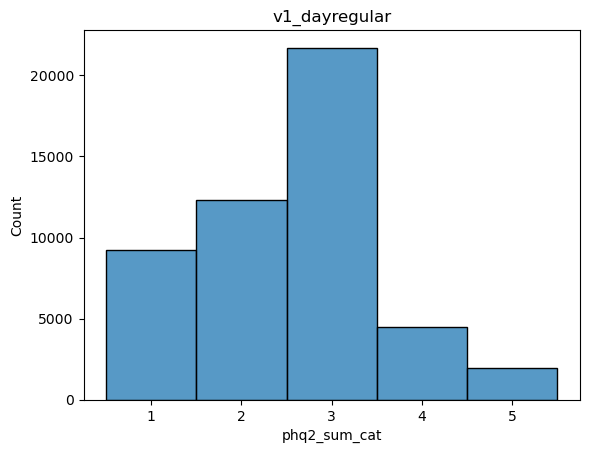

611      10.016242
22354    10.016324
26112    10.008407
Name: phq2_sum, dtype: float64

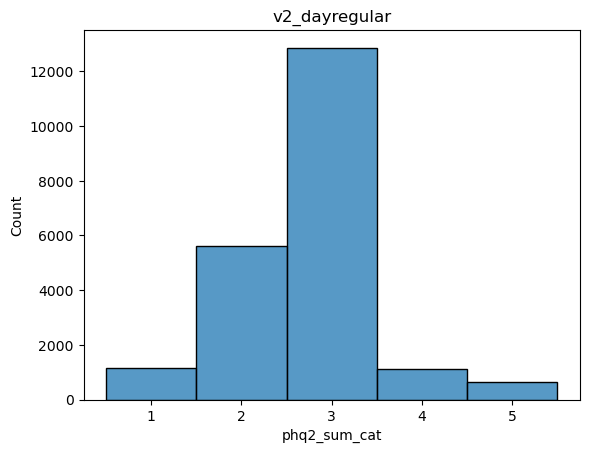

Series([], Name: phq2_sum, dtype: float64)

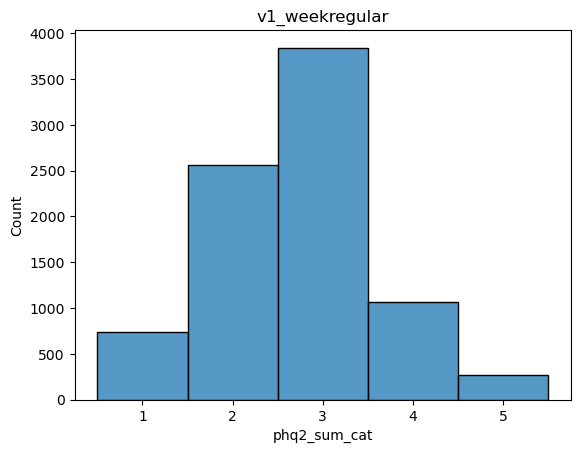

Series([], Name: phq2_sum, dtype: float64)

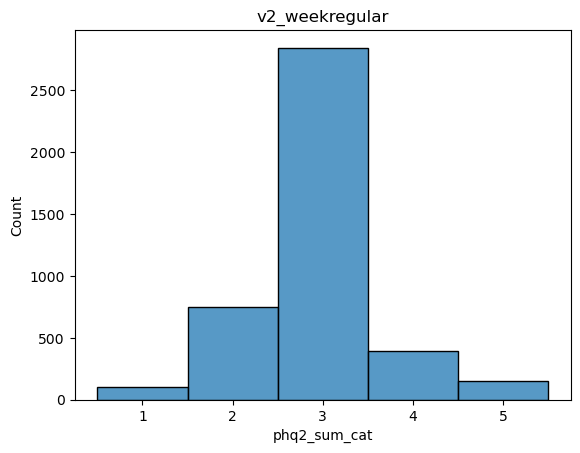

Series([], Name: phq2_sum, dtype: float64)

In [ ]:

# Create bins for phq2 sum data
for name in df_names:
    target_var = 'phq2_sum'
    data_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_imp.csv'))
    data_df = data_df.loc[:, ~data_df.columns.str.contains('^Unnamed')]
    if target_var in data_df.columns:
        # Use these bins so we can categorize the data and allow for stratification, so that there are >1 values per category
        bins = [0, 2, 4, 6, 8, 10]
        # Define bin labels
        labels = np.arange(1, 6)
        # Apply the bins using cut
        data_df['phq2_sum_cat'] = pd.cut(data_df['phq2_sum'], bins = bins, labels= labels, include_lowest=True)

        # Create hisogram for target value
        sns.histplot(data=data_df, x='phq2_sum_cat', bins=5, discrete=True)
        plt.title(name + "regular")
        plt.show()


        # # Make sure there are no NaN
        display(data_df[pd.isna(data_df['phq2_sum_cat'])]['phq2_sum'])
        data_df.to_csv(os.path.join(brighten_dir, f'{name}_binned.csv'))

phq2_cols.append('phq2_sum_cat')


### PHQ9
Question: "Over the last 2 weeks, how often have you been bothered by the following problems?"

|# |Problems |
|:----|:----|
|phq9_1 |Little interest or pleasure in doing things|
|phq9_2 |Feeling down, depressed, or hopeless|
|phq9_3 |Trouble falling or staying asleep, or sleeping too much|
|phq9_4 |Feeling tired or having little energy|
|phq9_5 |Poor appetite or overeating|
|phq9_6 |Feeling bad about yourself or that you are a failure or have let yourself or your family down|
|phq9_7 |Trouble concentrating on things, such as reading the newspaper or watching television|
|phq9_8 |Moving or speaking so slowly that other people could have noticed? Or the opposite; being so fidgety or restless that you have been moving around a lot more than usual|
|phq9_9 |Thoughts that you would be better off dead or of hurting yourself in some way|

Score
| # | Number of days     |
|---|--------------------|
| 1 | Not at all         |
| 2 | Several days       |
| 3 | Over half the days |
| 4 | Nearly every day   |



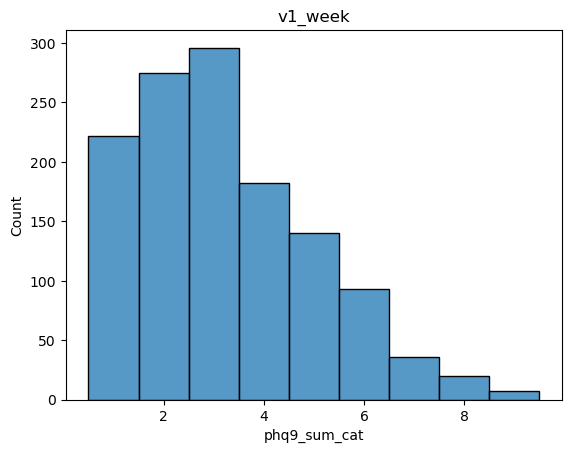

Series([], Name: phq9_sum, dtype: float64)

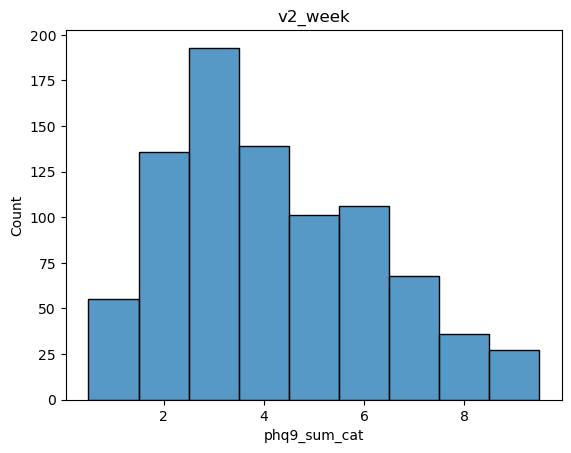

Series([], Name: phq9_sum, dtype: float64)

In [ ]:
# Create bins for phq9 sum data
for name in df_names:
    target_var = 'phq9_sum'
    data_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_clean.csv'))
    data_df = data_df.loc[:, ~data_df.columns.str.contains('^Unnamed')]
    if target_var in data_df.columns:

        # Use these bins so we can categorize the data and allow for stratification
        bins = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
        # Define bin labels
        labels = np.arange(1, 13)

        # Apply the bins using cut
        data_df['phq9_sum_cat'] = pd.cut(data_df['phq9_sum'], bins = bins, labels= labels, include_lowest=True)

        # Create hisogram for target value
        sns.histplot(data_df['phq9_sum_cat'], discrete=True, bins=14)
        plt.title(name)
        plt.show()

        # Make sure there are no NaN
        display(data_df[pd.isna(data_df['phq9_sum_cat'])]['phq9_sum'])
        data_df.to_csv(os.path.join(brighten_dir, f'{name}_binned.csv'))

phq9_cols.append('phq9_sum_cat')


We kept them as raw numbers so they're already binned into discrete categories. 

## Add lag variables

In [459]:
### Create lag variable
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_binned.csv'))
    print(f'\n\nFor {name}:')
    lag = phq9_cols + phq2_cols
    to_lag = [col for col in lag if col in df.columns]
    df_lag = pre.create_lag_variables(df, to_lag)
    display(data_df.head())
    df_lag.to_csv(os.path.join(brighten_dir, f'{name}_lag.csv'), index=False)
    print(f"Saved {name}_lag.csv to brighten_dir")





For v1_day:

 Adding lag of -1 to column: phq2_1 -> phq2_1_lag-1, 49674 rows

 Adding lag of -1 to column: phq2_2 -> phq2_2_lag-1, 49674 rows

 Adding lag of -1 to column: phq2_sum -> phq2_sum_lag-1, 49674 rows


,Unnamed: 0,idx,num_id,dt,week,day,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,hours_stationary_hr,hours_stationary_nhw_hr,hours_walking_hr,location_variance_hr,cloud_cover_mean,dew_point_mean,humidity_mean,temp_mean,dew_point_IQR,humidity_IQR,temp_IQR,cloud_cover_IQR,cloud_cover_std,dew_point_std,humidity_std,temp_std,cloud_cover_median,dew_point_median,humidity_median,temp_median,precip_sum,phq2_2,phq2_sum,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_bin,distance_walking_hr_int,hours_active_hr_int,distance_active_hr_int,distance_powered_vehicle_hr_int,hours_high_speed_transportation_hr_int,hours_of_sleep_hr_int,distance_high_speed_transportation_hr_int,hours_powered_vehicle_hr_int,hours_stationary_hr_int,hours_stationary_nhw_hr_int,hours_walking_hr_int,location_variance_hr_int,cloud_cover_mean_int,dew_point_mean_int,humidity_mean_int,temp_mean_int,dew_point_IQR_int,humidity_IQR_int,temp_IQR_int,cloud_cover_IQR_int,cloud_cover_std_int,dew_point_std_int,humidity_std_int,temp_std_int,cloud_cover_median_int,dew_point_median_int,humidity_median_int,temp_median_int,precip_sum_int,phq2_2_int,phq2_sum_int,phq9_2_int,phq9_3_int,phq9_4_int,phq9_5_int,phq9_6_int,phq9_7_int,phq9_8_int,phq9_9_int,phq9_sum_int,phq9_bin_int,phq9_sum_cat
0,0,1001.0_0,1001.0,2016-11-09,0.0,2.8,-0.690124,2.860271,4.289247,0.745560,-0.115575,-0.314113,-0.13192,1.059958,0.158438,1.040794,-0.524706,0.465491,-0.548029,-0.089006,0.294341,-0.239089,-0.941269,-0.574326,-0.362782,-1.144511,-0.614884,-1.151723,-0.647960,-0.381785,-0.854687,-0.085016,0.478080,-0.284582,-0.587618,3.500000,7.000000,1.0,3.0,2.0,1.0,2.0,1.0,2.0,1.0,14.0,1.0,-0.690124,2.860271,4.289247,0.745560,-0.115575,-0.314113,-0.13192,1.059958,0.158438,1.040794,-0.524706,0.465491,-0.548029,-0.089006,0.294341,-0.239089,-0.941269,-0.574326,-0.362782,-1.144511,-0.614884,-1.151723,-0.647960,-0.381785,-0.854687,-0.085016,0.478080,-0.284582,-0.587618,3.500000,7.000000,1.0,3.0,2.0,1.0,2.0,1.0,2.0,1.0,14.0,1.0,5
1,1,1005.0_0,1005.0,2016-11-09,0.0,1.0,-0.012980,0.866761,1.370409,-0.526331,-0.115575,-0.875281,-0.13192,-0.482278,-0.432322,0.573412,0.000637,0.110406,-1.751369,-0.344145,-0.557358,-0.227029,-1.131665,-0.611189,0.033393,-1.843886,-1.219363,-1.238372,-0.279499,-0.021126,-1.710047,-0.351030,-0.410658,-0.307572,-0.587618,1.000000,2.500000,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,-0.012980,0.866761,1.370409,-0.526331,-0.115575,-0.875281,-0.13192,-0.482278,-0.432322,0.573412,0.000637,0.110406,-1.751369,-0.344145,-0.557358,-0.227029,-1.131665,-0.611189,0.033393,-1.843886,-1.219363,-1.238372,-0.279499,-0.021126,-1.710047,-0.351030,-0.410658,-0.307572,-0.587618,1.000000,2.500000,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,2
2,2,1007.0_7,1007.0,2016-11-16,1.0,9.5,-0.006550,-0.100890,0.047515,-0.387934,-0.115575,1.021579,-0.13192,-0.346823,-0.193928,0.762019,0.020771,-0.175367,-0.032312,-1.033259,-0.497379,-0.895300,0.398277,0.420970,0.957875,-0.014751,0.187214,0.122859,0.531116,1.184169,0.065754,-0.998646,-0.283695,-0.925485,-0.278719,4.166667,8.666667,3.0,3.0,3.0,3.0,3.0,2.0,0.0,0.0,18.0,1.0,-0.006550,-0.100890,0.047515,-0.387934,-0.115575,1.021579,-0.13192,-0.346823,-0.193928,0.762019,0.020771,-0.175367,-0.032312,-1.033259,-0.497379,-0.895300,0.398277,0.420970,0.957875,-0.014751,0.187214,0.122859,0.531116,1.184169,0.065754,-0.998646,-0.283695,-0.925485,-0.278719,4.166667,8.666667,3.0,3.0,3.0,3.0,3.0,2.0,0.0,0.0,18.0,1.0,6
3,3,1021.0_0,1021.0,2016-11-10,0.0,3.0,-0.423552,-0.737818,-0.971911,-0.727591,-0.115575,0.854414,-0.13192,-0.916185,-1.139803,-1.136140,-0.317080,-1.289723,-0.818167,-0.127682,0.342324,-0.243788,0.232178,1.281103,1.367042,-0.839655,-1.126366,0.132642,1.292602,1.251740,-0.929067,-0.128437,0.512706,-0.214327,-0.413367,2.000000,4.000000,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,-0.423552,-0.737818,-0.971911,-0.727591,-0.1

Saved v1_day_lag.csv to brighten_dir


For v2_day:

 Adding lag of -1 to column: phq2_1 -> phq2_1_lag-1, 21433 rows

 Adding lag of -1 to column: phq2_2 -> phq2_2_lag-1, 21433 rows

 Adding lag of -1 to column: phq2_sum -> phq2_sum_lag-1, 21433 rows


,Unnamed: 0,idx,num_id,dt,week,day,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,hours_stationary_hr,hours_stationary_nhw_hr,hours_walking_hr,location_variance_hr,cloud_cover_mean,dew_point_mean,humidity_mean,temp_mean,dew_point_IQR,humidity_IQR,temp_IQR,cloud_cover_IQR,cloud_cover_std,dew_point_std,humidity_std,temp_std,cloud_cover_median,dew_point_median,humidity_median,temp_median,precip_sum,phq2_2,phq2_sum,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_bin,distance_walking_hr_int,hours_active_hr_int,distance_active_hr_int,distance_powered_vehicle_hr_int,hours_high_speed_transportation_hr_int,hours_of_sleep_hr_int,distance_high_speed_transportation_hr_int,hours_powered_vehicle_hr_int,hours_stationary_hr_int,hours_stationary_nhw_hr_int,hours_walking_hr_int,location_variance_hr_int,cloud_cover_mean_int,dew_point_mean_int,humidity_mean_int,temp_mean_int,dew_point_IQR_int,humidity_IQR_int,temp_IQR_int,cloud_cover_IQR_int,cloud_cover_std_int,dew_point_std_int,humidity_std_int,temp_std_int,cloud_cover_median_int,dew_point_median_int,humidity_median_int,temp_median_int,precip_sum_int,phq2_2_int,phq2_sum_int,phq9_2_int,phq9_3_int,phq9_4_int,phq9_5_int,phq9_6_int,phq9_7_int,phq9_8_int,phq9_9_int,phq9_sum_int,phq9_bin_int,phq9_sum_cat
0,0,1001.0_0,1001.0,2016-11-09,0.0,2.8,-0.690124,2.860271,4.289247,0.745560,-0.115575,-0.314113,-0.13192,1.059958,0.158438,1.040794,-0.524706,0.465491,-0.548029,-0.089006,0.294341,-0.239089,-0.941269,-0.574326,-0.362782,-1.144511,-0.614884,-1.151723,-0.647960,-0.381785,-0.854687,-0.085016,0.478080,-0.284582,-0.587618,3.500000,7.000000,1.0,3.0,2.0,1.0,2.0,1.0,2.0,1.0,14.0,1.0,-0.690124,2.860271,4.289247,0.745560,-0.115575,-0.314113,-0.13192,1.059958,0.158438,1.040794,-0.524706,0.465491,-0.548029,-0.089006,0.294341,-0.239089,-0.941269,-0.574326,-0.362782,-1.144511,-0.614884,-1.151723,-0.647960,-0.381785,-0.854687,-0.085016,0.478080,-0.284582,-0.587618,3.500000,7.000000,1.0,3.0,2.0,1.0,2.0,1.0,2.0,1.0,14.0,1.0,5
1,1,1005.0_0,1005.0,2016-11-09,0.0,1.0,-0.012980,0.866761,1.370409,-0.526331,-0.115575,-0.875281,-0.13192,-0.482278,-0.432322,0.573412,0.000637,0.110406,-1.751369,-0.344145,-0.557358,-0.227029,-1.131665,-0.611189,0.033393,-1.843886,-1.219363,-1.238372,-0.279499,-0.021126,-1.710047,-0.351030,-0.410658,-0.307572,-0.587618,1.000000,2.500000,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,-0.012980,0.866761,1.370409,-0.526331,-0.115575,-0.875281,-0.13192,-0.482278,-0.432322,0.573412,0.000637,0.110406,-1.751369,-0.344145,-0.557358,-0.227029,-1.131665,-0.611189,0.033393,-1.843886,-1.219363,-1.238372,-0.279499,-0.021126,-1.710047,-0.351030,-0.410658,-0.307572,-0.587618,1.000000,2.500000,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,2
2,2,1007.0_7,1007.0,2016-11-16,1.0,9.5,-0.006550,-0.100890,0.047515,-0.387934,-0.115575,1.021579,-0.13192,-0.346823,-0.193928,0.762019,0.020771,-0.175367,-0.032312,-1.033259,-0.497379,-0.895300,0.398277,0.420970,0.957875,-0.014751,0.187214,0.122859,0.531116,1.184169,0.065754,-0.998646,-0.283695,-0.925485,-0.278719,4.166667,8.666667,3.0,3.0,3.0,3.0,3.0,2.0,0.0,0.0,18.0,1.0,-0.006550,-0.100890,0.047515,-0.387934,-0.115575,1.021579,-0.13192,-0.346823,-0.193928,0.762019,0.020771,-0.175367,-0.032312,-1.033259,-0.497379,-0.895300,0.398277,0.420970,0.957875,-0.014751,0.187214,0.122859,0.531116,1.184169,0.065754,-0.998646,-0.283695,-0.925485,-0.278719,4.166667,8.666667,3.0,3.0,3.0,3.0,3.0,2.0,0.0,0.0,18.0,1.0,6
3,3,1021.0_0,1021.0,2016-11-10,0.0,3.0,-0.423552,-0.737818,-0.971911,-0.727591,-0.115575,0.854414,-0.13192,-0.916185,-1.139803,-1.136140,-0.317080,-1.289723,-0.818167,-0.127682,0.342324,-0.243788,0.232178,1.281103,1.367042,-0.839655,-1.126366,0.132642,1.292602,1.251740,-0.929067,-0.128437,0.512706,-0.214327,-0.413367,2.000000,4.000000,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,-0.423552,-0.737818,-0.971911,-0.727591,-0.1

Saved v2_day_lag.csv to brighten_dir


For v1_week:

 Adding lag of -1 to column: phq9_2 -> phq9_2_lag-1, 1271 rows

 Adding lag of -1 to column: phq9_3 -> phq9_3_lag-1, 1271 rows

 Adding lag of -1 to column: phq9_4 -> phq9_4_lag-1, 1271 rows

 Adding lag of -1 to column: phq9_5 -> phq9_5_lag-1, 1271 rows

 Adding lag of -1 to column: phq9_6 -> phq9_6_lag-1, 1271 rows

 Adding lag of -1 to column: phq9_7 -> phq9_7_lag-1, 1271 rows

 Adding lag of -1 to column: phq9_8 -> phq9_8_lag-1, 1271 rows

 Adding lag of -1 to column: phq9_9 -> phq9_9_lag-1, 1271 rows

 Adding lag of -1 to column: phq9_sum -> phq9_sum_lag-1, 1271 rows

 Adding lag of -1 to column: phq2_2 -> phq2_2_lag-1, 1271 rows

 Adding lag of -1 to column: phq2_sum -> phq2_sum_lag-1, 1271 rows


,Unnamed: 0,idx,num_id,dt,week,day,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,hours_stationary_hr,hours_stationary_nhw_hr,hours_walking_hr,location_variance_hr,cloud_cover_mean,dew_point_mean,humidity_mean,temp_mean,dew_point_IQR,humidity_IQR,temp_IQR,cloud_cover_IQR,cloud_cover_std,dew_point_std,humidity_std,temp_std,cloud_cover_median,dew_point_median,humidity_median,temp_median,precip_sum,phq2_2,phq2_sum,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_bin,distance_walking_hr_int,hours_active_hr_int,distance_active_hr_int,distance_powered_vehicle_hr_int,hours_high_speed_transportation_hr_int,hours_of_sleep_hr_int,distance_high_speed_transportation_hr_int,hours_powered_vehicle_hr_int,hours_stationary_hr_int,hours_stationary_nhw_hr_int,hours_walking_hr_int,location_variance_hr_int,cloud_cover_mean_int,dew_point_mean_int,humidity_mean_int,temp_mean_int,dew_point_IQR_int,humidity_IQR_int,temp_IQR_int,cloud_cover_IQR_int,cloud_cover_std_int,dew_point_std_int,humidity_std_int,temp_std_int,cloud_cover_median_int,dew_point_median_int,humidity_median_int,temp_median_int,precip_sum_int,phq2_2_int,phq2_sum_int,phq9_2_int,phq9_3_int,phq9_4_int,phq9_5_int,phq9_6_int,phq9_7_int,phq9_8_int,phq9_9_int,phq9_sum_int,phq9_bin_int,phq9_sum_cat
0,0,1001.0_0,1001.0,2016-11-09,0.0,2.8,-0.690124,2.860271,4.289247,0.745560,-0.115575,-0.314113,-0.13192,1.059958,0.158438,1.040794,-0.524706,0.465491,-0.548029,-0.089006,0.294341,-0.239089,-0.941269,-0.574326,-0.362782,-1.144511,-0.614884,-1.151723,-0.647960,-0.381785,-0.854687,-0.085016,0.478080,-0.284582,-0.587618,3.500000,7.000000,1.0,3.0,2.0,1.0,2.0,1.0,2.0,1.0,14.0,1.0,-0.690124,2.860271,4.289247,0.745560,-0.115575,-0.314113,-0.13192,1.059958,0.158438,1.040794,-0.524706,0.465491,-0.548029,-0.089006,0.294341,-0.239089,-0.941269,-0.574326,-0.362782,-1.144511,-0.614884,-1.151723,-0.647960,-0.381785,-0.854687,-0.085016,0.478080,-0.284582,-0.587618,3.500000,7.000000,1.0,3.0,2.0,1.0,2.0,1.0,2.0,1.0,14.0,1.0,5
1,1,1005.0_0,1005.0,2016-11-09,0.0,1.0,-0.012980,0.866761,1.370409,-0.526331,-0.115575,-0.875281,-0.13192,-0.482278,-0.432322,0.573412,0.000637,0.110406,-1.751369,-0.344145,-0.557358,-0.227029,-1.131665,-0.611189,0.033393,-1.843886,-1.219363,-1.238372,-0.279499,-0.021126,-1.710047,-0.351030,-0.410658,-0.307572,-0.587618,1.000000,2.500000,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,-0.012980,0.866761,1.370409,-0.526331,-0.115575,-0.875281,-0.13192,-0.482278,-0.432322,0.573412,0.000637,0.110406,-1.751369,-0.344145,-0.557358,-0.227029,-1.131665,-0.611189,0.033393,-1.843886,-1.219363,-1.238372,-0.279499,-0.021126,-1.710047,-0.351030,-0.410658,-0.307572,-0.587618,1.000000,2.500000,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,2
2,2,1007.0_7,1007.0,2016-11-16,1.0,9.5,-0.006550,-0.100890,0.047515,-0.387934,-0.115575,1.021579,-0.13192,-0.346823,-0.193928,0.762019,0.020771,-0.175367,-0.032312,-1.033259,-0.497379,-0.895300,0.398277,0.420970,0.957875,-0.014751,0.187214,0.122859,0.531116,1.184169,0.065754,-0.998646,-0.283695,-0.925485,-0.278719,4.166667,8.666667,3.0,3.0,3.0,3.0,3.0,2.0,0.0,0.0,18.0,1.0,-0.006550,-0.100890,0.047515,-0.387934,-0.115575,1.021579,-0.13192,-0.346823,-0.193928,0.762019,0.020771,-0.175367,-0.032312,-1.033259,-0.497379,-0.895300,0.398277,0.420970,0.957875,-0.014751,0.187214,0.122859,0.531116,1.184169,0.065754,-0.998646,-0.283695,-0.925485,-0.278719,4.166667,8.666667,3.0,3.0,3.0,3.0,3.0,2.0,0.0,0.0,18.0,1.0,6
3,3,1021.0_0,1021.0,2016-11-10,0.0,3.0,-0.423552,-0.737818,-0.971911,-0.727591,-0.115575,0.854414,-0.13192,-0.916185,-1.139803,-1.136140,-0.317080,-1.289723,-0.818167,-0.127682,0.342324,-0.243788,0.232178,1.281103,1.367042,-0.839655,-1.126366,0.132642,1.292602,1.251740,-0.929067,-0.128437,0.512706,-0.214327,-0.413367,2.000000,4.000000,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,-0.423552,-0.737818,-0.971911,-0.727591,-0.1

Saved v1_week_lag.csv to brighten_dir


For v2_week:

 Adding lag of -1 to column: phq9_2 -> phq9_2_lag-1, 861 rows

 Adding lag of -1 to column: phq9_3 -> phq9_3_lag-1, 861 rows

 Adding lag of -1 to column: phq9_4 -> phq9_4_lag-1, 861 rows

 Adding lag of -1 to column: phq9_5 -> phq9_5_lag-1, 861 rows

 Adding lag of -1 to column: phq9_6 -> phq9_6_lag-1, 861 rows

 Adding lag of -1 to column: phq9_7 -> phq9_7_lag-1, 861 rows

 Adding lag of -1 to column: phq9_8 -> phq9_8_lag-1, 861 rows

 Adding lag of -1 to column: phq9_9 -> phq9_9_lag-1, 861 rows

 Adding lag of -1 to column: phq9_sum -> phq9_sum_lag-1, 861 rows

 Adding lag of -1 to column: phq9_bin -> phq9_bin_lag-1, 861 rows

 Adding lag of -1 to column: phq2_2 -> phq2_2_lag-1, 861 rows

 Adding lag of -1 to column: phq2_sum -> phq2_sum_lag-1, 861 rows


,Unnamed: 0,idx,num_id,dt,week,day,distance_walking_hr,hours_active_hr,distance_active_hr,distance_powered_vehicle_hr,hours_high_speed_transportation_hr,hours_of_sleep_hr,distance_high_speed_transportation_hr,hours_powered_vehicle_hr,hours_stationary_hr,hours_stationary_nhw_hr,hours_walking_hr,location_variance_hr,cloud_cover_mean,dew_point_mean,humidity_mean,temp_mean,dew_point_IQR,humidity_IQR,temp_IQR,cloud_cover_IQR,cloud_cover_std,dew_point_std,humidity_std,temp_std,cloud_cover_median,dew_point_median,humidity_median,temp_median,precip_sum,phq2_2,phq2_sum,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_sum,phq9_bin,distance_walking_hr_int,hours_active_hr_int,distance_active_hr_int,distance_powered_vehicle_hr_int,hours_high_speed_transportation_hr_int,hours_of_sleep_hr_int,distance_high_speed_transportation_hr_int,hours_powered_vehicle_hr_int,hours_stationary_hr_int,hours_stationary_nhw_hr_int,hours_walking_hr_int,location_variance_hr_int,cloud_cover_mean_int,dew_point_mean_int,humidity_mean_int,temp_mean_int,dew_point_IQR_int,humidity_IQR_int,temp_IQR_int,cloud_cover_IQR_int,cloud_cover_std_int,dew_point_std_int,humidity_std_int,temp_std_int,cloud_cover_median_int,dew_point_median_int,humidity_median_int,temp_median_int,precip_sum_int,phq2_2_int,phq2_sum_int,phq9_2_int,phq9_3_int,phq9_4_int,phq9_5_int,phq9_6_int,phq9_7_int,phq9_8_int,phq9_9_int,phq9_sum_int,phq9_bin_int,phq9_sum_cat
0,0,1001.0_0,1001.0,2016-11-09,0.0,2.8,-0.690124,2.860271,4.289247,0.745560,-0.115575,-0.314113,-0.13192,1.059958,0.158438,1.040794,-0.524706,0.465491,-0.548029,-0.089006,0.294341,-0.239089,-0.941269,-0.574326,-0.362782,-1.144511,-0.614884,-1.151723,-0.647960,-0.381785,-0.854687,-0.085016,0.478080,-0.284582,-0.587618,3.500000,7.000000,1.0,3.0,2.0,1.0,2.0,1.0,2.0,1.0,14.0,1.0,-0.690124,2.860271,4.289247,0.745560,-0.115575,-0.314113,-0.13192,1.059958,0.158438,1.040794,-0.524706,0.465491,-0.548029,-0.089006,0.294341,-0.239089,-0.941269,-0.574326,-0.362782,-1.144511,-0.614884,-1.151723,-0.647960,-0.381785,-0.854687,-0.085016,0.478080,-0.284582,-0.587618,3.500000,7.000000,1.0,3.0,2.0,1.0,2.0,1.0,2.0,1.0,14.0,1.0,5
1,1,1005.0_0,1005.0,2016-11-09,0.0,1.0,-0.012980,0.866761,1.370409,-0.526331,-0.115575,-0.875281,-0.13192,-0.482278,-0.432322,0.573412,0.000637,0.110406,-1.751369,-0.344145,-0.557358,-0.227029,-1.131665,-0.611189,0.033393,-1.843886,-1.219363,-1.238372,-0.279499,-0.021126,-1.710047,-0.351030,-0.410658,-0.307572,-0.587618,1.000000,2.500000,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,-0.012980,0.866761,1.370409,-0.526331,-0.115575,-0.875281,-0.13192,-0.482278,-0.432322,0.573412,0.000637,0.110406,-1.751369,-0.344145,-0.557358,-0.227029,-1.131665,-0.611189,0.033393,-1.843886,-1.219363,-1.238372,-0.279499,-0.021126,-1.710047,-0.351030,-0.410658,-0.307572,-0.587618,1.000000,2.500000,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,2
2,2,1007.0_7,1007.0,2016-11-16,1.0,9.5,-0.006550,-0.100890,0.047515,-0.387934,-0.115575,1.021579,-0.13192,-0.346823,-0.193928,0.762019,0.020771,-0.175367,-0.032312,-1.033259,-0.497379,-0.895300,0.398277,0.420970,0.957875,-0.014751,0.187214,0.122859,0.531116,1.184169,0.065754,-0.998646,-0.283695,-0.925485,-0.278719,4.166667,8.666667,3.0,3.0,3.0,3.0,3.0,2.0,0.0,0.0,18.0,1.0,-0.006550,-0.100890,0.047515,-0.387934,-0.115575,1.021579,-0.13192,-0.346823,-0.193928,0.762019,0.020771,-0.175367,-0.032312,-1.033259,-0.497379,-0.895300,0.398277,0.420970,0.957875,-0.014751,0.187214,0.122859,0.531116,1.184169,0.065754,-0.998646,-0.283695,-0.925485,-0.278719,4.166667,8.666667,3.0,3.0,3.0,3.0,3.0,2.0,0.0,0.0,18.0,1.0,6
3,3,1021.0_0,1021.0,2016-11-10,0.0,3.0,-0.423552,-0.737818,-0.971911,-0.727591,-0.115575,0.854414,-0.13192,-0.916185,-1.139803,-1.136140,-0.317080,-1.289723,-0.818167,-0.127682,0.342324,-0.243788,0.232178,1.281103,1.367042,-0.839655,-1.126366,0.132642,1.292602,1.251740,-0.929067,-0.128437,0.512706,-0.214327,-0.413367,2.000000,4.000000,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,-0.423552,-0.737818,-0.971911,-0.727591,-0.1

Saved v2_week_lag.csv to brighten_dir


In [463]:
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f"{name}_lag.csv"))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  
    print(name, df.shape)
    display(df.isna().sum())


v1_day (49674, 21)


num_id                        0
dt                            0
week                          0
day                           0
idx                           0
sms_count                     0
call_count                    0
unreturned_calls              0
aggregate_communication       0
interaction_diversity         0
call_duration                 0
sms_length                    0
mobility_radius               0
phq2_1                        0
phq2_2                        0
phq2_sum                      0
mobility                      0
phq2_sum_cat                  3
phq2_1_lag-1               1136
phq2_2_lag-1               1136
phq2_sum_lag-1             1136
dtype: int64

v2_day (21433, 41)


num_id                                     0
dt                                         0
week                                       0
day                                        0
idx                                        0
humidity_std                               0
dew_point_std                              0
humidity_IQR                               0
cloud_cover_IQR                            0
cloud_cover_mean                           0
humidity_mean                              0
dew_point_IQR                              0
humidity_median                            0
precip_sum                                 0
cloud_cover_median                         0
temp_mean                                  0
dew_point_median                           0
dew_point_mean                             0
temp_std                                   0
temp_median                                0
temp_IQR                                   0
cloud_cover_std                            0
location_v

v1_week (1271, 59)


idx                              0
num_id                           0
dt                               0
week                             0
day                              0
aggregate_communication          0
call_count                       0
call_duration                    0
interaction_diversity            0
missed_interactions              0
mobility                         0
mobility_radius                  0
sms_count                        0
sms_length                       0
unreturned_calls                 0
phq2_2                           0
phq2_sum                         0
phq9_2                           0
phq9_3                           0
phq9_4                           0
phq9_5                           0
phq9_6                           0
phq9_7                           0
phq9_8                           0
phq9_9                           0
phq9_sum                         0
aggregate_communication_int      0
call_count_int                   0
call_duration_int   

v2_week (861, 100)


idx                 0
num_id              0
dt                  0
week                0
day                 0
                 ... 
phq9_9_lag-1      222
phq9_sum_lag-1    222
phq9_bin_lag-1    222
phq2_2_lag-1      222
phq2_sum_lag-1    222
Length: 100, dtype: int64

### Drop NA rows

Now we'll drop rows with NAN values, and see how many rows we have left. 

In [468]:
## DROPPING ROWS WITH ANY NA VALUES
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f"{name}_binned.csv"))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  
    df = df.loc[:, ~df.columns.str.contains('.1')]  
    df_clean = df.dropna()
    print(f'{name}, Shape of df {df.shape}, shape of clean df {df_clean.shape}')
    df_clean.to_csv(os.path.join(brighten_dir, f"{name}_clean.csv"))
        
        

v1_day, Shape of df (49674, 17), shape of clean df (49671, 17)
v2_day, Shape of df (21433, 37), shape of clean df (21433, 37)
v1_week, Shape of df (1271, 48), shape of clean df (1271, 48)
v2_week, Shape of df (861, 88), shape of clean df (861, 88)


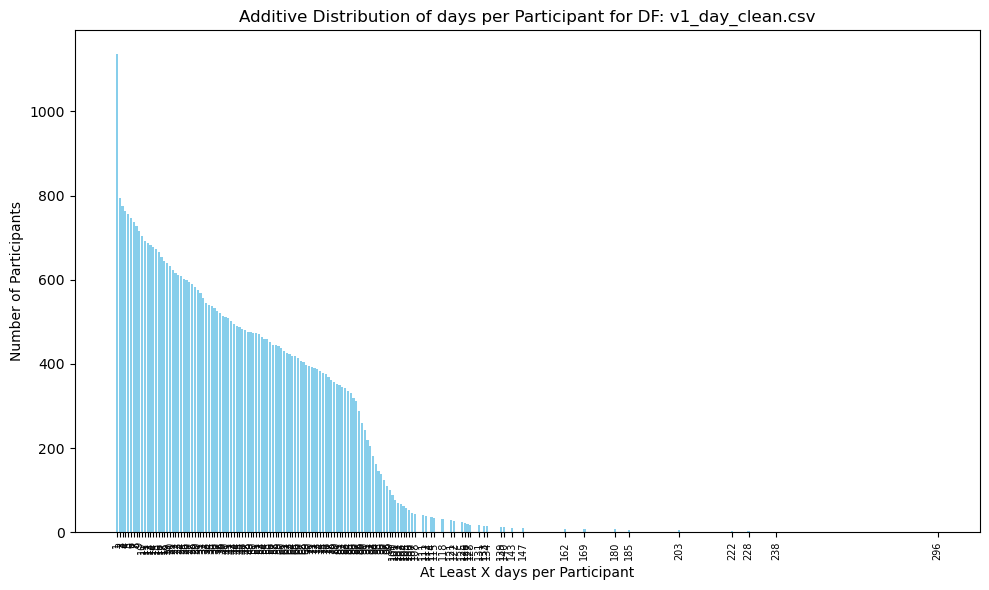

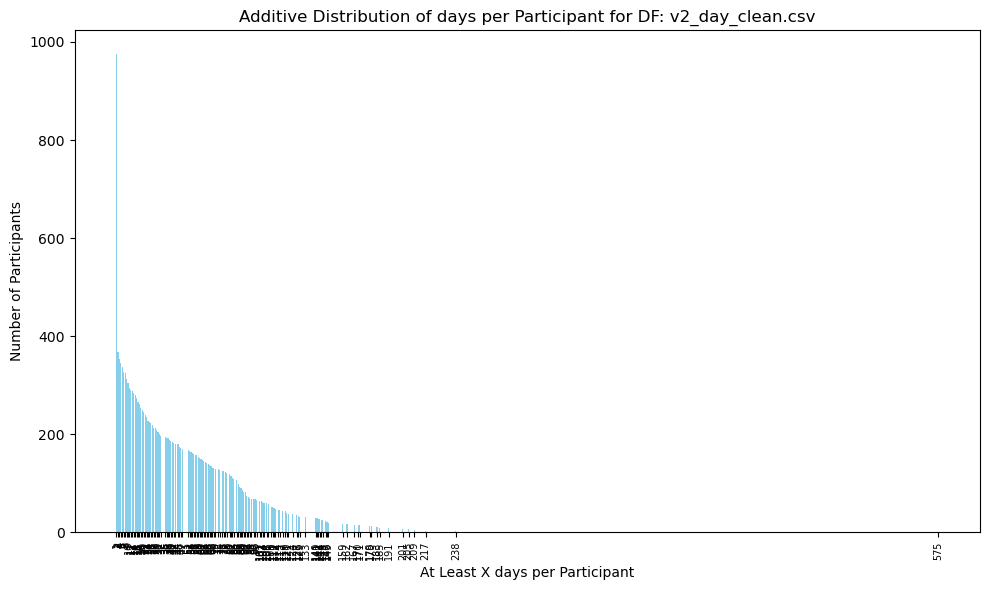

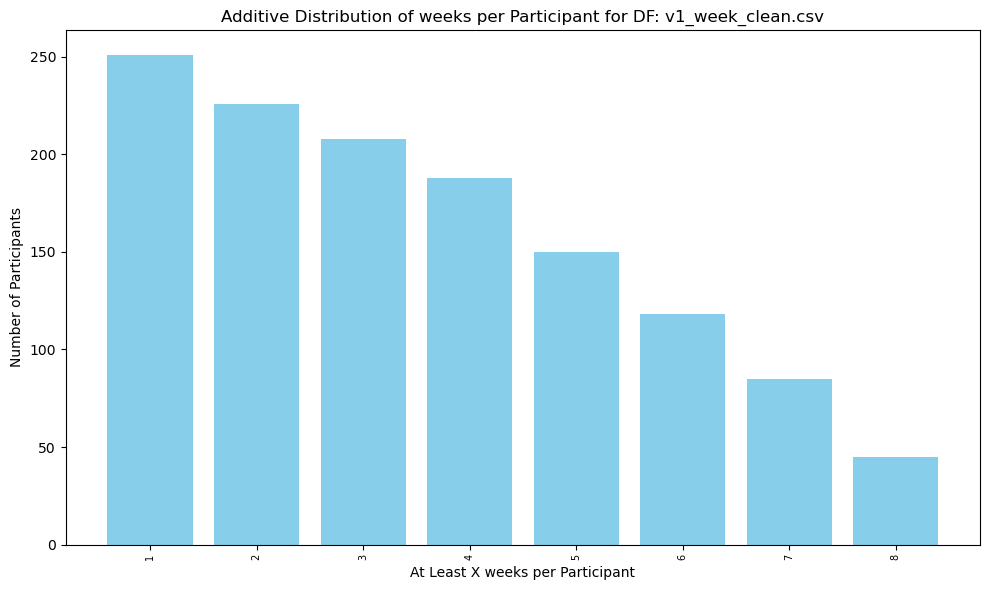

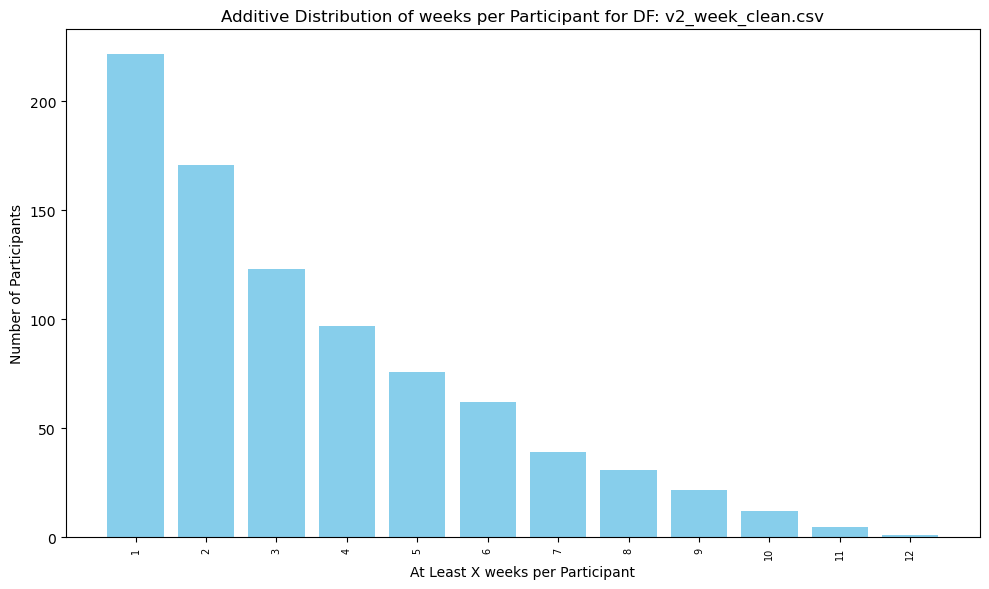

In [469]:
############## Plot-- how many weeks/days does each participant have #############
for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_clean.csv'))
    if 'day' in name:
        time_period='day'
    elif 'week' in name:
         time_period='week'

    vis.plot_participants_per_time(df, time_period=time_period, title=f'{name}_clean.csv')


In [ ]:
# Regress out covariates

# Define covariates
demographic_vars = ['gender','age','race']                # covariates
id_demo_columns = id_columns + demographic_vars
demo_df = pd.read_csv(os.path.join(brighten_dir, f'demographics.csv'))
demo_df = demo_df.loc[:, ~demo_df.columns.str.contains('^Unnamed')] 
# Subset datasets
for name in df_names:
    print(f'________________ {name} ________________')
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}_clean.csv'))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
    print(f'df is {df.shape} and has {df['num_id'].nunique()} subjects')
    merged = df.merge(demo_df[['num_id']+ demographic_vars], on='num_id',how='left')
    print(f"For df {name}, there are {merged['num_id'].nunique()} subjects, {merged['age'].isna().sum() } subjects missing age, {merged['gender'].isna().sum()} missing gender, {merged['race'].isna().sum()} missing race.")
    merged.to_csv(os.path.join(brighten_dir, f'{name}_demo.csv'), index=False)
    
    merged_clean = merged.dropna()
    print(f"Dropped {merged.shape[0]-merged_clean.shape[0]} columns")
    df_res = pre.regress_covariates(merged_clean, to_regress_out=demographic_vars, to_ignore=id_columns+phq2_cols+phq9_cols)
    df_res.to_csv(os.path.join(brighten_dir, f'{name}_res.csv'), index=False)
    print(f'Saved df name: {name} to {name}_res.csv')



________________ v1_day ________________
df is (49671, 17) and has 1136 subjects
For df v1_day, there are 1136 subjects, 0 subjects missing age, 0 missing gender, 0 missing race.
Dropped 0 columns
Saved df name: v1_day to v1_day_res.csv
________________ v2_day ________________
df is (21433, 37) and has 975 subjects
For df v2_day, there are 975 subjects, 0 subjects missing age, 0 missing gender, 0 missing race.
Dropped 0 columns
Saved df name: v2_day to v2_day_res.csv
________________ v1_week ________________
df is (1271, 48) and has 251 subjects
For df v1_week, there are 251 subjects, 0 subjects missing age, 0 missing gender, 0 missing race.
Dropped 0 columns
Saved df name: v1_week to v1_week_res.csv
________________ v2_week ________________
df is (861, 88) and has 222 subjects
For df v2_week, there are 222 subjects, 0 subjects missing age, 0 missing gender, 0 missing race.
Dropped 0 columns
Saved df name: v2_week to v2_week_res.csv


If we want to use the lagged variables later, we can use them in _lag. But for now we'll keep to the clean so we don't have to drop all the rows where lag is NA.

### Split
Now we can split the data into val, train and test, and visualize the distribution of the target variable in each dataset. 

Awesome, the distributions look pretty uniform across the val, train and test sets within each dataset for phq2.



FOR v1_day, target_var: phq2_sum_cat


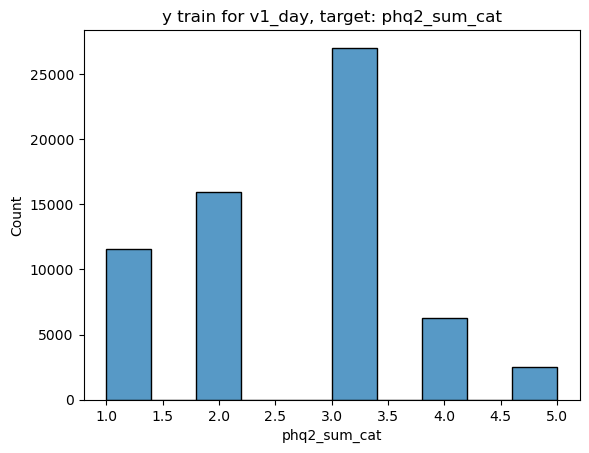

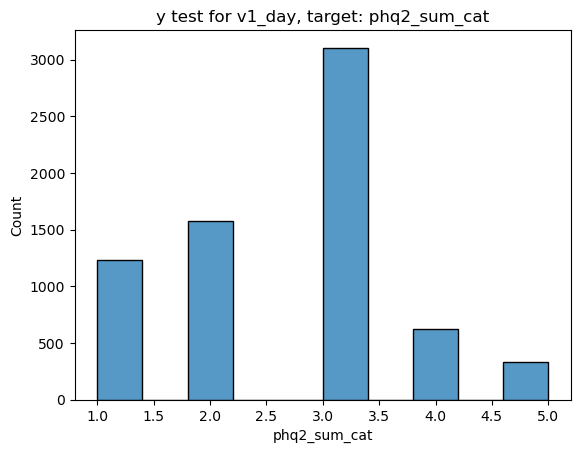



FOR v2_day, target_var: phq2_sum_cat


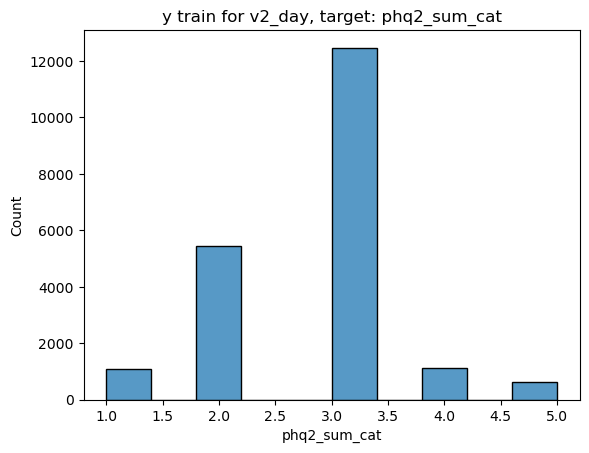

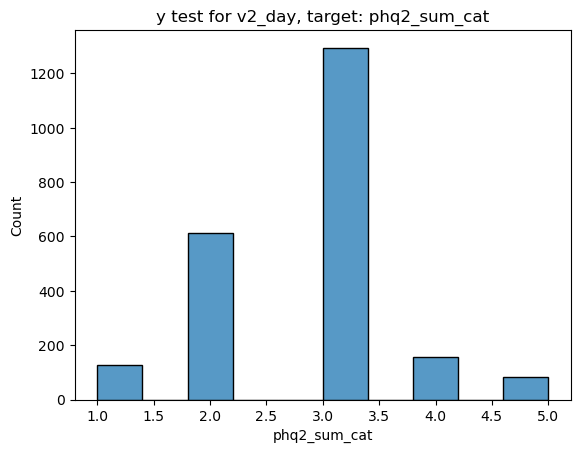



FOR v1_week, target_var: phq9_sum_cat


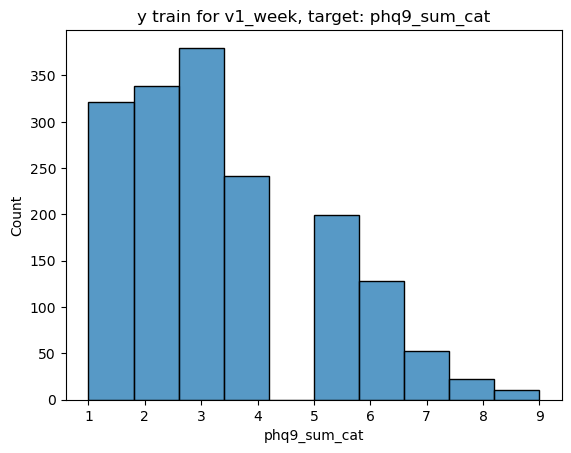

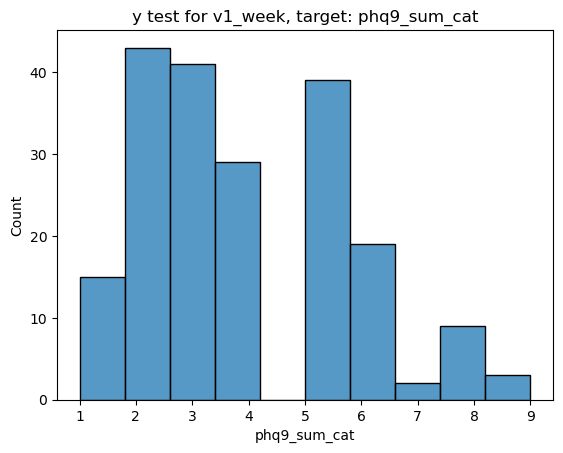



FOR v2_week, target_var: phq9_sum_cat


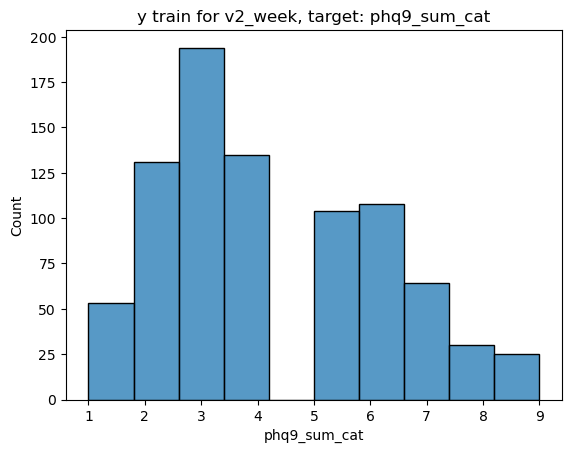

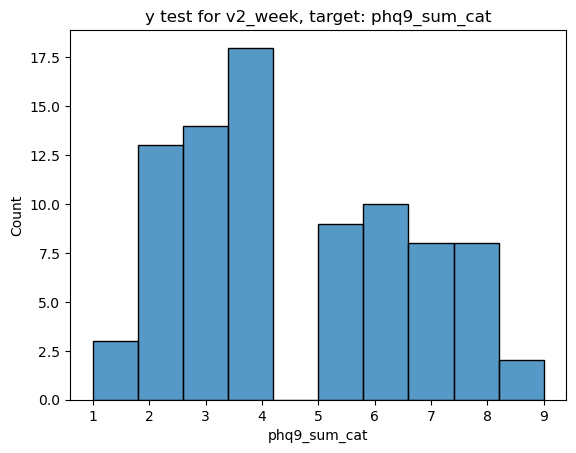

In [517]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

for name in df_names:
    data_df = pd.read_csv(os.path.join(brighten_dir, f'{name}_res.csv'))
    data_df = data_df.dropna()
    if not data_df.empty:
        if 'phq9_sum_cat' in data_df.columns:
            target_var = 'phq9_sum_cat'
        else:
            target_var = 'phq2_sum_cat'
        print(f"\n\nFOR {name}, target_var: {target_var}")

        X = data_df.drop(columns=[col for col in data_df.columns if 'phq9' in col or 'phq2' in col]).copy()
        y = data_df[target_var].copy()

        gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
        groups = data_df['num_id'] # groups variable is based on num_id, so that no subjects are in train and test etc, 
        traintest_idx, val_idx = next(gss.split(X, y, groups=groups))

        # Get train/test sets
        X_train, X_test = X.iloc[traintest_idx], X.iloc[val_idx]
        y_train, y_test = y.iloc[traintest_idx], y.iloc[val_idx]

        # gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
        # groups_traintest = groups.iloc[traintest_idx]  # redefining groups to only include subs in traintest df
        # train_idx, test_idx = next(gss.split(X_traintest, y_traintest, groups=groups_traintest))

        # # Get train/test sets
        # X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        # y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # X_val.to_csv(os.path.join(brighten_dir, f'{name}_X_val.csv'))
        # y_val.to_csv(os.path.join(brighten_dir, f'{name}_y_val.csv'))
        X_train.to_csv(os.path.join(brighten_dir, f'{name}_X_train.csv'))
        y_train.to_csv(os.path.join(brighten_dir, f'{name}_y_train.csv'))
        X_test.to_csv(os.path.join(brighten_dir, f'{name}_X_test.csv'))
        y_test.to_csv(os.path.join(brighten_dir, f'{name}_y_test.csv'))


        # # Create hisogram for target value
        # sns.histplot(y_val, bins=10)
        # plt.title(f'y val for {name}, target: {target_var}')
        # plt.show()

        # Create hisogram for target value
        sns.histplot(y_train, bins=10)
        plt.title(f'y train for {name}, target: {target_var}')
        plt.show()

        # Create hisogram for target value
        sns.histplot(y_test, bins=10)
        plt.title(f'y test for {name}, target: {target_var}')
        plt.show()


Great, the distributions also look pretty uniform across the val, train and test sets within each dataset for phq9.

In [ ]:
#Here's the full distribution of how the data changed over the transofrmations

for name in df_names:
    df = pd.read_csv(os.path.join(brighten_dir, f'{name}.csv'))
    if 'v2_week' not in name:
        print(name, df.shape)
        for end in df_endings:
            if os.path.exists(os.path.join(brighten_dir, f'{name}_{end}.csv')):
                df = pd.read_csv(os.path.join(brighten_dir, f'{name}_{end}.csv'))
                print(f'{name}_{end}', df.shape)
    

v1_day (49674, 18)
v1_day_dem (50716, 23)
v1_day_nonO (49674, 18)
v1_day_setNaN (49674, 18)
v1_day_transformed (49674, 17)
v1_day_unskewed (50716, 21)
v1_day_scaled (49674, 18)
v1_day_dropped (49674, 19)
v1_day_int (49674, 31)
v1_day_imp (49674, 18)
v1_day_clean (49671, 18)
v1_day_binned (49674, 19)
v1_day_lag (49674, 22)
v2_day (21433, 53)
v2_day_dem (22480, 58)
v2_day_nonO (21433, 53)
v2_day_setNaN (21433, 53)
v2_day_transformed (21433, 57)
v2_day_unskewed (22480, 55)
v2_day_scaled (21433, 53)
v2_day_dropped (21433, 38)
v2_day_int (21433, 69)
v2_day_imp (21433, 38)
v2_day_clean (21433, 38)
v2_day_binned (21433, 39)
v2_day_lag (21433, 42)
v1_week (8469, 29)
v1_week_dem (9460, 34)
v1_week_nonO (8469, 29)
v1_week_setNaN (8469, 29)
v1_week_transformed (8469, 28)
v1_week_unskewed (9460, 30)
v1_week_scaled (8469, 29)
v1_week_dropped (8469, 29)
v1_week_int (8469, 51)
v1_week_imp (8469, 28)
v1_week_clean (1271, 49)
v1_week_binned (1271, 49)
v1_week_lag (1271, 60)
